This will walkthrough the entire baseline clustering on the CTMs. Note that this is simply a notebook overview of the functions found in `scripts/ctms_general.py`

**NOTE**: You can find our own implementations of clustering algorithms in the `models/cluster.py` file. These were tested on a much smaller corpus, however run time duration and memory issues became apparent when scaling to the full dataset. With this in mind we default to sklearn's implementations in the notebook.

Baseline Clustering with CTMs

In [1]:
import os
os.chdir('..')

1. Let's load the dataset

In [2]:
from utils.load import load_ctms_dataset
ctms_df = load_ctms_dataset("data/videogame_sequences/sequence_dataset.parquet")
ctms_df.head()

name  \
0  Star Wars: Rogue Squadron II - Rogue Leader   
1  Star Wars: Rogue Squadron II - Rogue Leader   
2                      Donkey Kong Jungle Beat   
3                      Donkey Kong Jungle Beat   
4                                Viewtiful Joe   

                                       note_sequence  \
0  [55, 55, 60, 60, 48, 48, 51, 51, 62, 62, 56, 5...   
1  [59, 38, 47, 47, 59, 47, 47, 38, 59, 47, 38, 4...   
2  [45, 64, 61, 57, 64, 61, 57, 45, 57, 64, 61, 4...   
3  [70, 71, 72, 73, 42, 23, 49, 73, 61, 56, 49, 6...   
4  [33, 33, 75, 81, 33, 36, 36, 36, 38, 38, 59, 3...   

                                                 ctm      id rating  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...    4181   85.4   
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...    4181   85.4   
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...    1097   67.7   
3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...    1097   67.7   
4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  341259      0   

                          themes  \
0  ["Action", "Science fiction"]   
1  ["Action", "Science fiction"]   
2                     ["Action"]   
3                     ["Action"]   
4                     ["Action"]   

                                            keywords  \
0  ["space simulation", "space combat", "robots",...   
1  ["space simulation", "space combat", "robots",...   
2  ["combat", "pig", "panda", "underwater gamepla...   
3  ["combat", "pig", "panda", "underwater gamepla...   
4                                                 []   

                                  involved_companies first_release_year  \
0            ["Activision", "Factor 5", "LucasArts"]               2001   
1            ["Activision", "Factor 5", "LucasArts"]               2001   
2  ["Nintendo EAD Tokyo Software Development Grou...               2004   
3  ["Nintendo EAD Tokyo Software Development Grou...               2004   
4                        ["Clover Studio", "Capcom"]               2004   

                                            metadata  
0  star wars rogue squadron ii rogue leader actio...  
1  star wars rogue squadron ii rogue leader actio...  
2  donkey kong jungle beat action combat pig pand...  
3  donkey kong jungle beat action combat pig pand...  
4          viewtiful joe action clover studio capcom

We need to preprocess. This involves: Converting ctm (currently nested lists) into 129x129 matrix -> Flatten -> Perform PCA to reduce dimensionality (also use mahalanobis distance thresholding).

In [3]:
from scripts.ctms_general import preprocess_ctms
preprocessed_ctms_df, X_pca = preprocess_ctms(ctms_df, n_components=30) 
X_pca.shape

2025-12-03 01:27:49.939 | INFO     | scripts.ctms_general:preprocess_ctms:99 - CTMs: PCA -> 920 dims (≥90% variance)
2025-12-03 01:27:52.808 | INFO     | scripts.ctms_general:preprocess_ctms:109 - Removed 75 outliers (Mahalanobis, χ² threshold=59.70)


(3245, 30)

Now we proceed with cluster tuning based on davies bouldin and silhouette

In [4]:
from scripts.ctms_general import tune_clusters

tuning_results = tune_clusters(
    preprocessed_ctms_df,
    k_list=list(range(2, 21)),
    n_components=30,
    save = False
)
tuning_results

2025-12-03 01:27:52.995 | INFO     | scripts.ctms_general:tune_clusters:129 - Preprocessing CTMs...
2025-12-03 01:28:53.508 | INFO     | scripts.ctms_general:preprocess_ctms:99 - CTMs: PCA -> 1007 dims (≥90% variance)
2025-12-03 01:28:54.628 | INFO     | scripts.ctms_general:preprocess_ctms:109 - Removed 122 outliers (Mahalanobis, χ² threshold=59.70)
Tuning KMeans: 100%|██████████| 19/19 [00:06<00:00,  2.76it/s]


({'kmeans': {2: 0.41819456243229913,
   3: 0.4198776452014538,
   4: 0.4151985968255067,
   5: 0.33940658911710375,
   6: 0.27270226167488953,
   7: 0.2640588416022158,
   8: 0.24911228225903637,
   9: 0.24726223050387355,
   10: 0.25537651307267467,
   11: 0.2440433239429885,
   12: 0.2242210211713537,
   13: 0.22743571553903896,
   14: 0.23123595293826274,
   15: 0.23267787138160775,
   16: 0.23718641585796807,
   17: 0.22469065182423725,
   18: 0.2353308785598355,
   19: 0.22278822986080135,
   20: 0.22970065304182444},
  'dbscan': {},
  'hierarchical': {}},
 {'kmeans': {2: 1.9115292884630906,
   3: 1.930917657944214,
   4: 1.8579446573388783,
   5: 1.8017554604122452,
   6: 1.7651167814352406,
   7: 1.7642257831120918,
   8: 1.8012879011532896,
   9: 1.8486739542087942,
   10: 1.843211803130523,
   11: 1.8272192876939284,
   12: 1.8718096915957299,
   13: 1.8300483897394066,
   14: 1.8252476868551955,
   15: 1.831852386467223,
   16: 1.840897400382949,
   17: 1.840783515615391,
   

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams.update({
    # --- Figure ---
    "figure.figsize": (6, 4),
    "figure.dpi": 300,

    # --- Fonts ---
    "font.size": 11,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "font.family": "serif",       # or "sans-serif"
    "mathtext.fontset": "stix",   # clean math font

    # --- Axes ---
    "axes.edgecolor": "black",
    "axes.linewidth": 0.8,
    "axes.grid": False,

    # --- Ticks ---
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.major.size": 3,
    "ytick.major.size": 3,
    "xtick.major.width": 0.7,
    "ytick.major.width": 0.7,

    # --- Legend ---
    "legend.fontsize": 10,
    "legend.frameon": False,

    # --- Colors / Colormap ---
    "image.cmap": "viridis",
})

plot the tuning results (from results)

In [6]:
import json
with open('results/ctms_general/json/ctm_tuning_scores.json', 'r') as f:
    tuning_results = json.load(f)
    
tuning_results

{'silhouette': {'kmeans': {'2': 0.49901745927628105,
   '3': 0.4779488235542436,
   '4': 0.4650267192720845,
   '5': 0.3503332158249229,
   '6': 0.36203184026406576,
   '7': 0.3547597568847556,
   '8': 0.3023987915449259,
   '9': 0.310902755045113,
   '10': 0.31268342082139283,
   '12': 0.2739557094404988,
   '15': 0.24650370085405868,
   '20': 0.2502384818544209,
   '25': 0.23527212132742312},
  'dbscan': {},
  'hierarchical': {}},
 'davies_bouldin': {'kmeans': {'2': 1.4829030178177645,
   '3': 1.5360256822949419,
   '4': 1.4316153582017377,
   '5': 1.4364433562651286,
   '6': 1.4305385275483677,
   '7': 1.326478982554455,
   '8': 1.4081285111185002,
   '9': 1.4143978938577115,
   '10': 1.3893598331489299,
   '12': 1.4249217928056757,
   '15': 1.480327257237362,
   '20': 1.4377661614878117,
   '25': 1.423604978467052},
  'dbscan': {},
  'hierarchical': {}}}

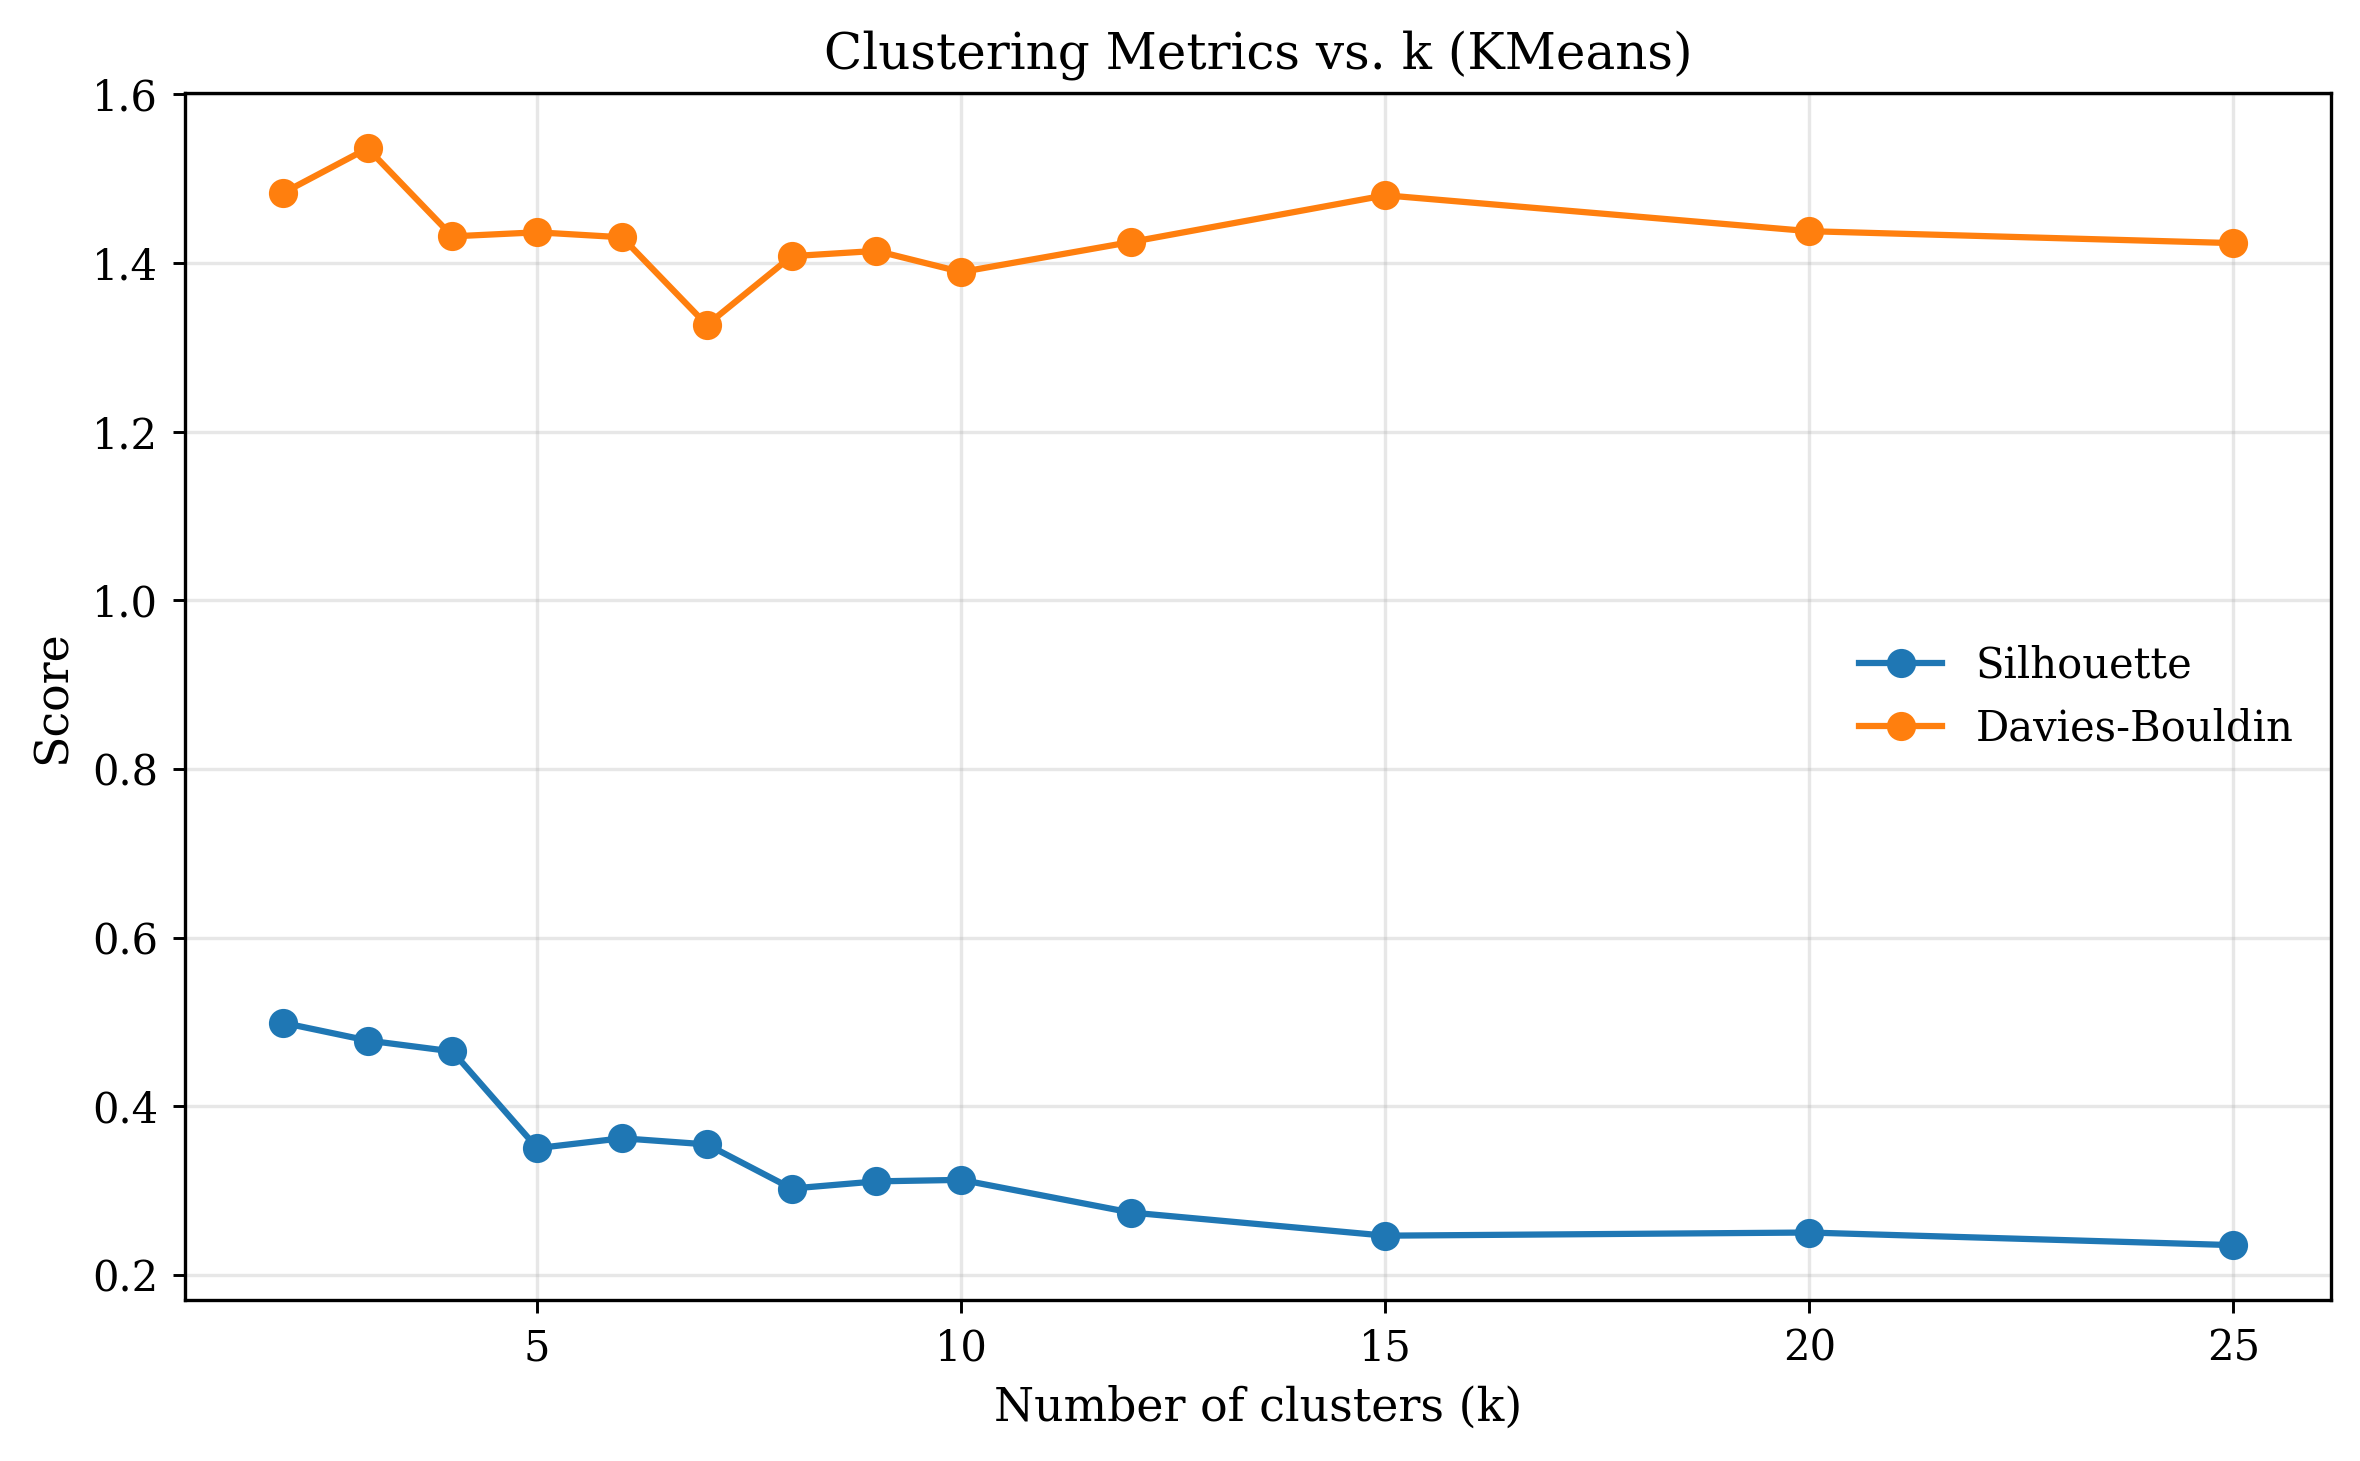

In [ ]:
def plot_cluster_metrics(
    results: dict
):
    """
    Plot silhouette and Davies-Bouldin scores 

    Parameters
    ----------
    results : dict
    """
    silhouette_scores = results["silhouette"]["kmeans"]
    davies_bouldin_scores = results["davies_bouldin"]["kmeans"]

    # Convert keys to integers and sort
    ks_sil = sorted(int(k) for k in silhouette_scores.keys())
    vals_sil = [silhouette_scores[str(k)] for k in ks_sil]
    ks_db = sorted(int(k) for k in davies_bouldin_scores.keys())
    vals_db = [davies_bouldin_scores[str(k)] for k in ks_db]

    plt.figure(figsize=(8,5))

    plt.plot(ks_sil, vals_sil, marker="o", label="Silhouette")
    plt.plot(ks_db,  vals_db,  marker="o", label="Davies-Bouldin")

    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Score")
    plt.title("Clustering Metrics vs. k (KMeans)")
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_cluster_metrics(results=tuning_results)

Based on this, we select $k=6$

In [8]:
k=6

In [ ]:
from scripts.ctms_general import plot_clusters

2025-12-03 01:32:23.972 | INFO     | scripts.ctms_general:preprocess_ctms:99 - CTMs: PCA -> 1007 dims (≥90% variance)
2025-12-03 01:32:25.064 | INFO     | scripts.ctms_general:preprocess_ctms:109 - Removed 126 outliers (Mahalanobis, χ² threshold=59.70)


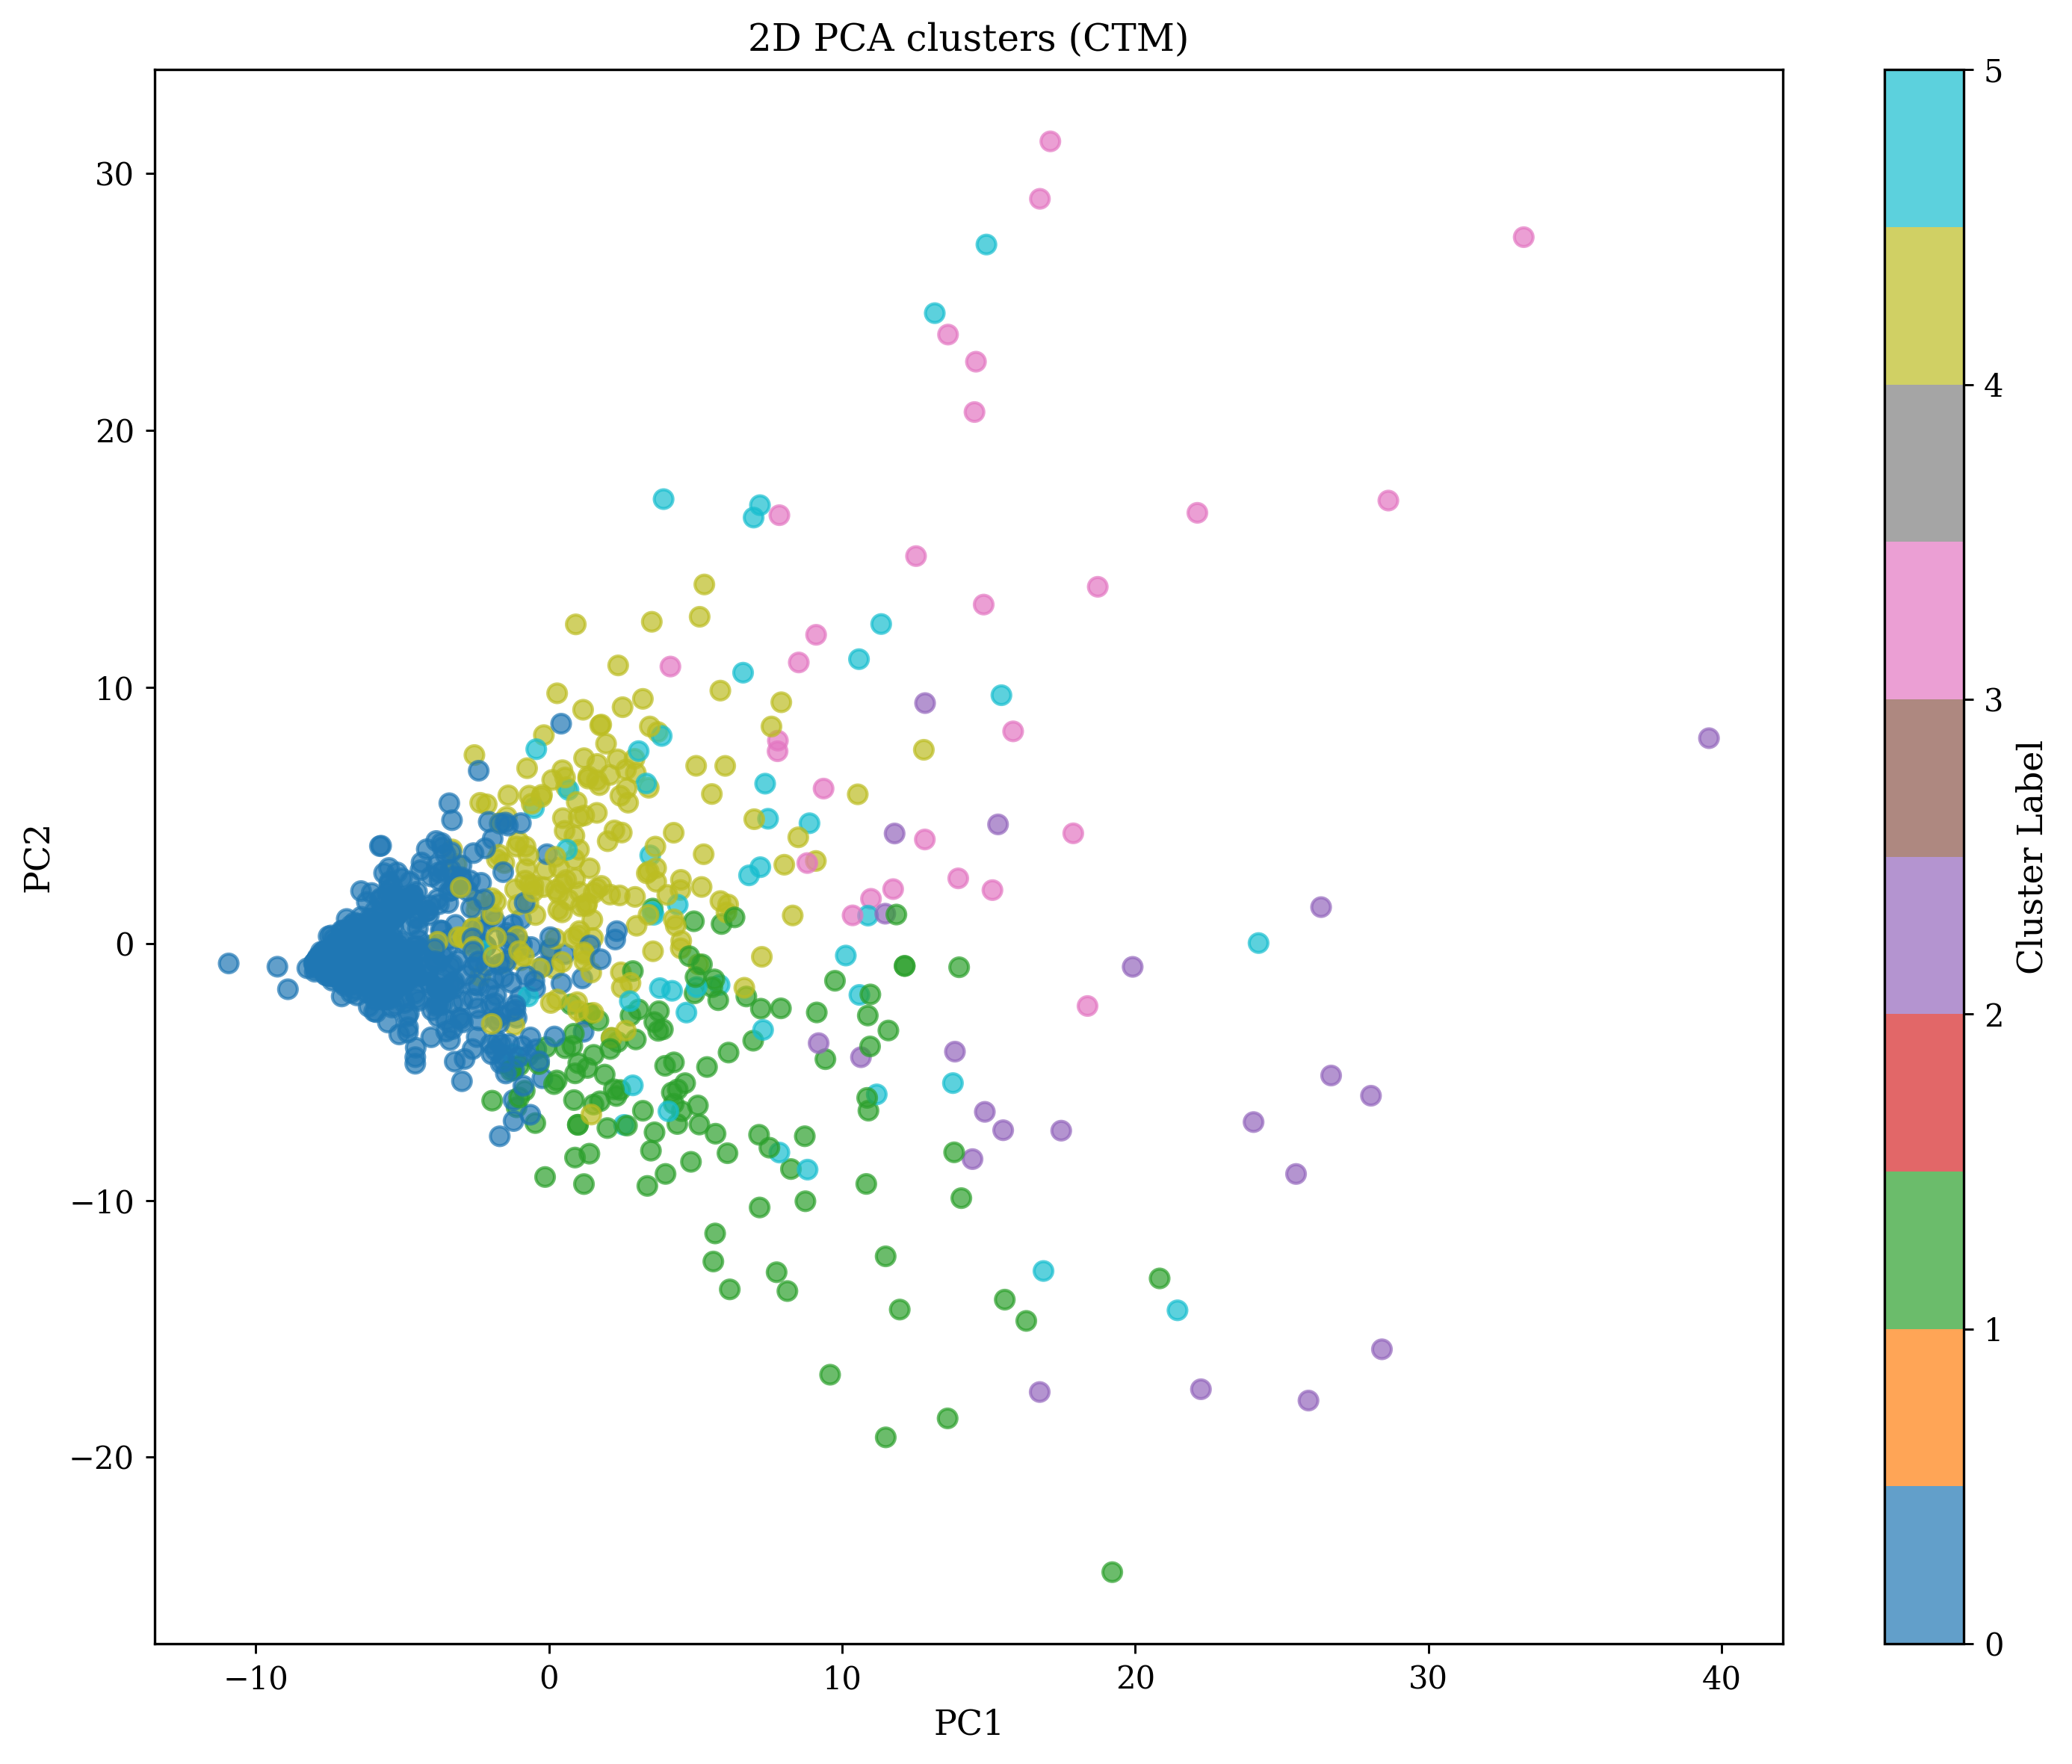

In [11]:
from sklearn.cluster import KMeans

_ = plot_clusters(
    preprocessed_ctms_df,
    n_components=30,
    model=KMeans(n_clusters=k, random_state=42),
    dim=2,
    save=False
)

2025-12-03 01:33:51.224 | INFO     | scripts.ctms_general:preprocess_ctms:99 - CTMs: PCA -> 1007 dims (≥90% variance)
2025-12-03 01:33:52.267 | INFO     | scripts.ctms_general:preprocess_ctms:109 - Removed 124 outliers (Mahalanobis, χ² threshold=59.70)


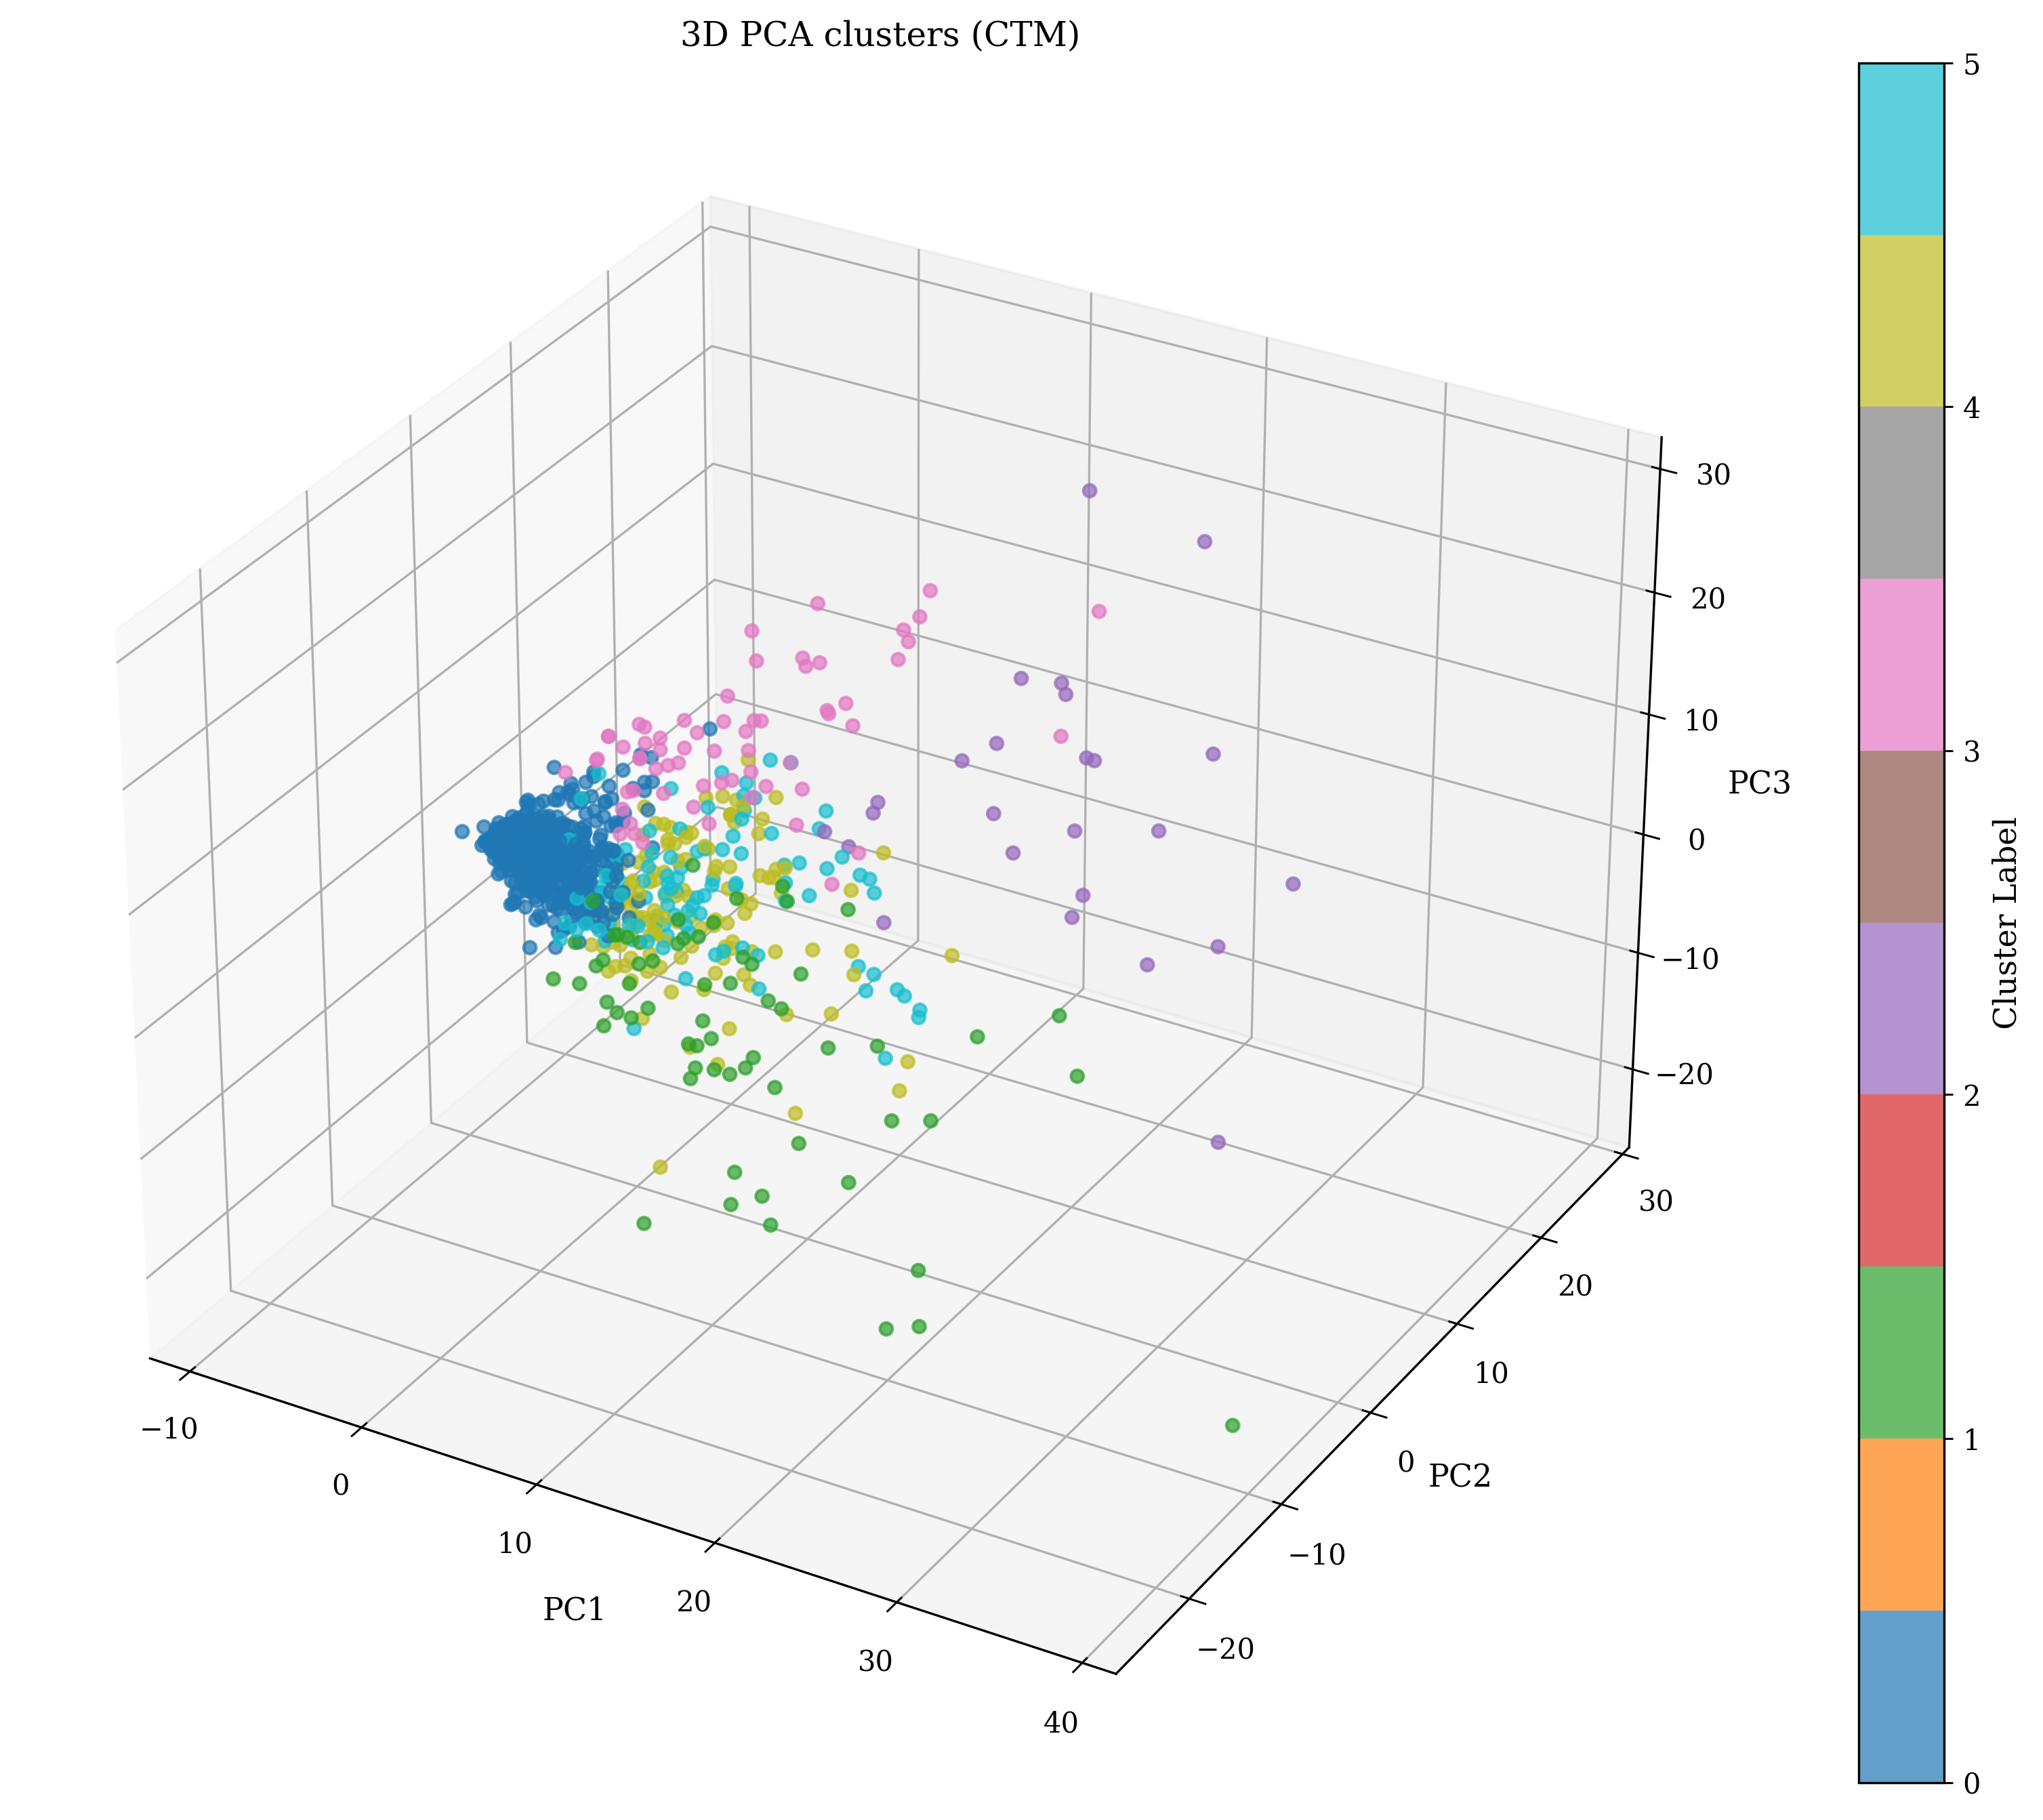

In [12]:
_ = plot_clusters(
    preprocessed_ctms_df,
    n_components=30,
    model=KMeans(n_clusters=k, random_state=42),
    dim=3,
    save=False
)

Visually not encouraging - expected from the CTM representation. Regardless, let's check out the clusters some more.

In [13]:
model = KMeans(n_clusters=k, random_state=42)
preprocessed_ctms_df['cluster_label'] = model.fit_predict(X_pca)


In [17]:
from utils.tf_idf import tfidf_cluster_summary

tf_idf = tfidf_cluster_summary(
    preprocessed_ctms_df
)
tf_idf

{0: ['zelda',
  'nintendo',
  'legend zelda',
  'legend',
  'group nintendo',
  'ead software',
  'zelda motion',
  'imagica',
  'twilight princess',
  'digitalscape',
  'nintendo imagica',
  'fantasy zelda',
  'imagica digitalscape',
  'zelda twilight',
  'twilight',
  'princess action',
  'software development',
  'development group',
  'group',
  'nintendo ead'],
 3: ['sonic',
  'square',
  'enix',
  'square enix',
  'sonic team',
  'sega',
  'sonic adventure',
  'racing',
  'super',
  'team',
  'division',
  'sega sonic',
  'anti gravity',
  'gravity racing',
  'special',
  'mascot',
  'distribution sega',
  'action digital',
  'hidden',
  'adventure action'],
 2: ['sonic',
  'action digital',
  'distribution sega',
  'adventure action',
  'sega sonic',
  'sonic adventure',
  'sonic team',
  'castlevania',
  'horror konami',
  'man',
  'superscape',
  'superscape disney',
  'cast',
  'disney mobile',
  'action cast',
  'cast superscape',
  'team',
  'hearts action',
  'sega',
  'me

In [ ]:
from utils.metrics import column_wise_summary

column_metrics = column_wise_summary(
    preprocessed_ctms_df,
    columns = ["name", "themes", "keywords", "involved_companies", "first_release_year"]
)

In [ ]:
def plot_metadata_distributions(data, top_n=10):
    """
    Plot distributions for metadata categories from a JSON-like dict.
    For each category, creates a single figure with subplots showing each cluster 
    compared to the global distribution, using tab10 color scheme.

    Expected structure:
    {
      "0": {
          "name": {"counts": {...}},
          "themes": {"counts": {...}},
          "keywords": {"counts": {...}},
          "involved_companies": {"counts": {...}},
          "first_release_year": {"counts": {...}}
      },
      "1": {...},  # optionally more clusters
    }

    Parameters
    ----------
    data : dict
        Parsed JSON dictionary.
    top_n : int
        Number of top values to plot for categorical variables.
    """
    import matplotlib.pyplot as plt
    from matplotlib import cm
    
    # Get tab10 colormap
    tab10 = cm.get_cmap('tab10')
    
    cluster_sizes = {id: data[id].get('cluster_size', 0) for id in data}
    cluster_ids = sorted(data.keys(), key=lambda x: int(x))
    n_clusters = len(cluster_ids)
    
    # Collect all categories (excluding cluster_size)
    categories = set()
    for cluster_dict in data.values():
        for key in cluster_dict.keys():
            if key != "cluster_size" and "counts" in cluster_dict.get(key, {}):
                categories.add(key)
    
    # Compute global distributions for each category
    global_distributions = {}
    for category in categories:
        global_dist = {}
        for cluster_id in cluster_ids:
            cluster_dict = data[cluster_id]
            if category in cluster_dict and "counts" in cluster_dict[category]:
                counts = cluster_dict[category]["counts"]
                for item, count in counts.items():
                    global_dist[item] = global_dist.get(item, 0) + count
        global_distributions[category] = global_dist
    
    # Process each category
    for category in sorted(categories):
        print(f"\n=== {category} ===")
        
        # Determine if this is year data
        is_year = category == "first_release_year"
        
        # Create subplot grid (clusters + 1 for global)
        n_plots = n_clusters + 1
        n_cols = min(3, n_plots)
        n_rows = (n_plots + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 4*n_rows))
        if n_plots == 1:
            axes = [axes]
        else:
            axes = axes.flatten() if n_rows > 1 else list(axes)
        
        # Plot global distribution first
        ax = axes[0]
        global_counts = global_distributions[category]
        
        if is_year:
            # Year histogram
            years = []
            freqs = []
            for k, v in global_counts.items():
                try:
                    years.append(int(k))
                    freqs.append(v)
                except ValueError:
                    continue
            
            if years:
                sorted_data = sorted(zip(years, freqs))
                years, freqs = zip(*sorted_data)
                ax.bar(years, freqs, color='gray', alpha=0.7)
                ax.set_title(f"Global: {category}", fontweight='bold')
                ax.set_xlabel("Year")
                ax.set_ylabel("Count")
        else:
            # Categorical bar chart
            sorted_items = sorted(global_counts.items(), key=lambda x: x[1], reverse=True)[:top_n]
            labels = [x[0] for x in sorted_items]
            values = [x[1] for x in sorted_items]
            
            if labels:
                ax.barh(labels, values, color='gray', alpha=0.7)
                ax.invert_yaxis()
                ax.set_title(f"Global: {category}", fontweight='bold')
                ax.set_xlabel("Count")
        
        # Plot each cluster
        for idx, cluster_id in enumerate(cluster_ids):
            ax = axes[idx + 1]
            cluster_dict = data[cluster_id]
            
            if category not in cluster_dict or "counts" not in cluster_dict[category]:
                ax.axis('off')
                continue
            
            counts = cluster_dict[category]["counts"]
            
            if not counts:
                ax.axis('off')
                continue
            
            # Get cluster color from tab10
            color = tab10(int(cluster_id) % 10)
            
            if is_year:
                # Year histogram
                years = []
                freqs = []
                for k, v in counts.items():
                    try:
                        years.append(int(k))
                        freqs.append(v)
                    except ValueError:
                        continue
                
                if years:
                    sorted_data = sorted(zip(years, freqs))
                    years, freqs = zip(*sorted_data)
                    ax.bar(years, freqs, color=color, alpha=0.7)
                    ax.set_title(f"Cluster {cluster_id} (n={cluster_sizes[cluster_id]})", fontweight='bold')
                    ax.set_xlabel("Year")
                    ax.set_ylabel("Count")
            else:
                # Categorical bar chart
                sorted_items = sorted(counts.items(), key=lambda x: x[1], reverse=True)[:top_n]
                labels = [x[0] for x in sorted_items]
                values = [x[1] for x in sorted_items]
                
                if labels:
                    ax.barh(labels, values, color=color, alpha=0.7)
                    ax.invert_yaxis()
                    ax.set_title(f"Cluster {cluster_id} (n={cluster_sizes[cluster_id]})", fontweight='bold')
                    ax.set_xlabel("Count")
        
        # Hide unused subplots
        for idx in range(n_plots, len(axes)):
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    # Plot cluster sizes as separate figure
    print(f"\n=== Cluster Sizes ===")
    fig, ax = plt.subplots(figsize=(8, 4))
    colors = [tab10(int(cid) % 10) for cid in cluster_ids]
    ax.bar(cluster_ids, [cluster_sizes[cid] for cid in cluster_ids], color=colors, alpha=0.7)
    ax.set_title("Cluster Sizes", fontweight='bold')
    ax.set_xlabel("Cluster ID")
    ax.set_ylabel("Size")
    plt.tight_layout()
    plt.show()


=== Cluster 0 ===


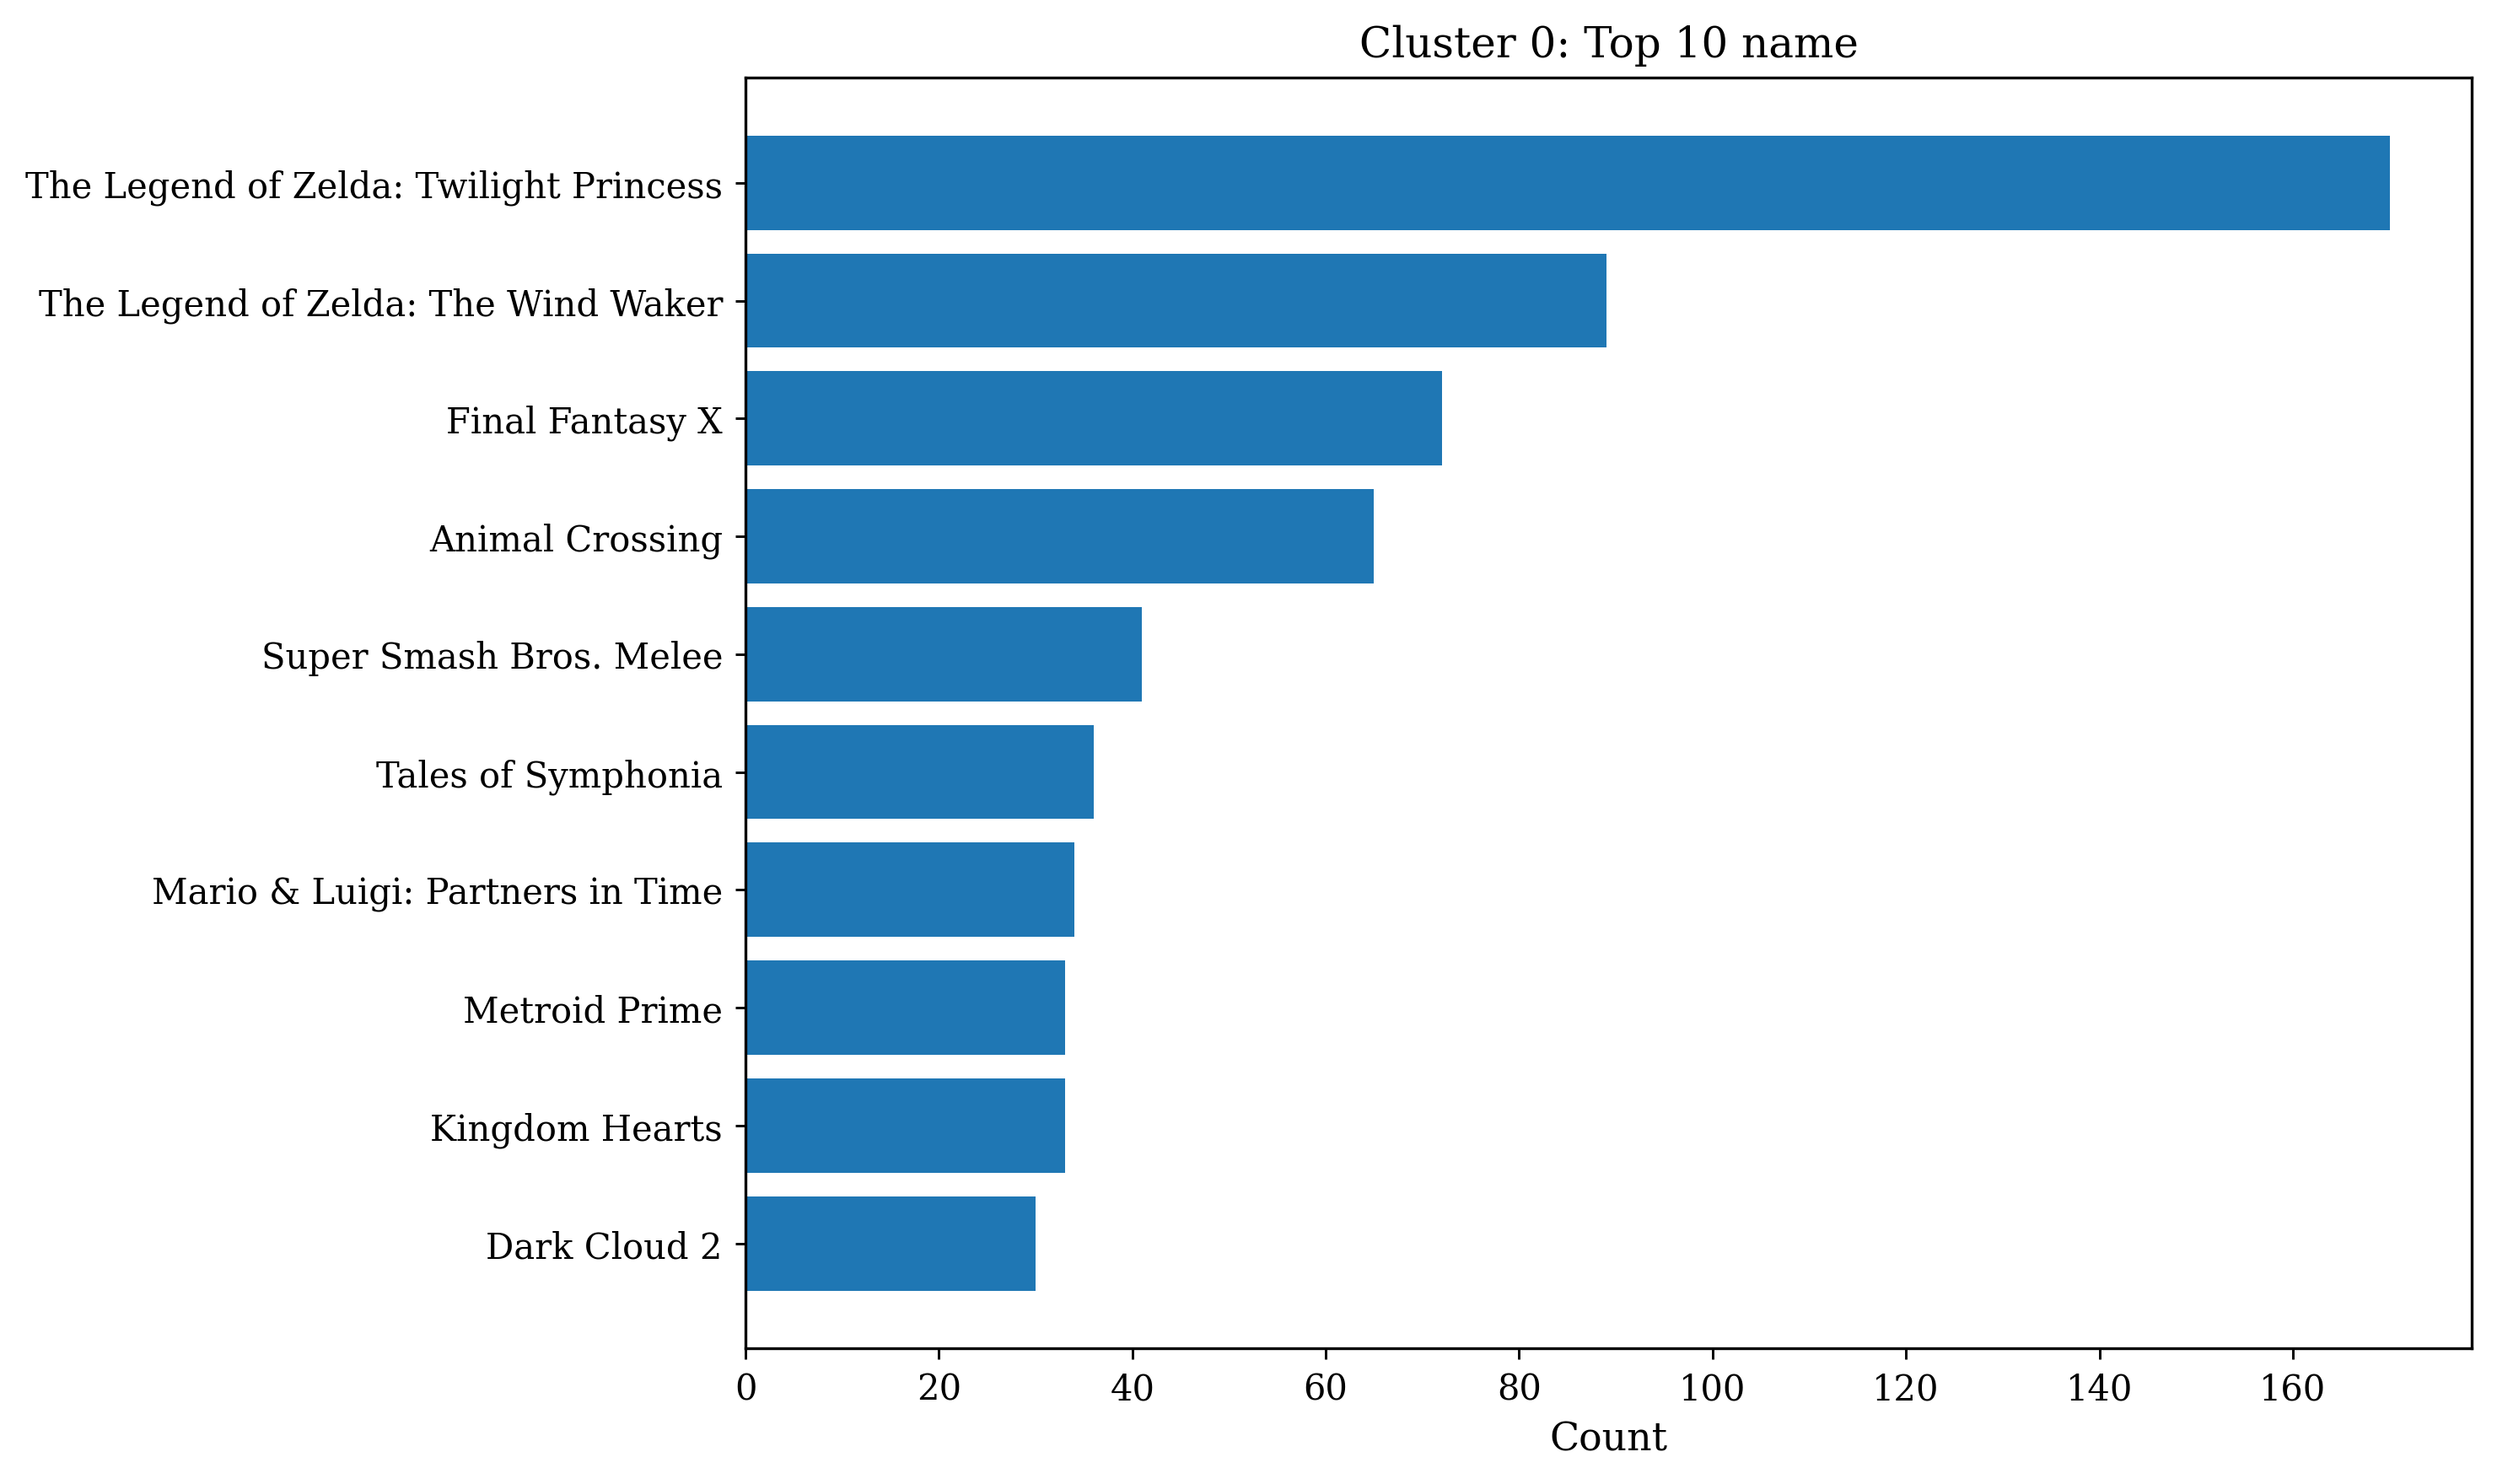

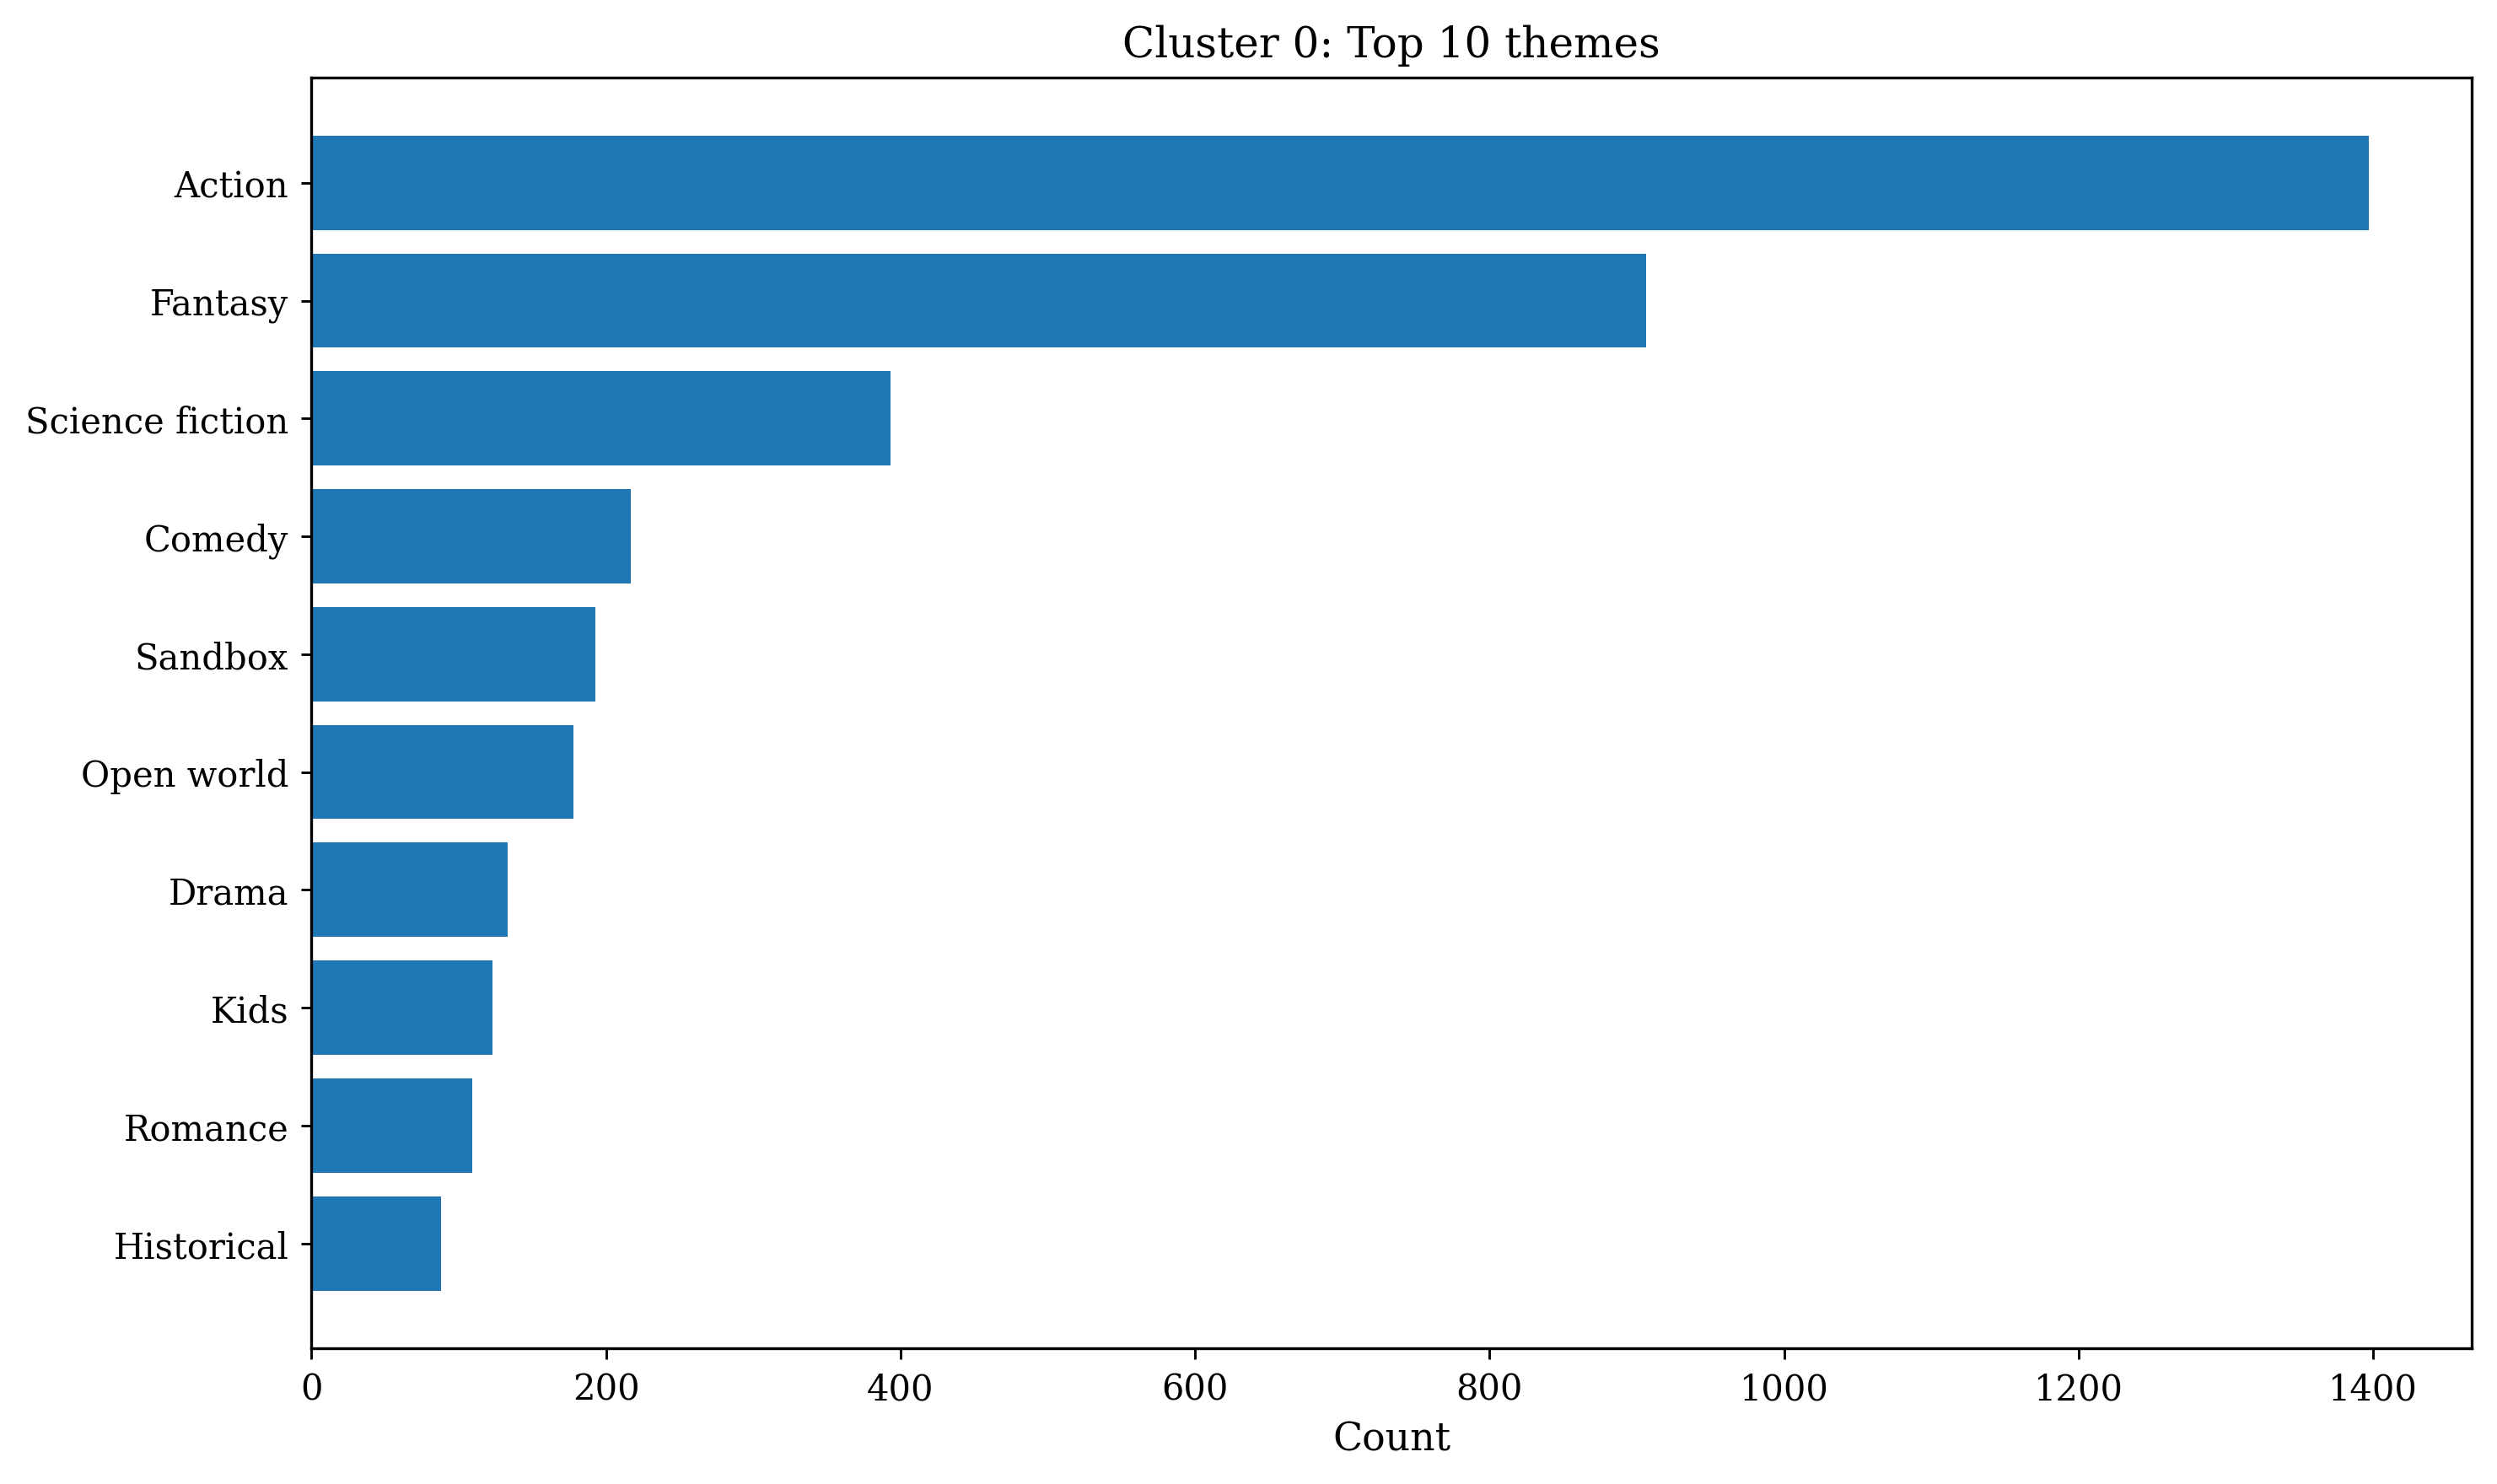

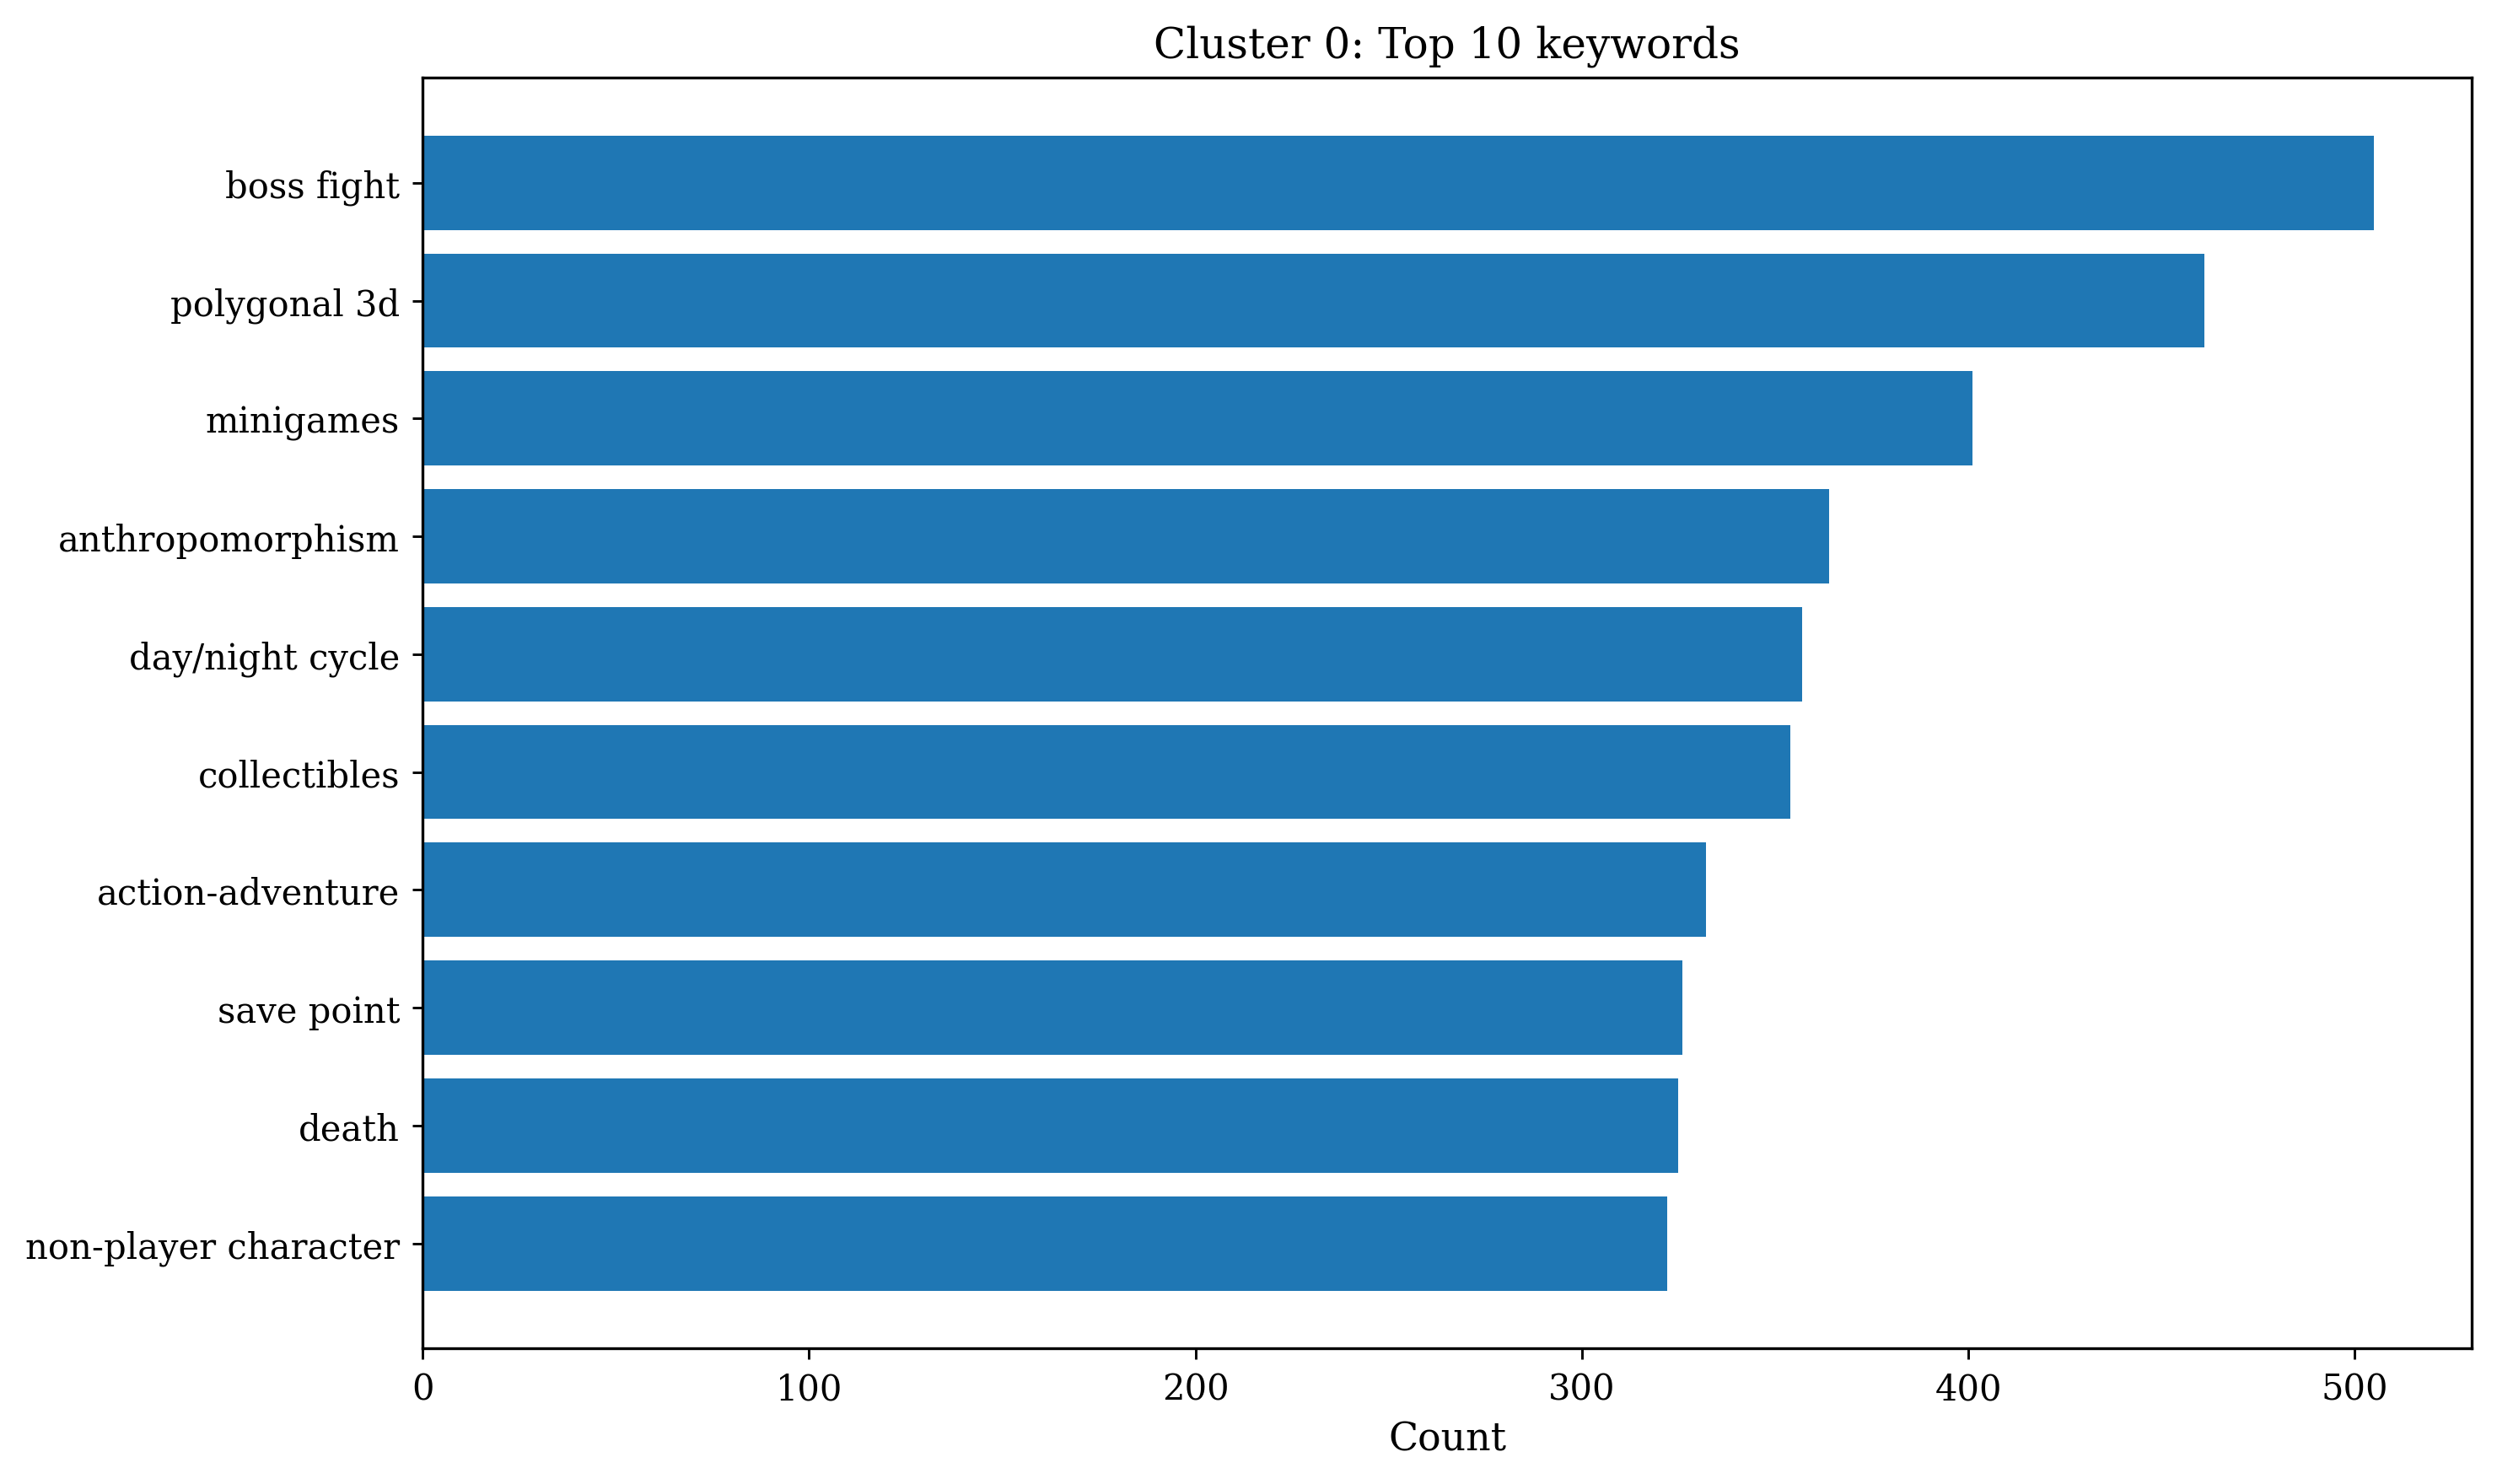

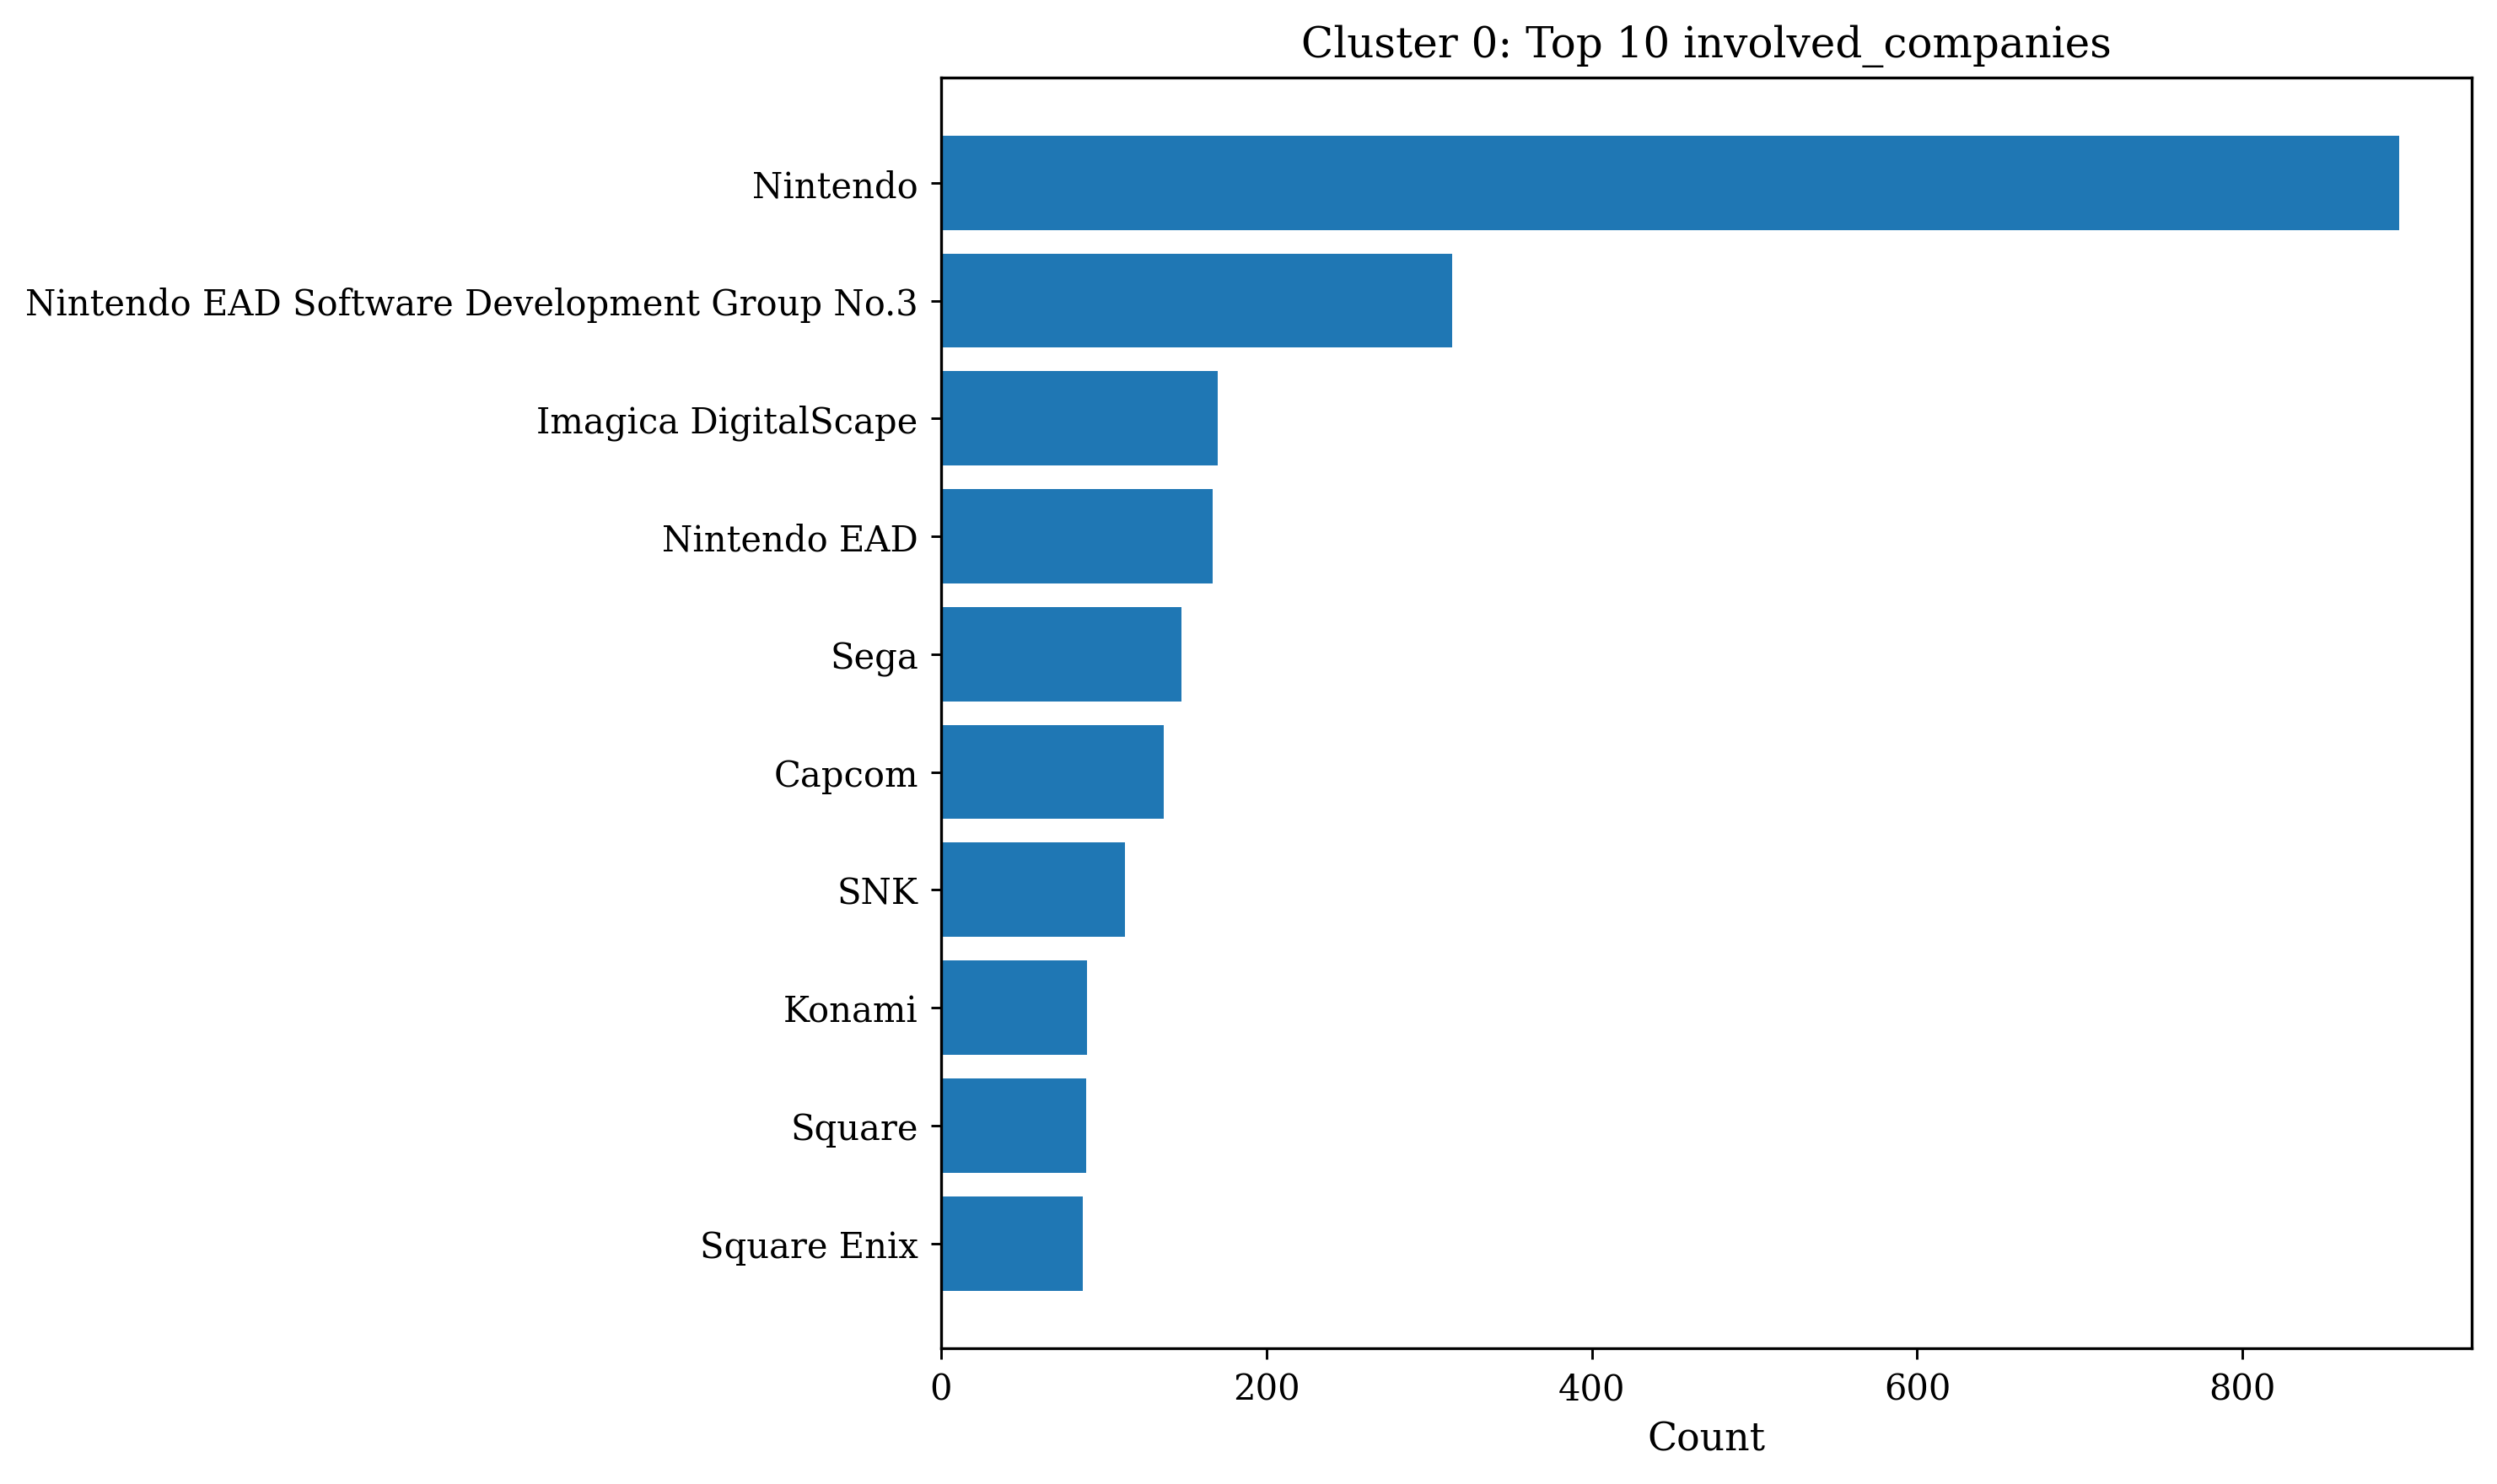

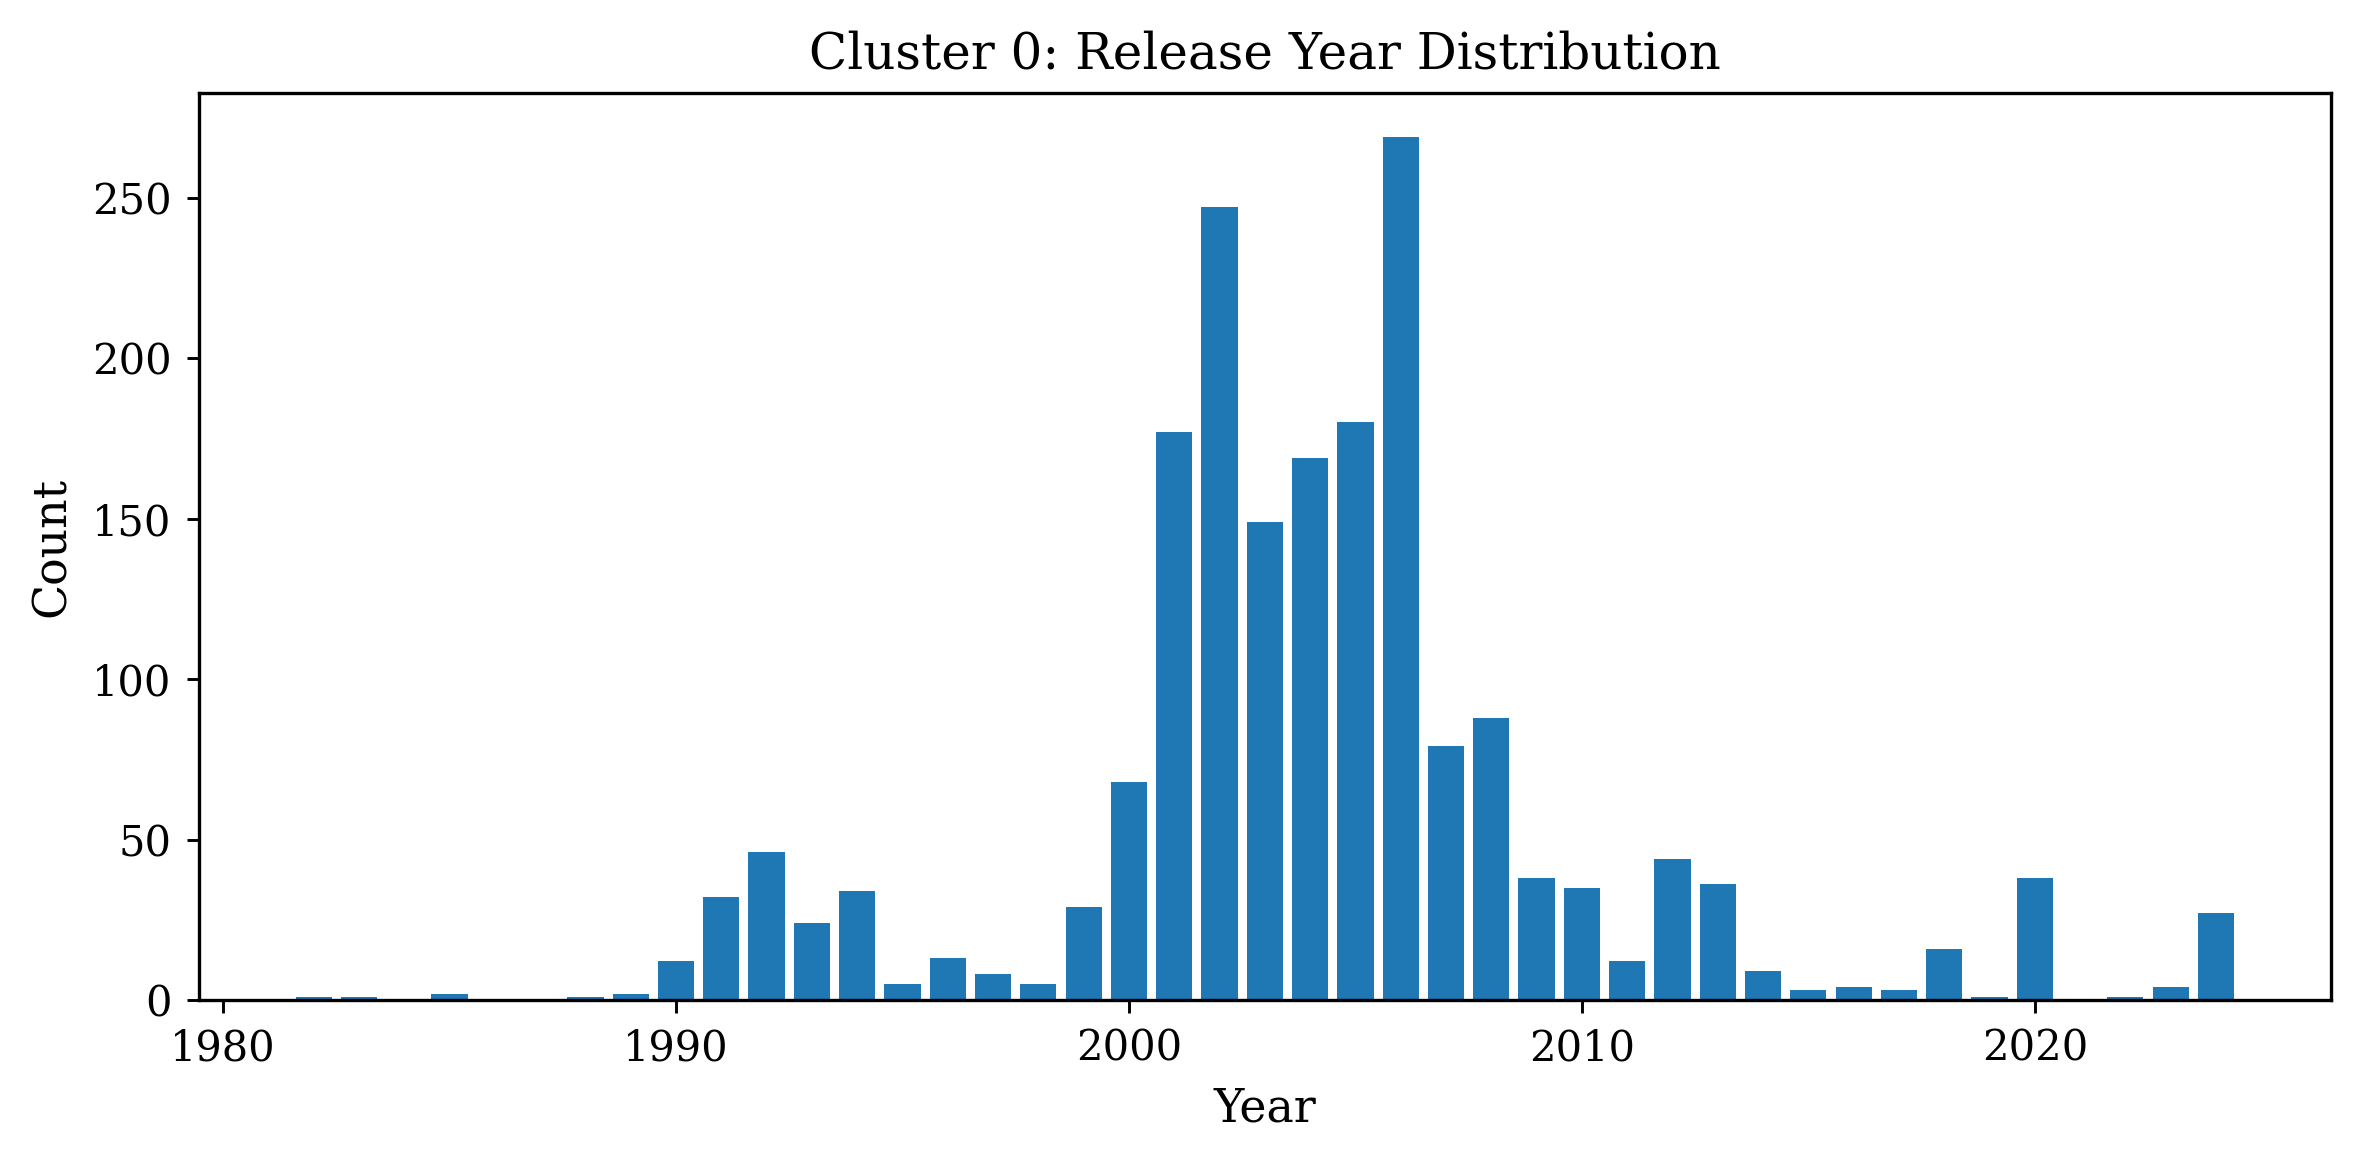


=== Cluster 1 ===


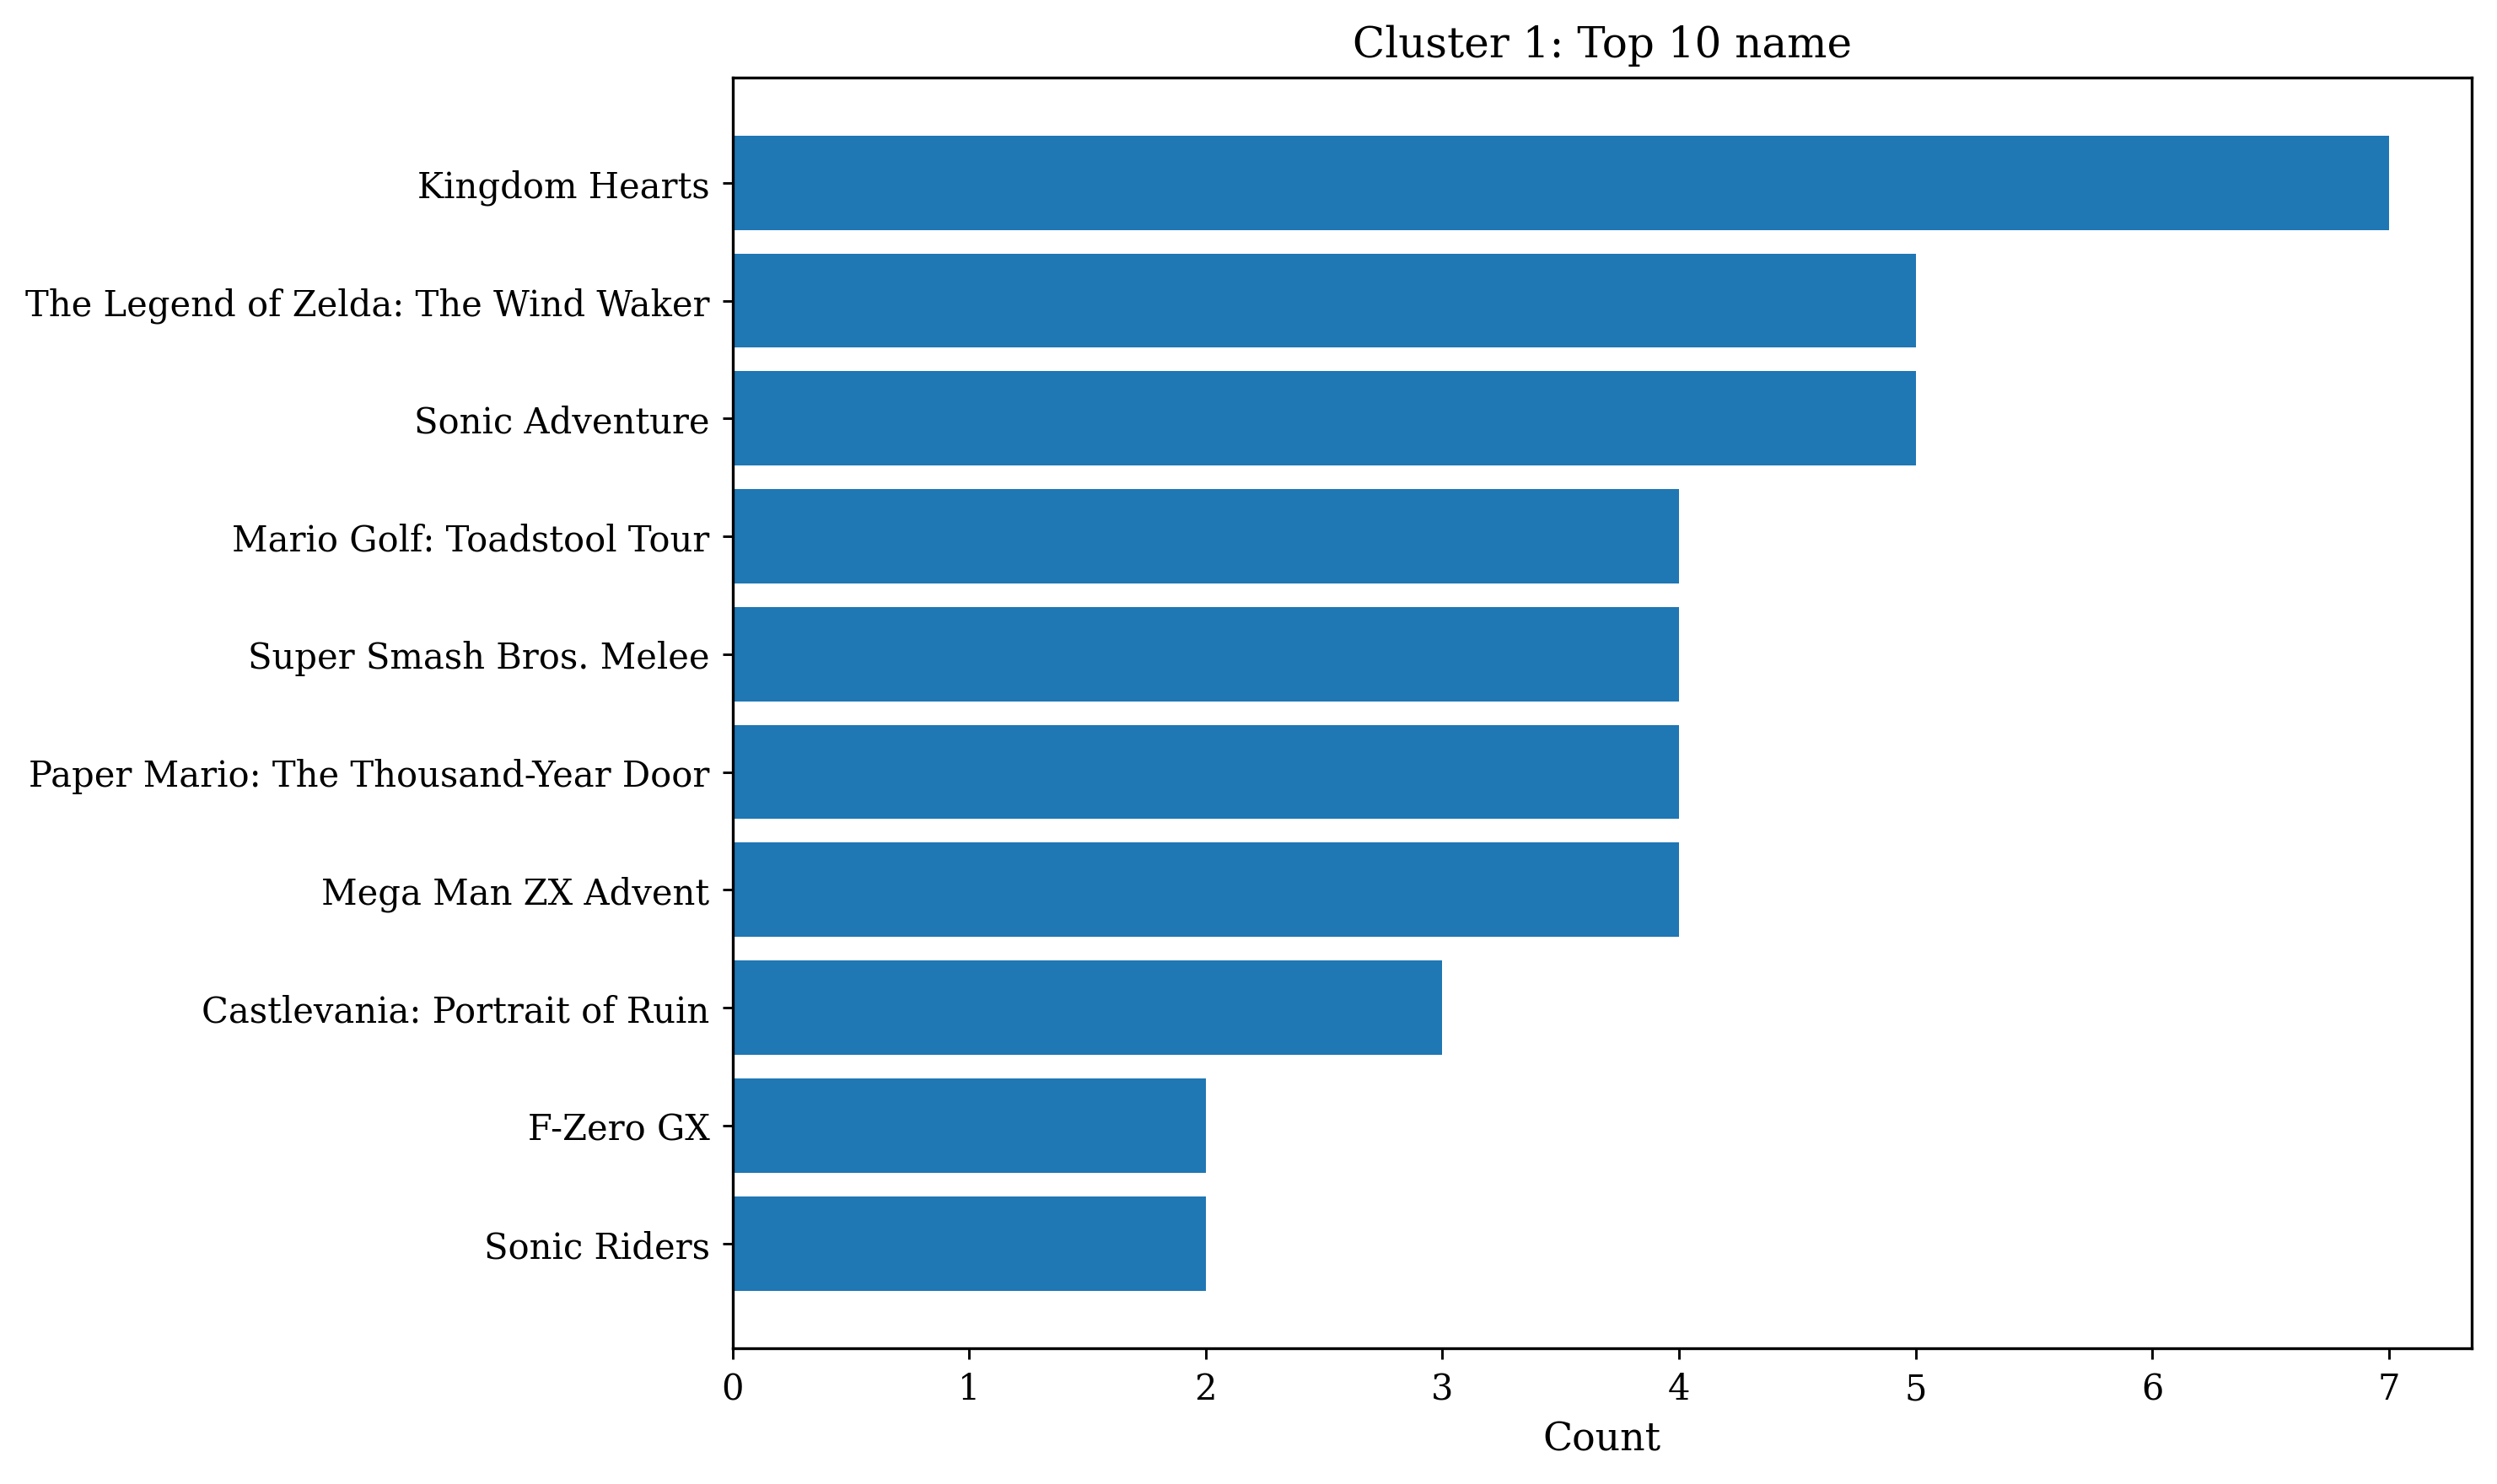

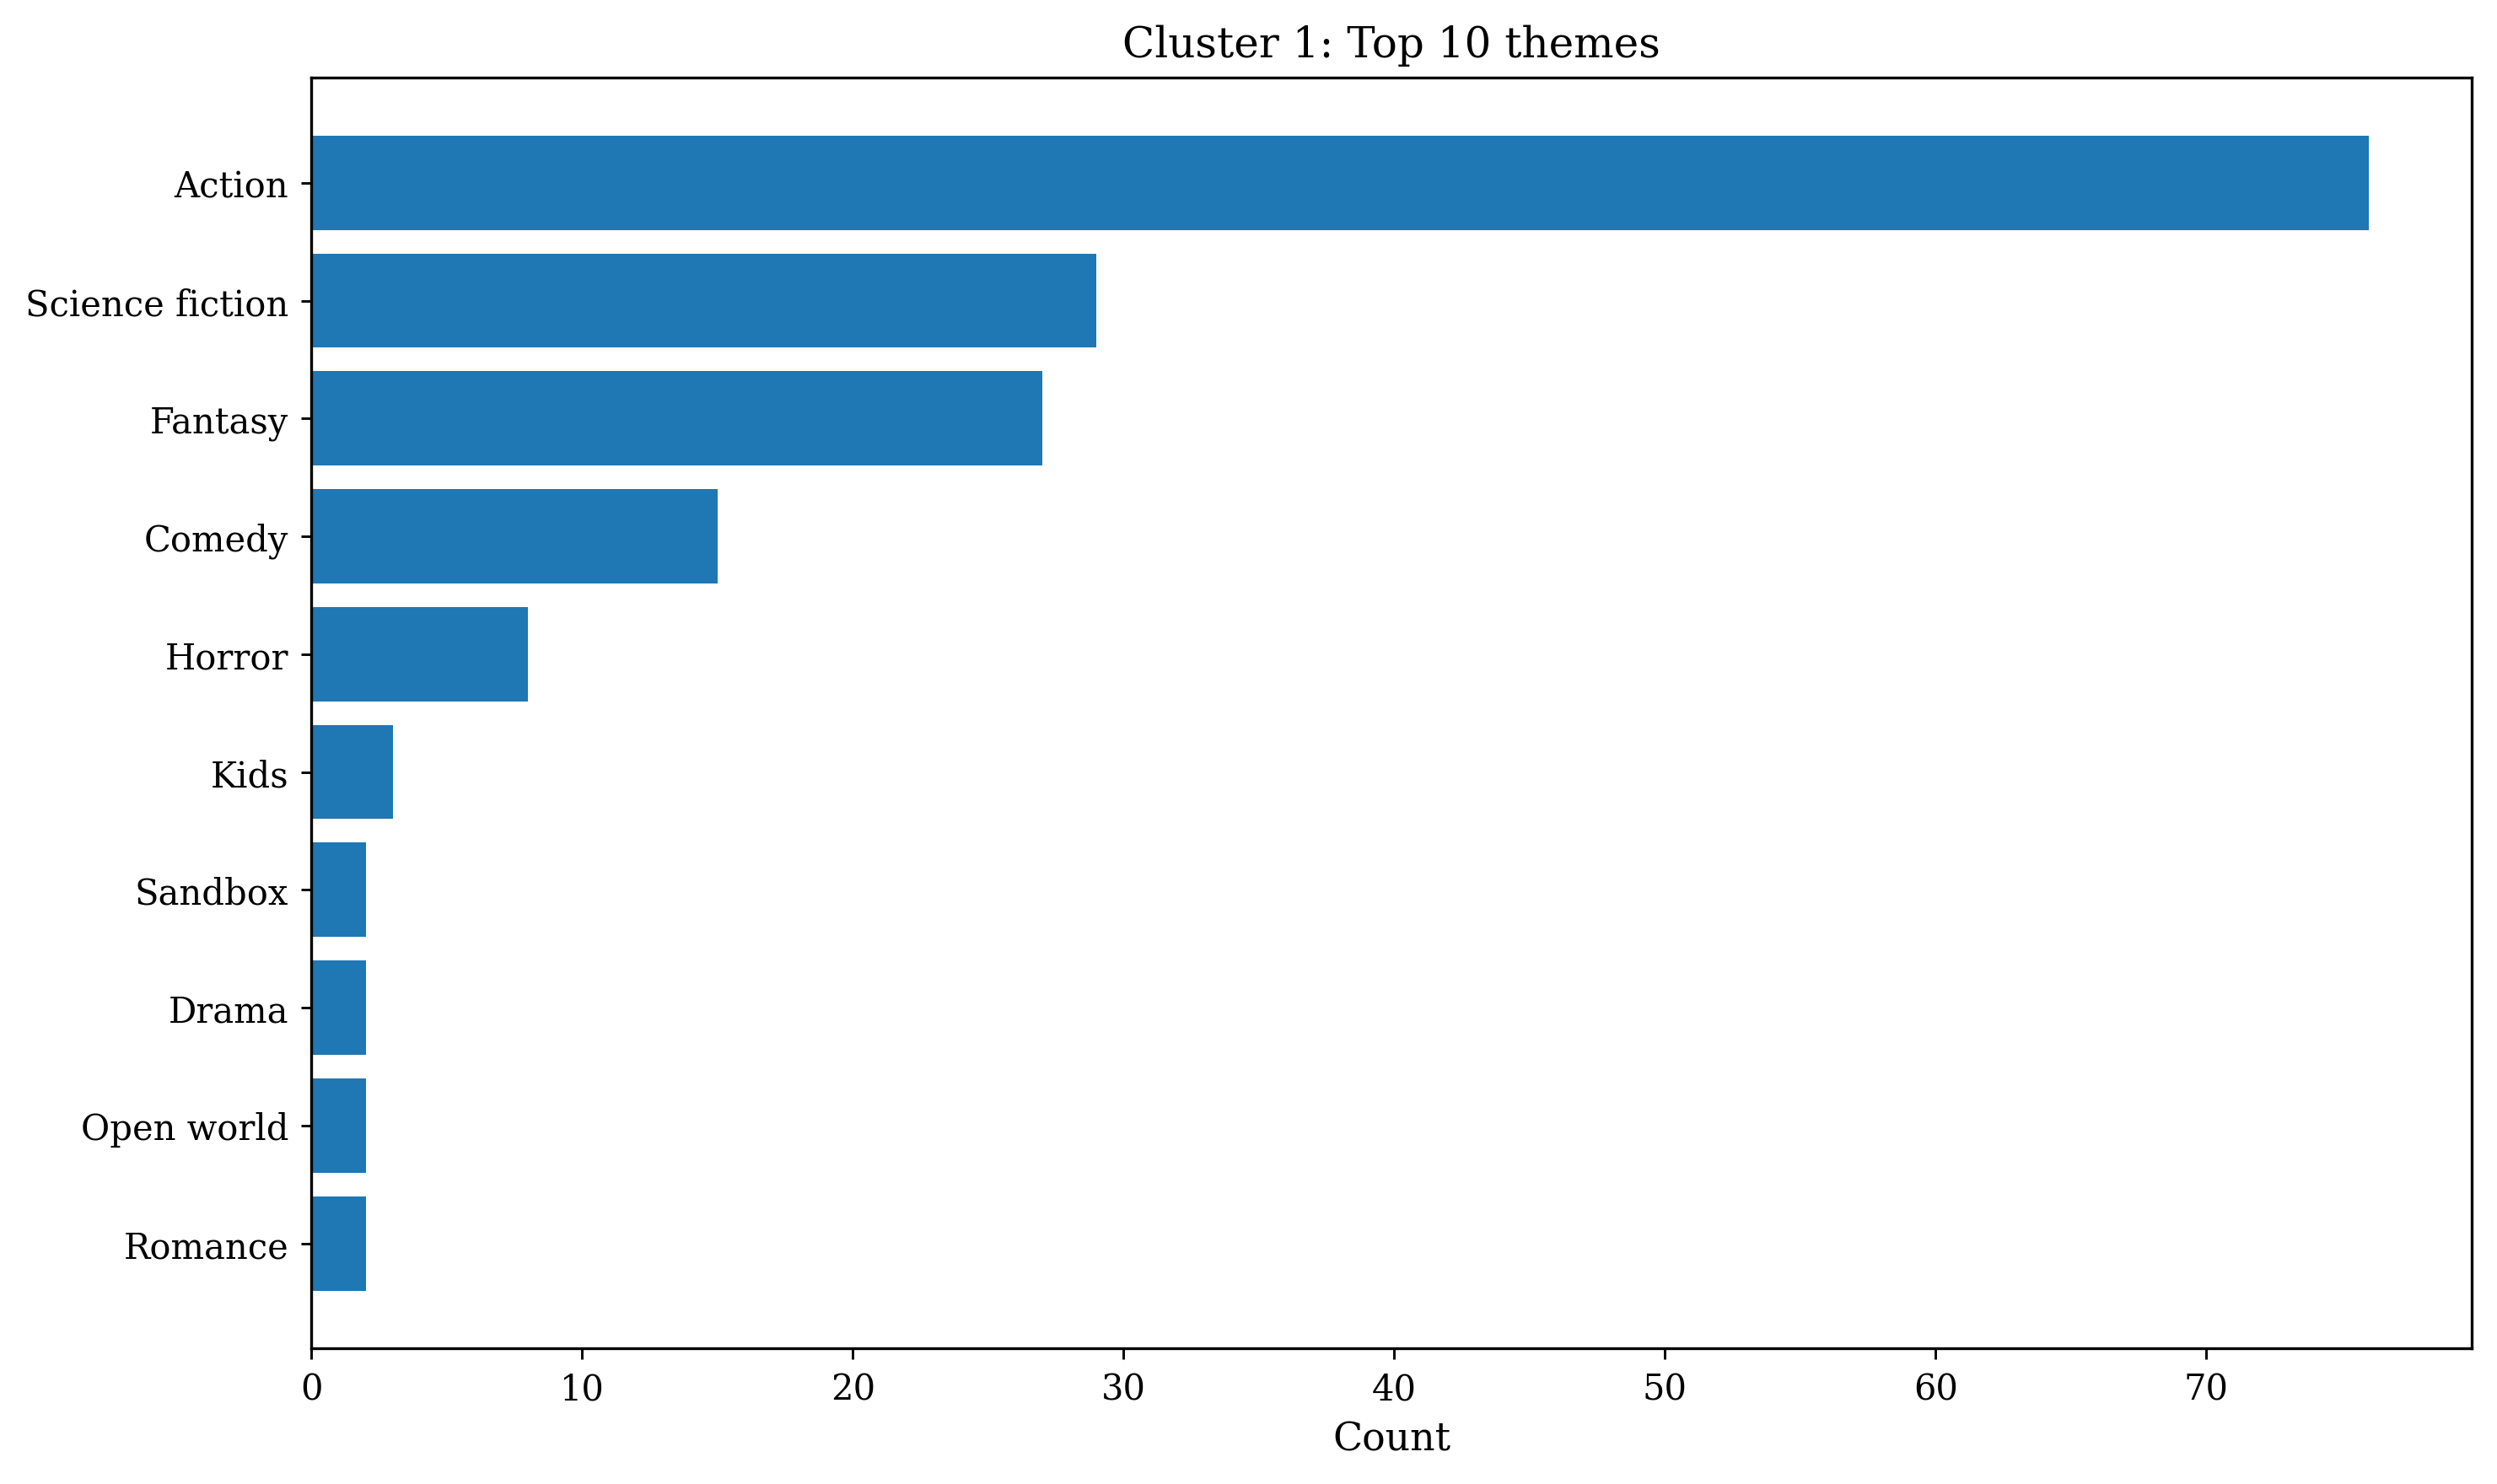

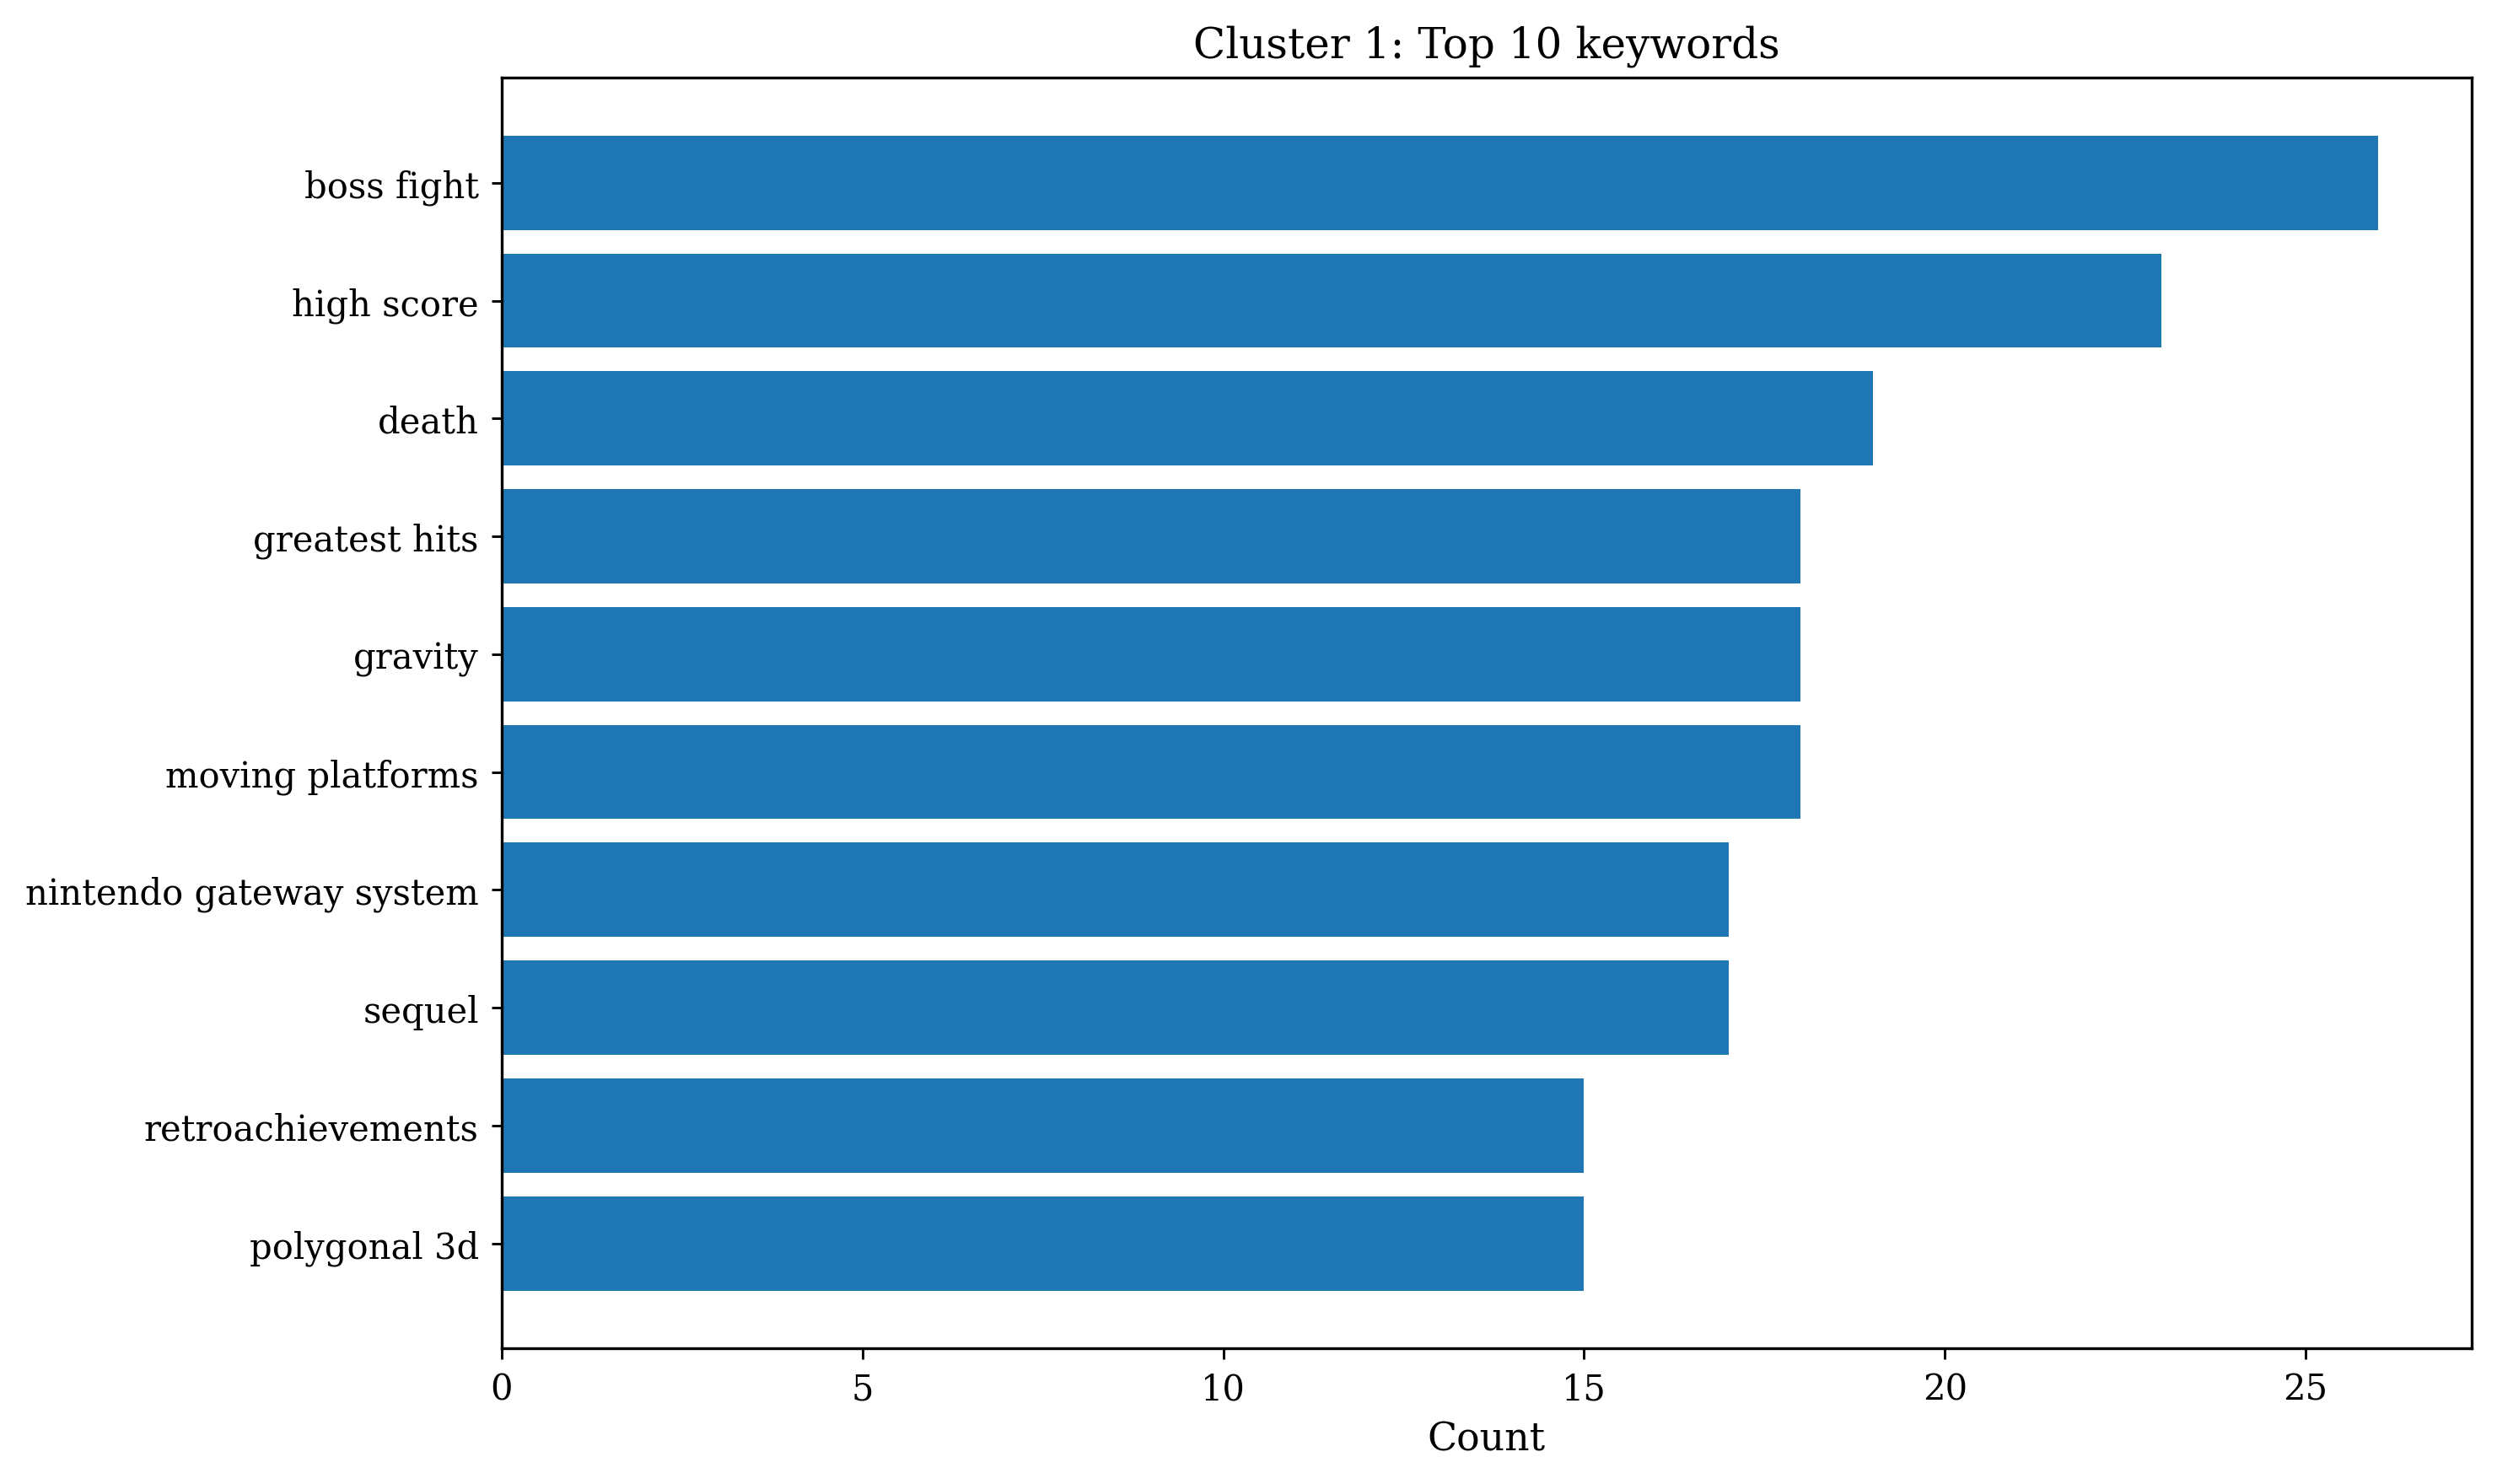

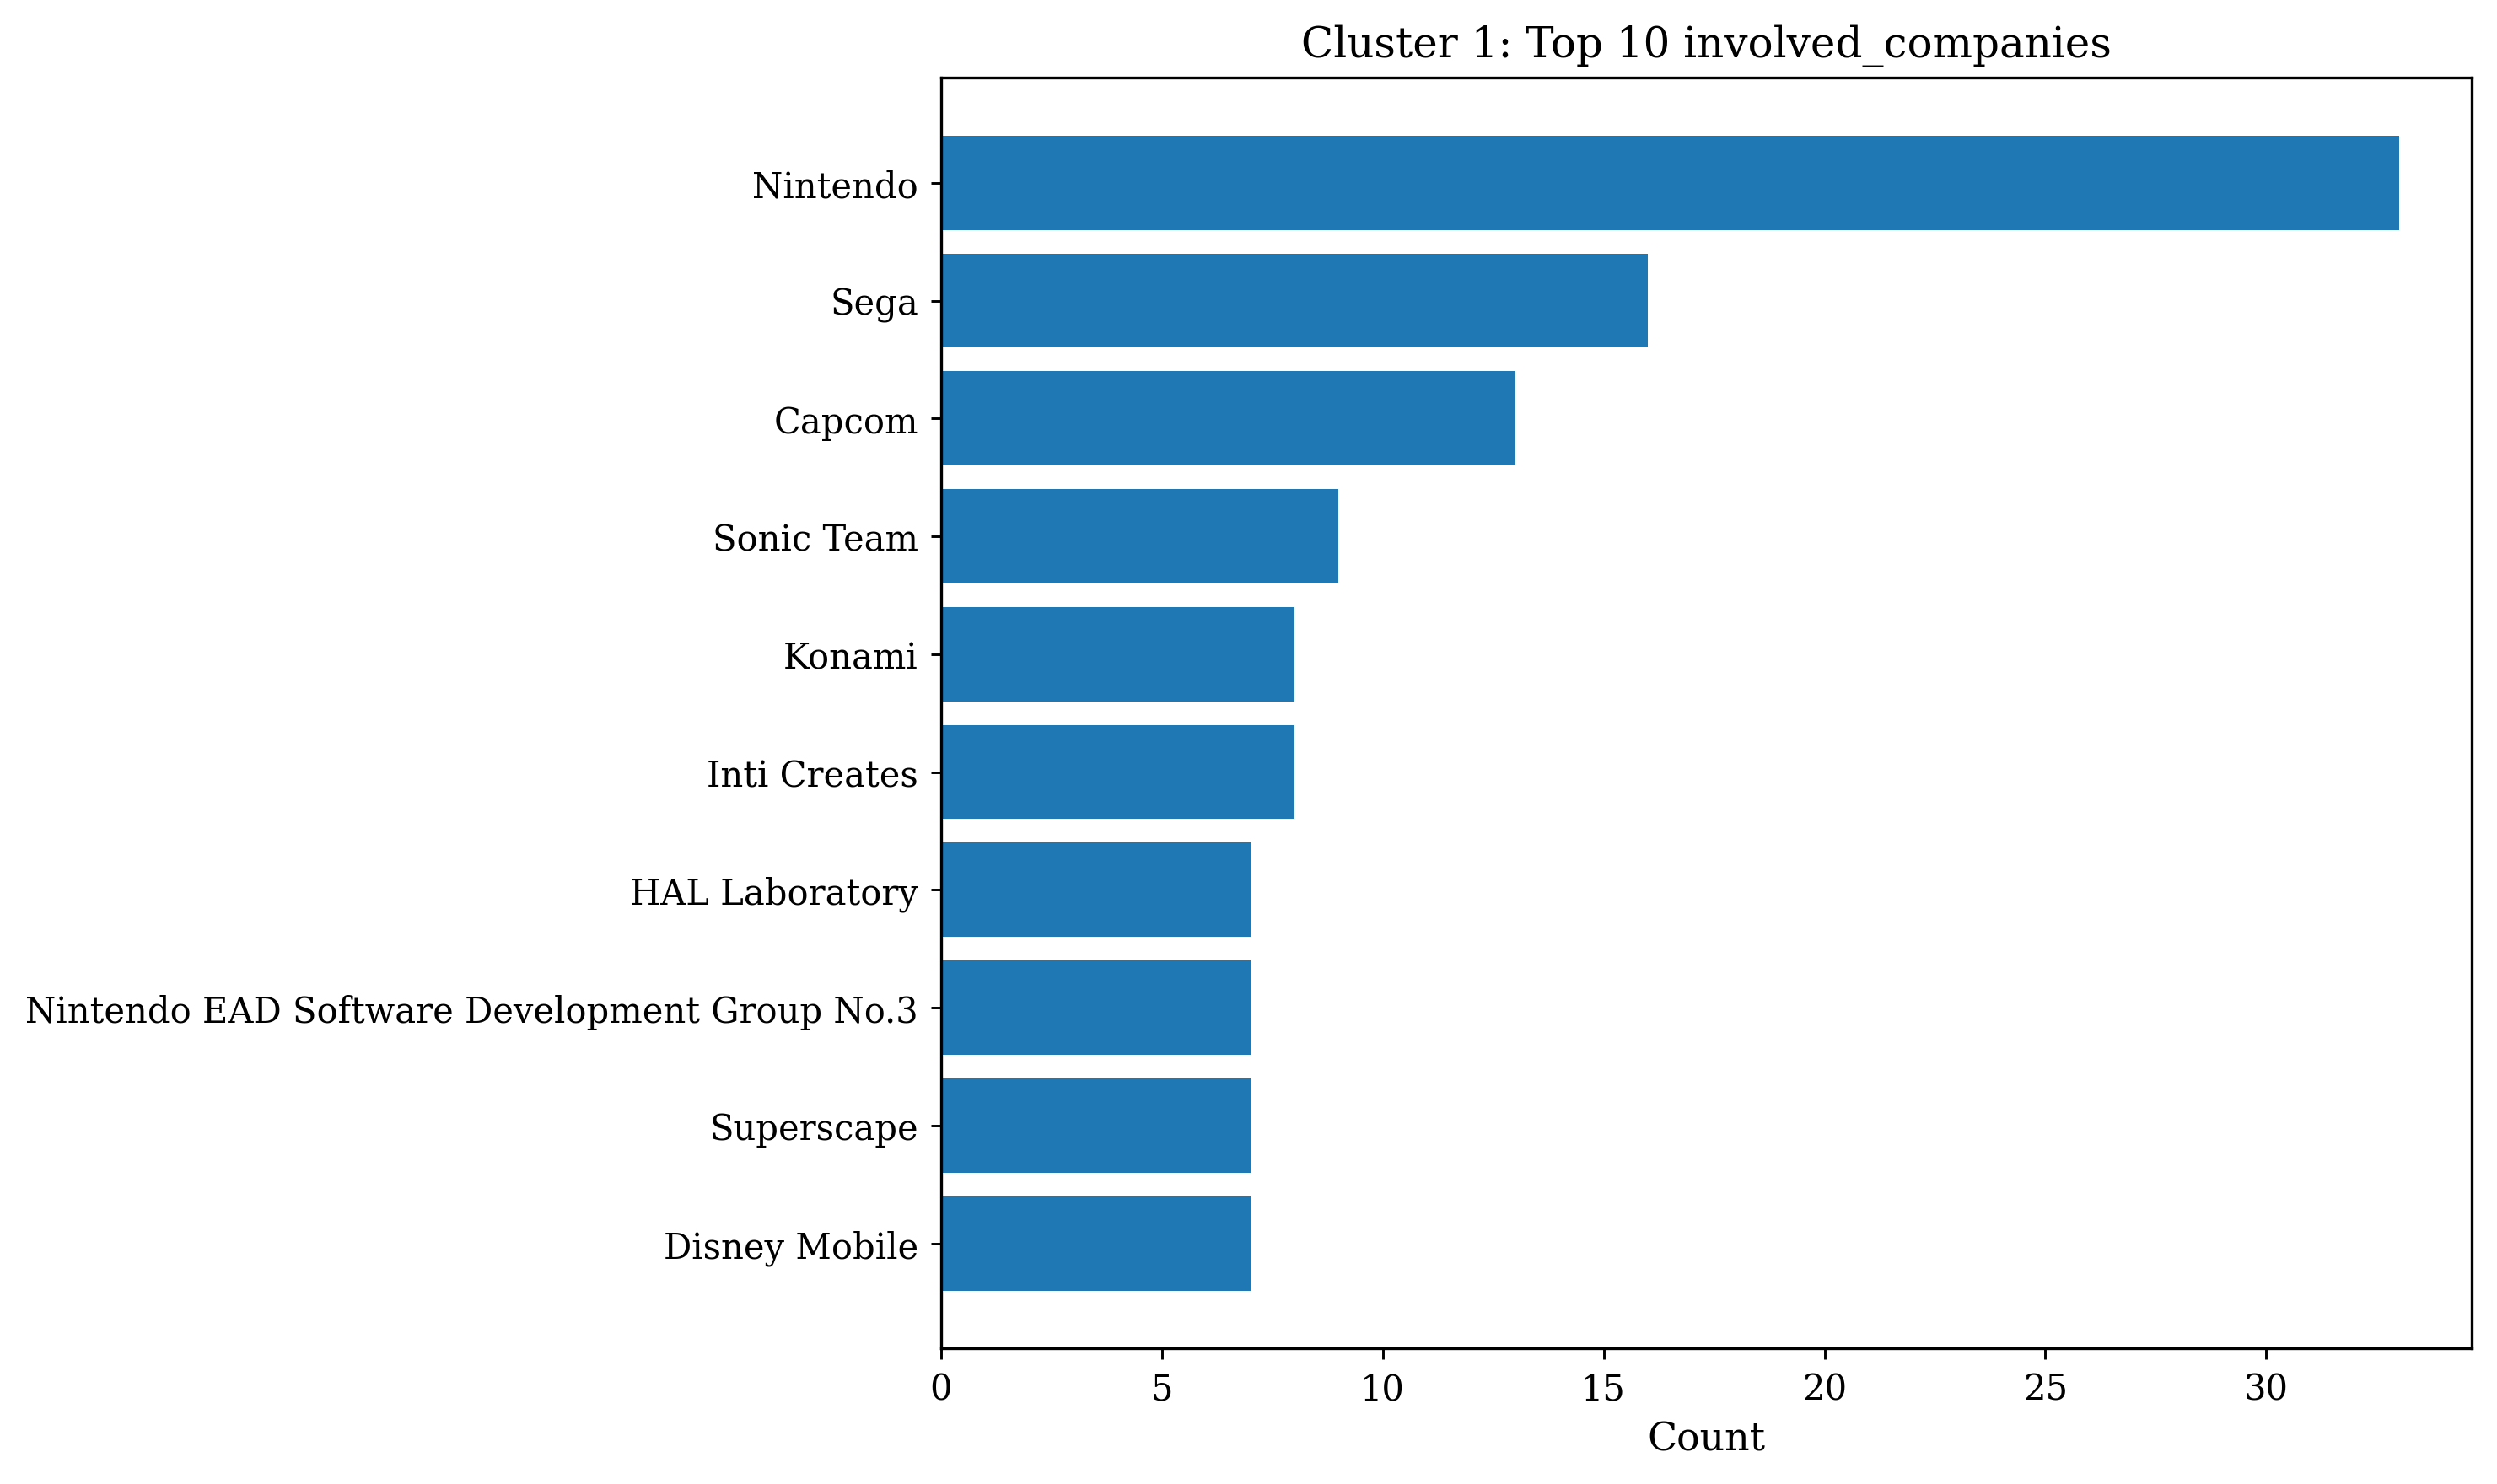

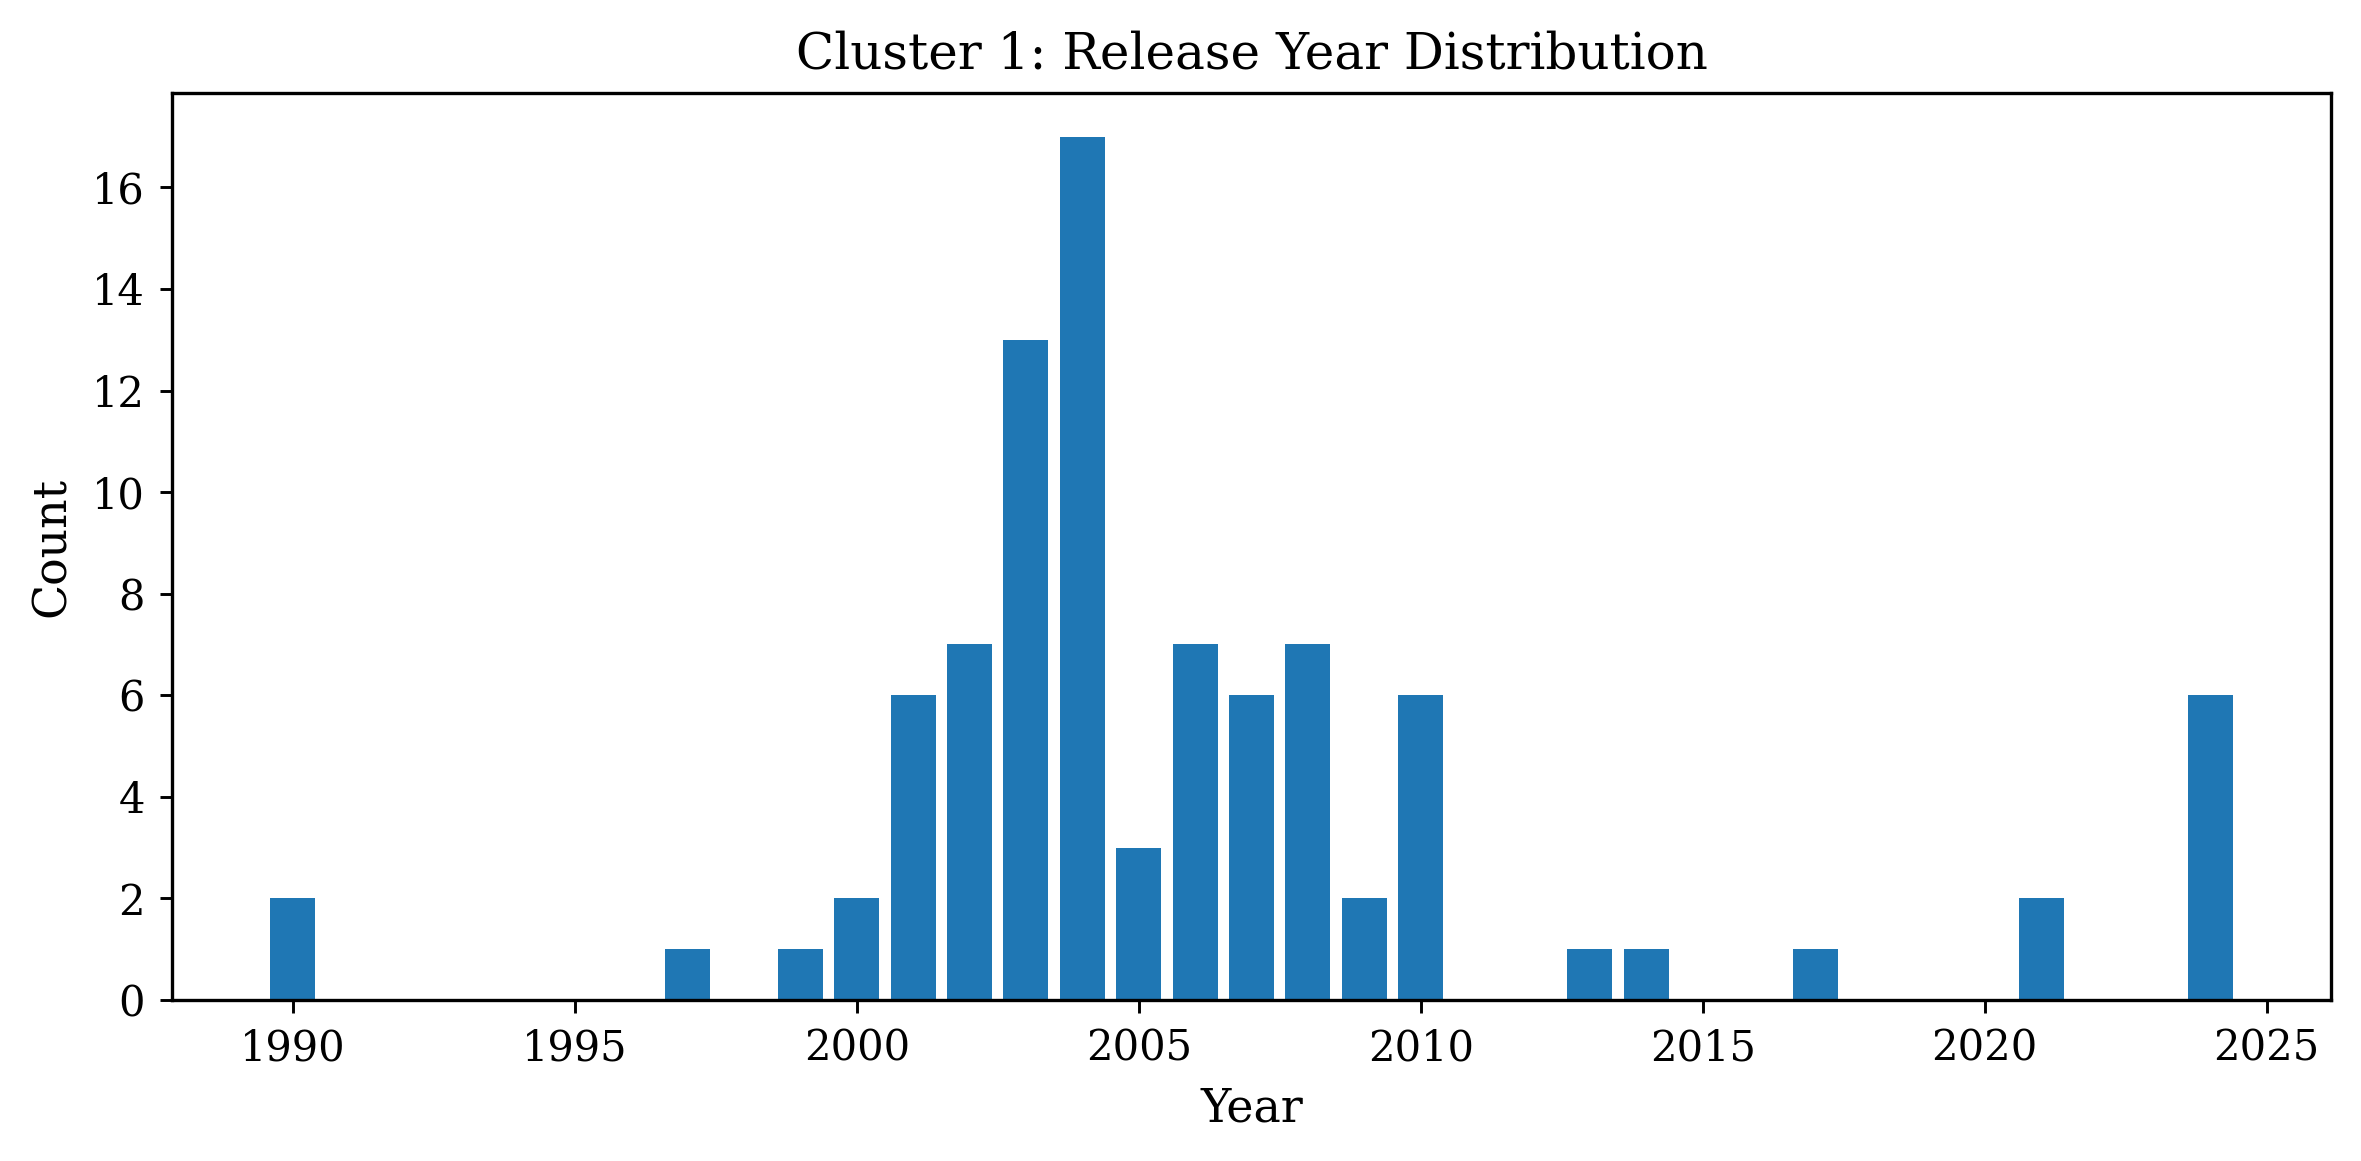


=== Cluster 2 ===


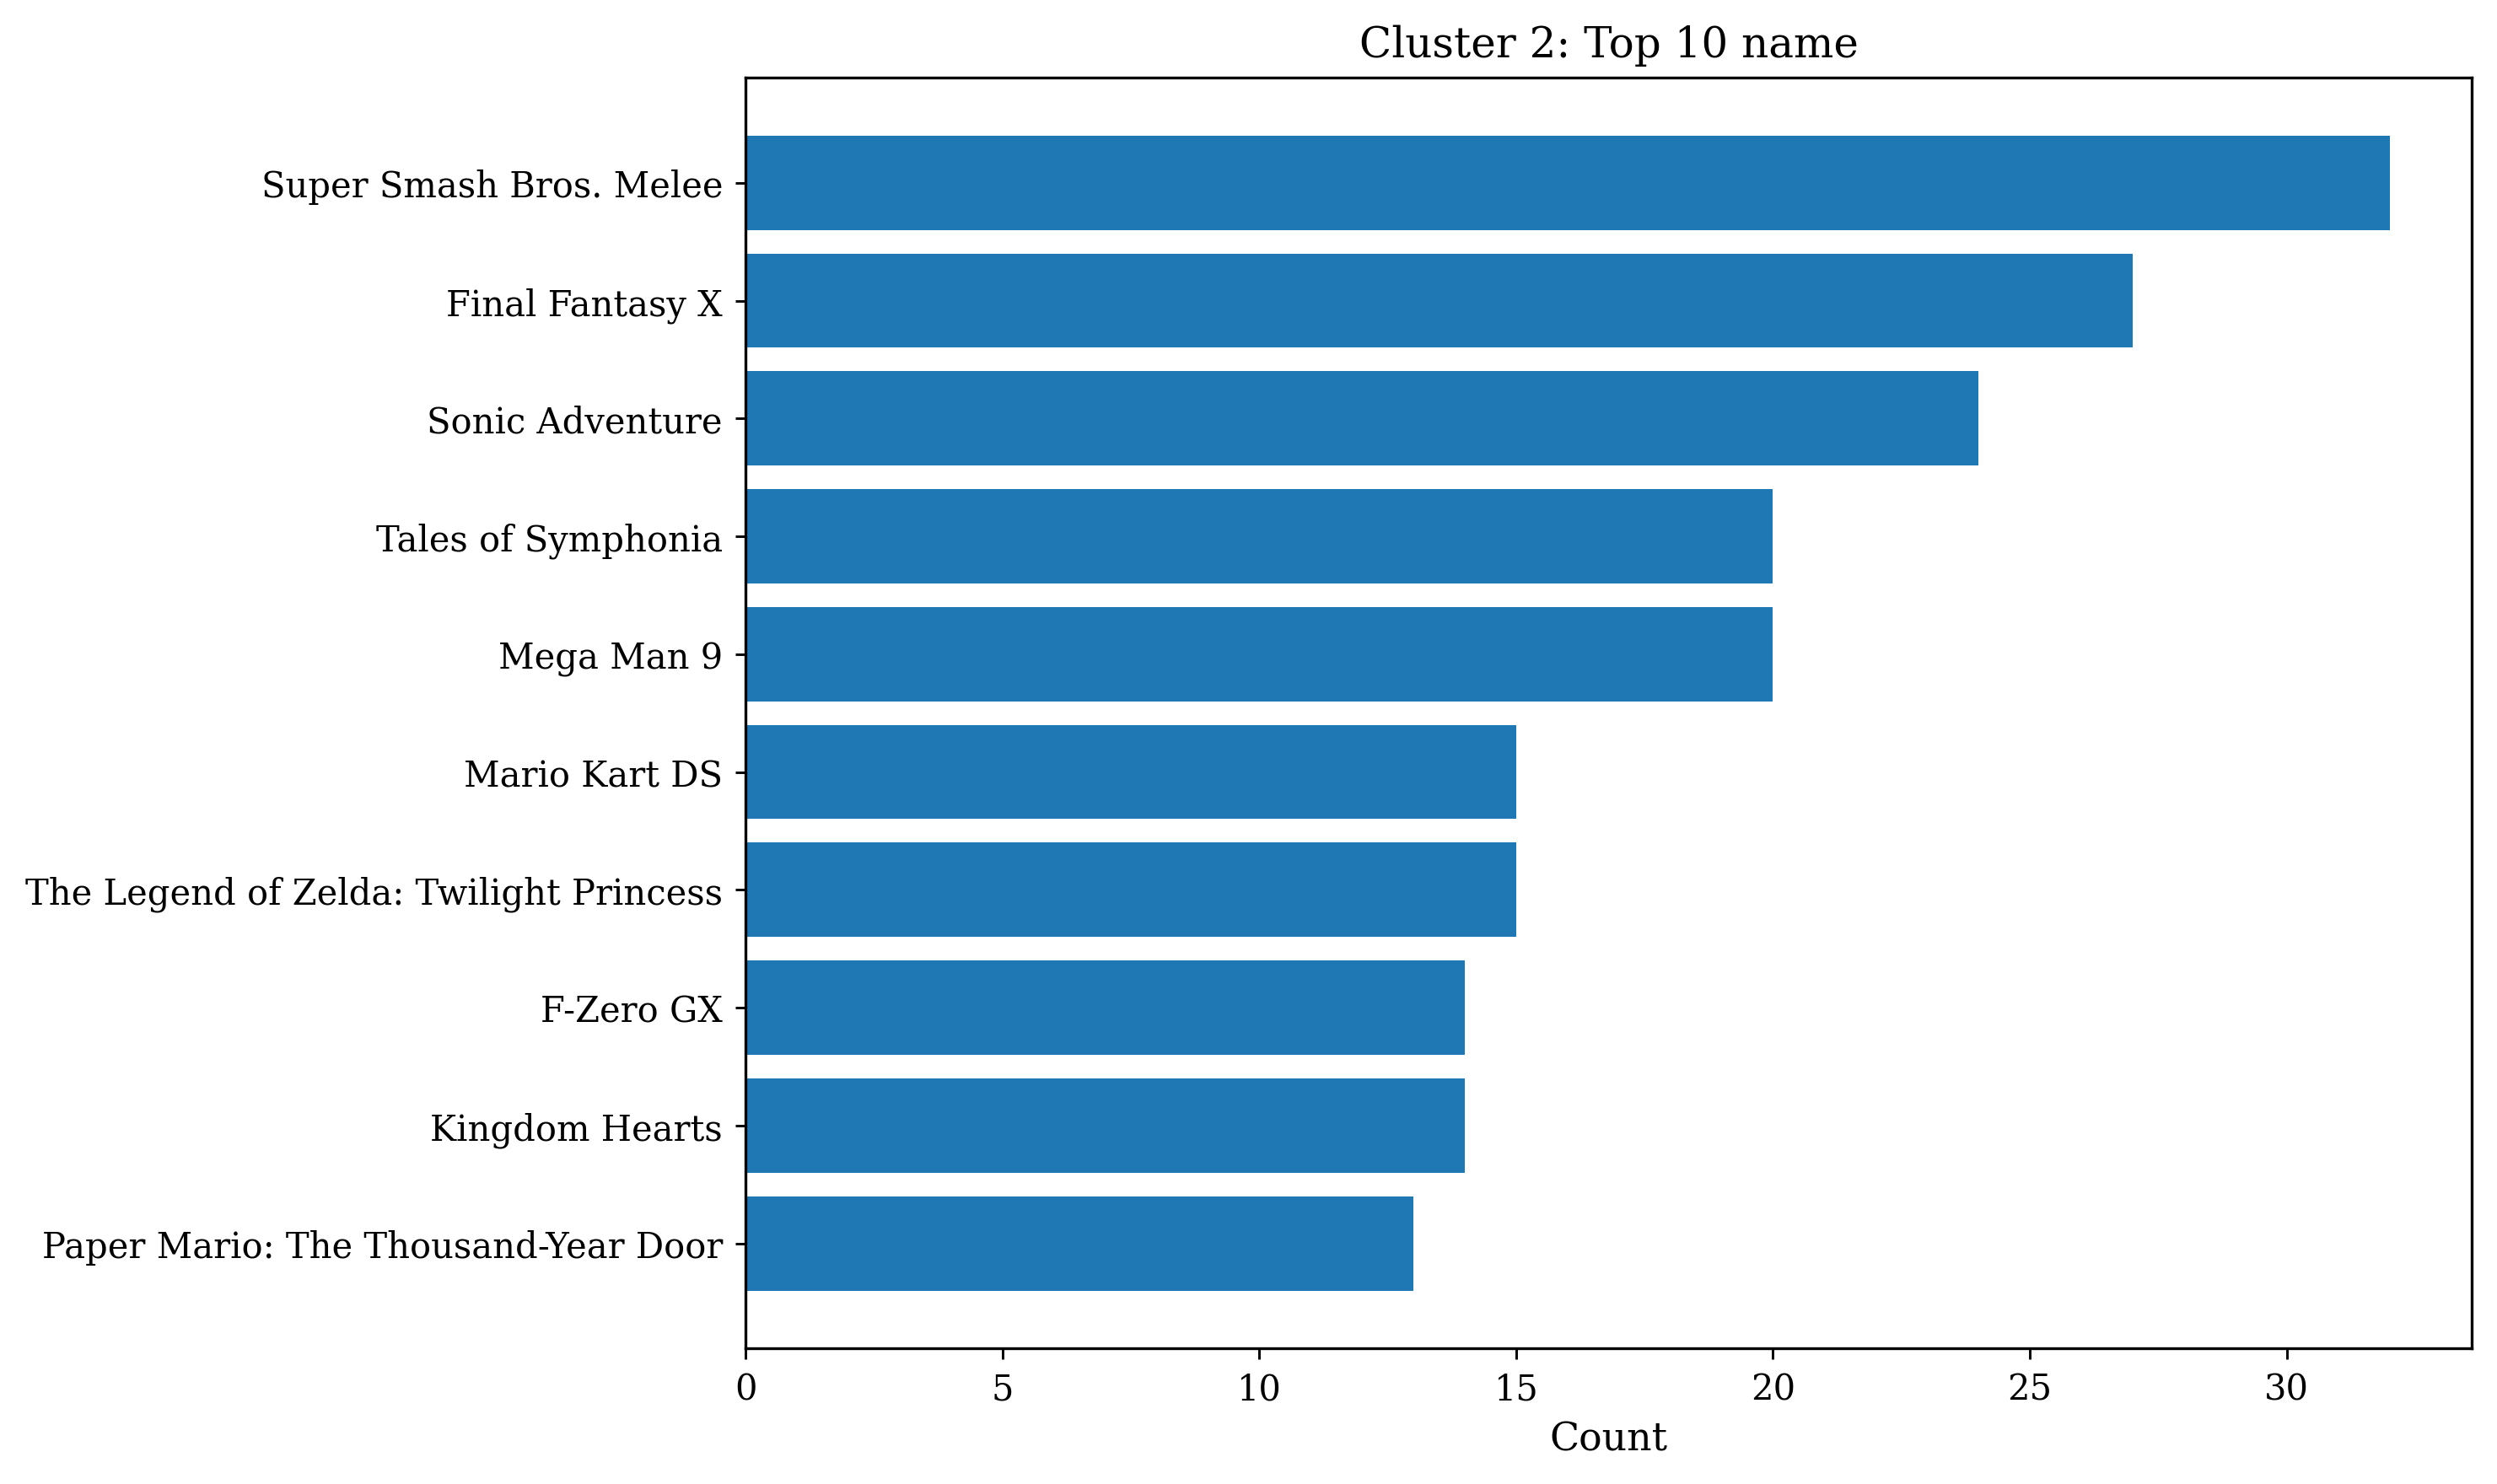

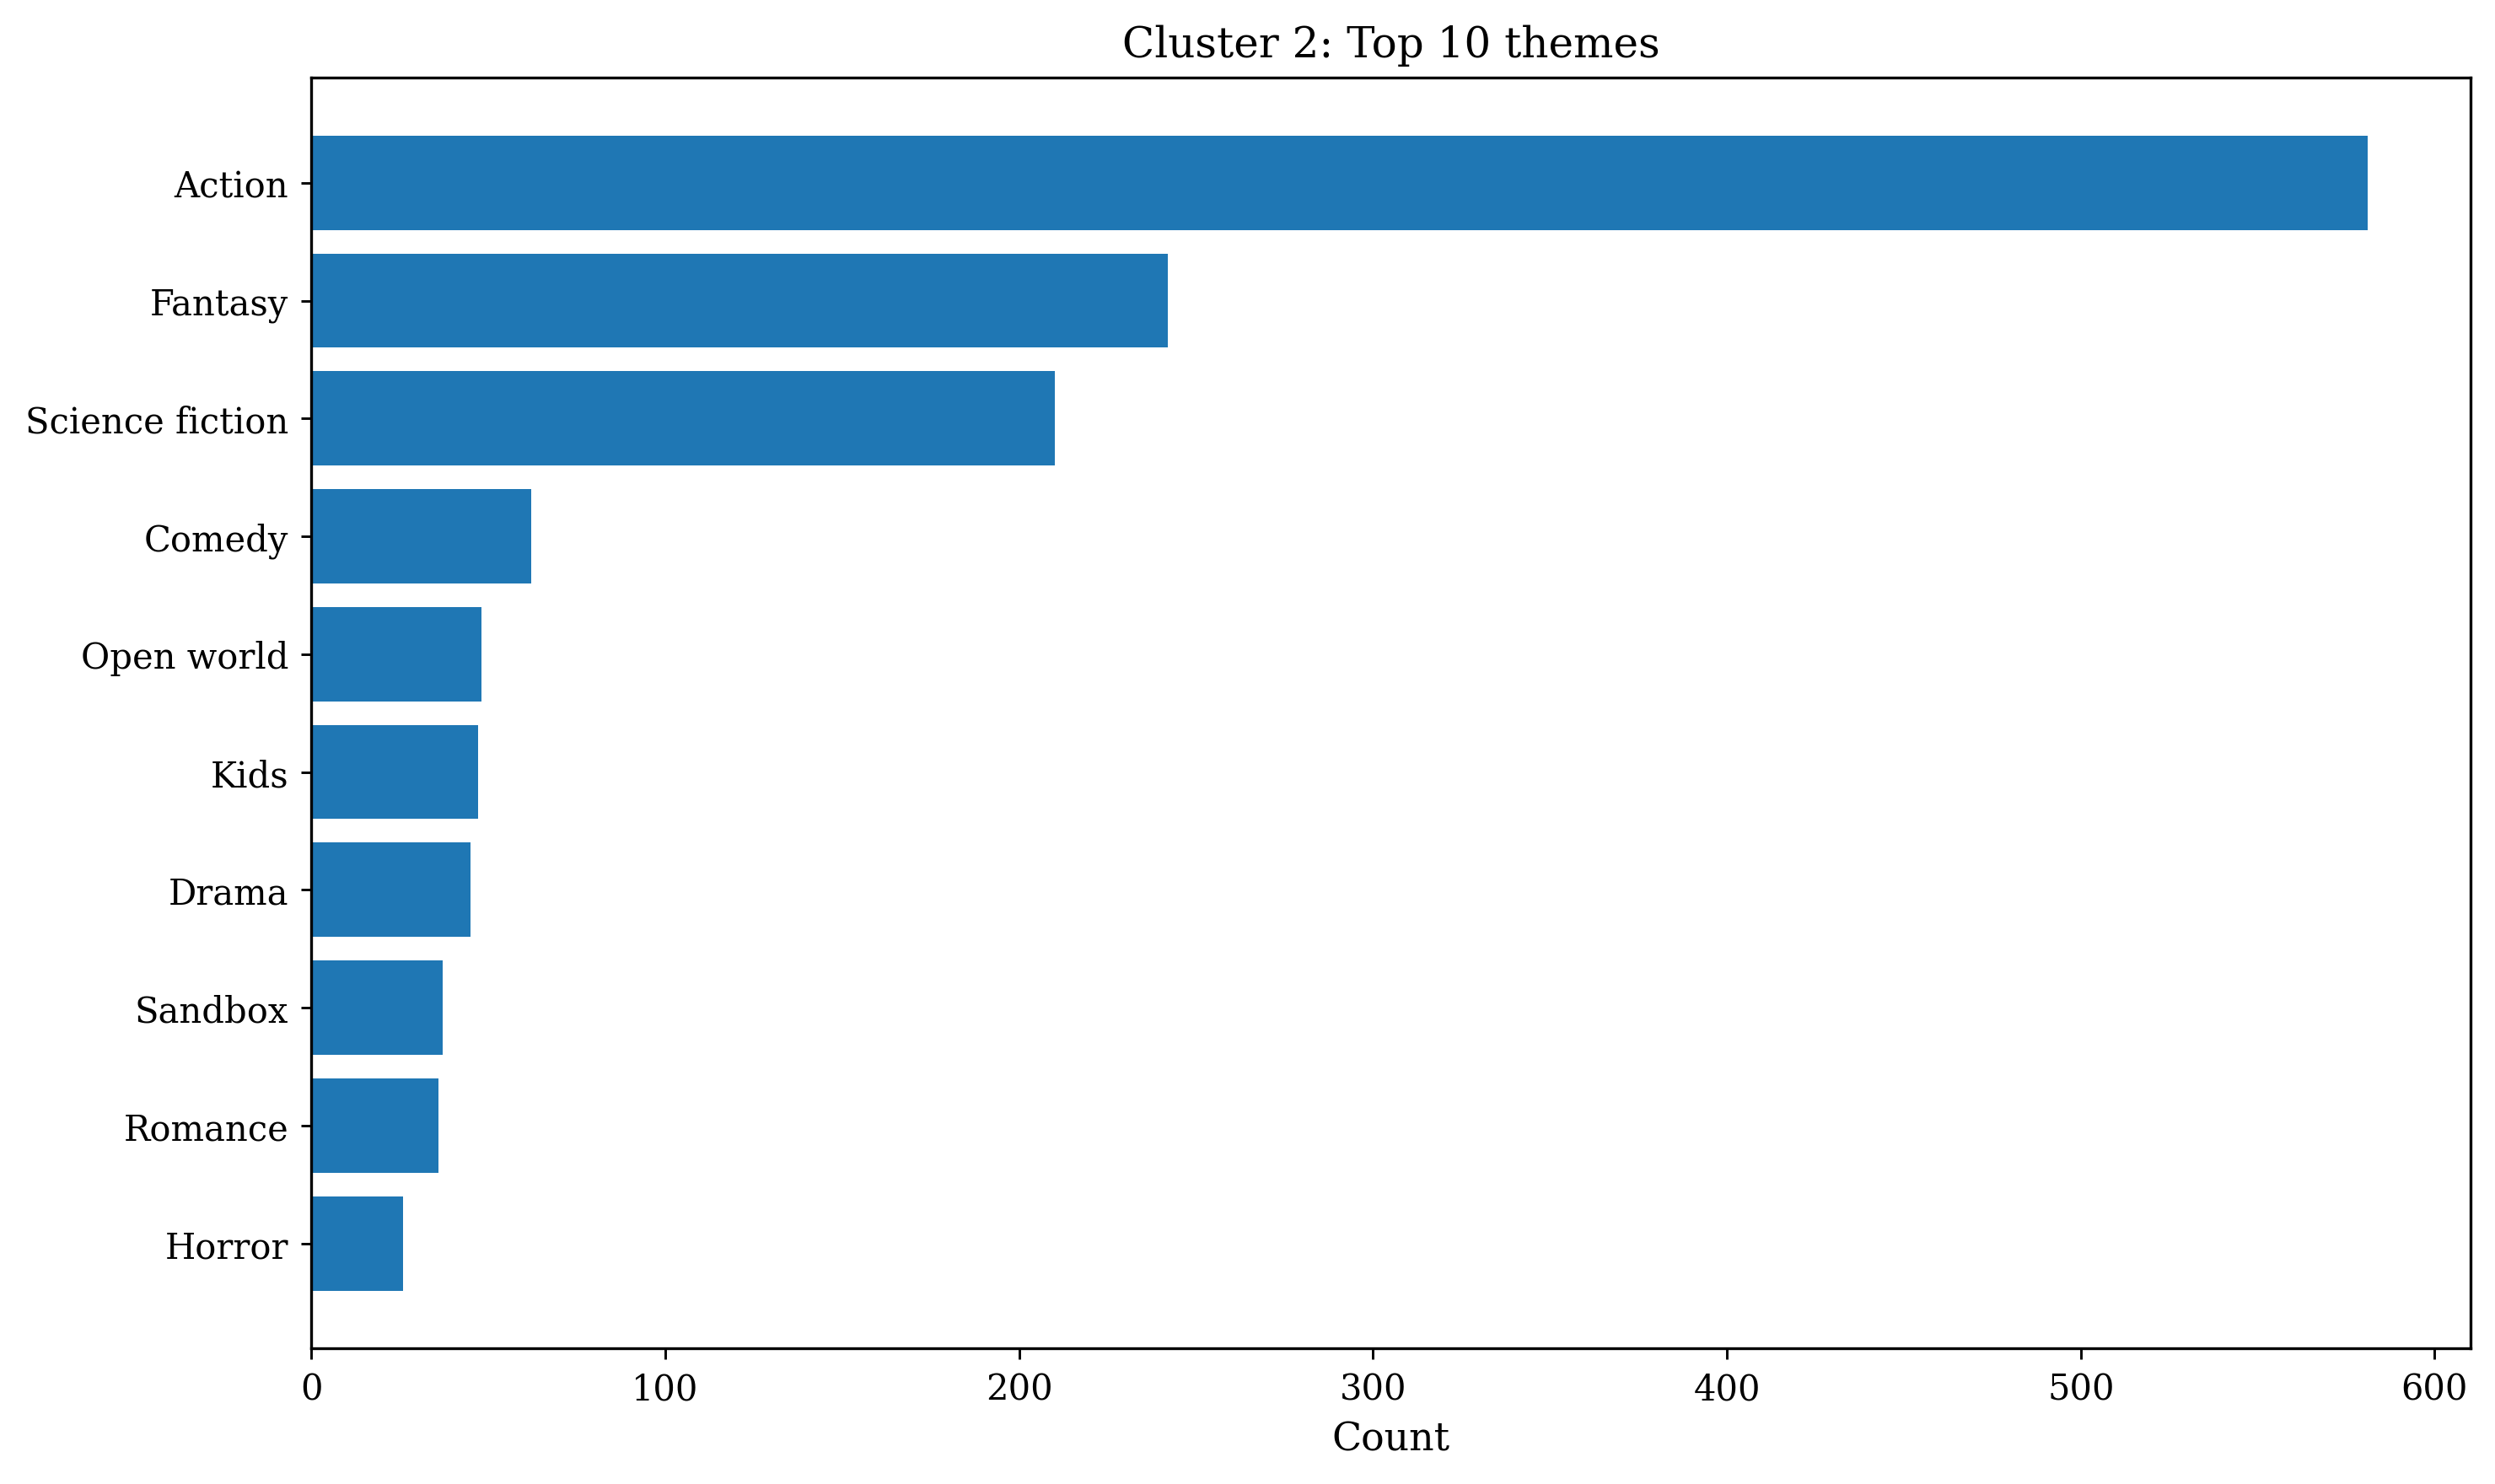

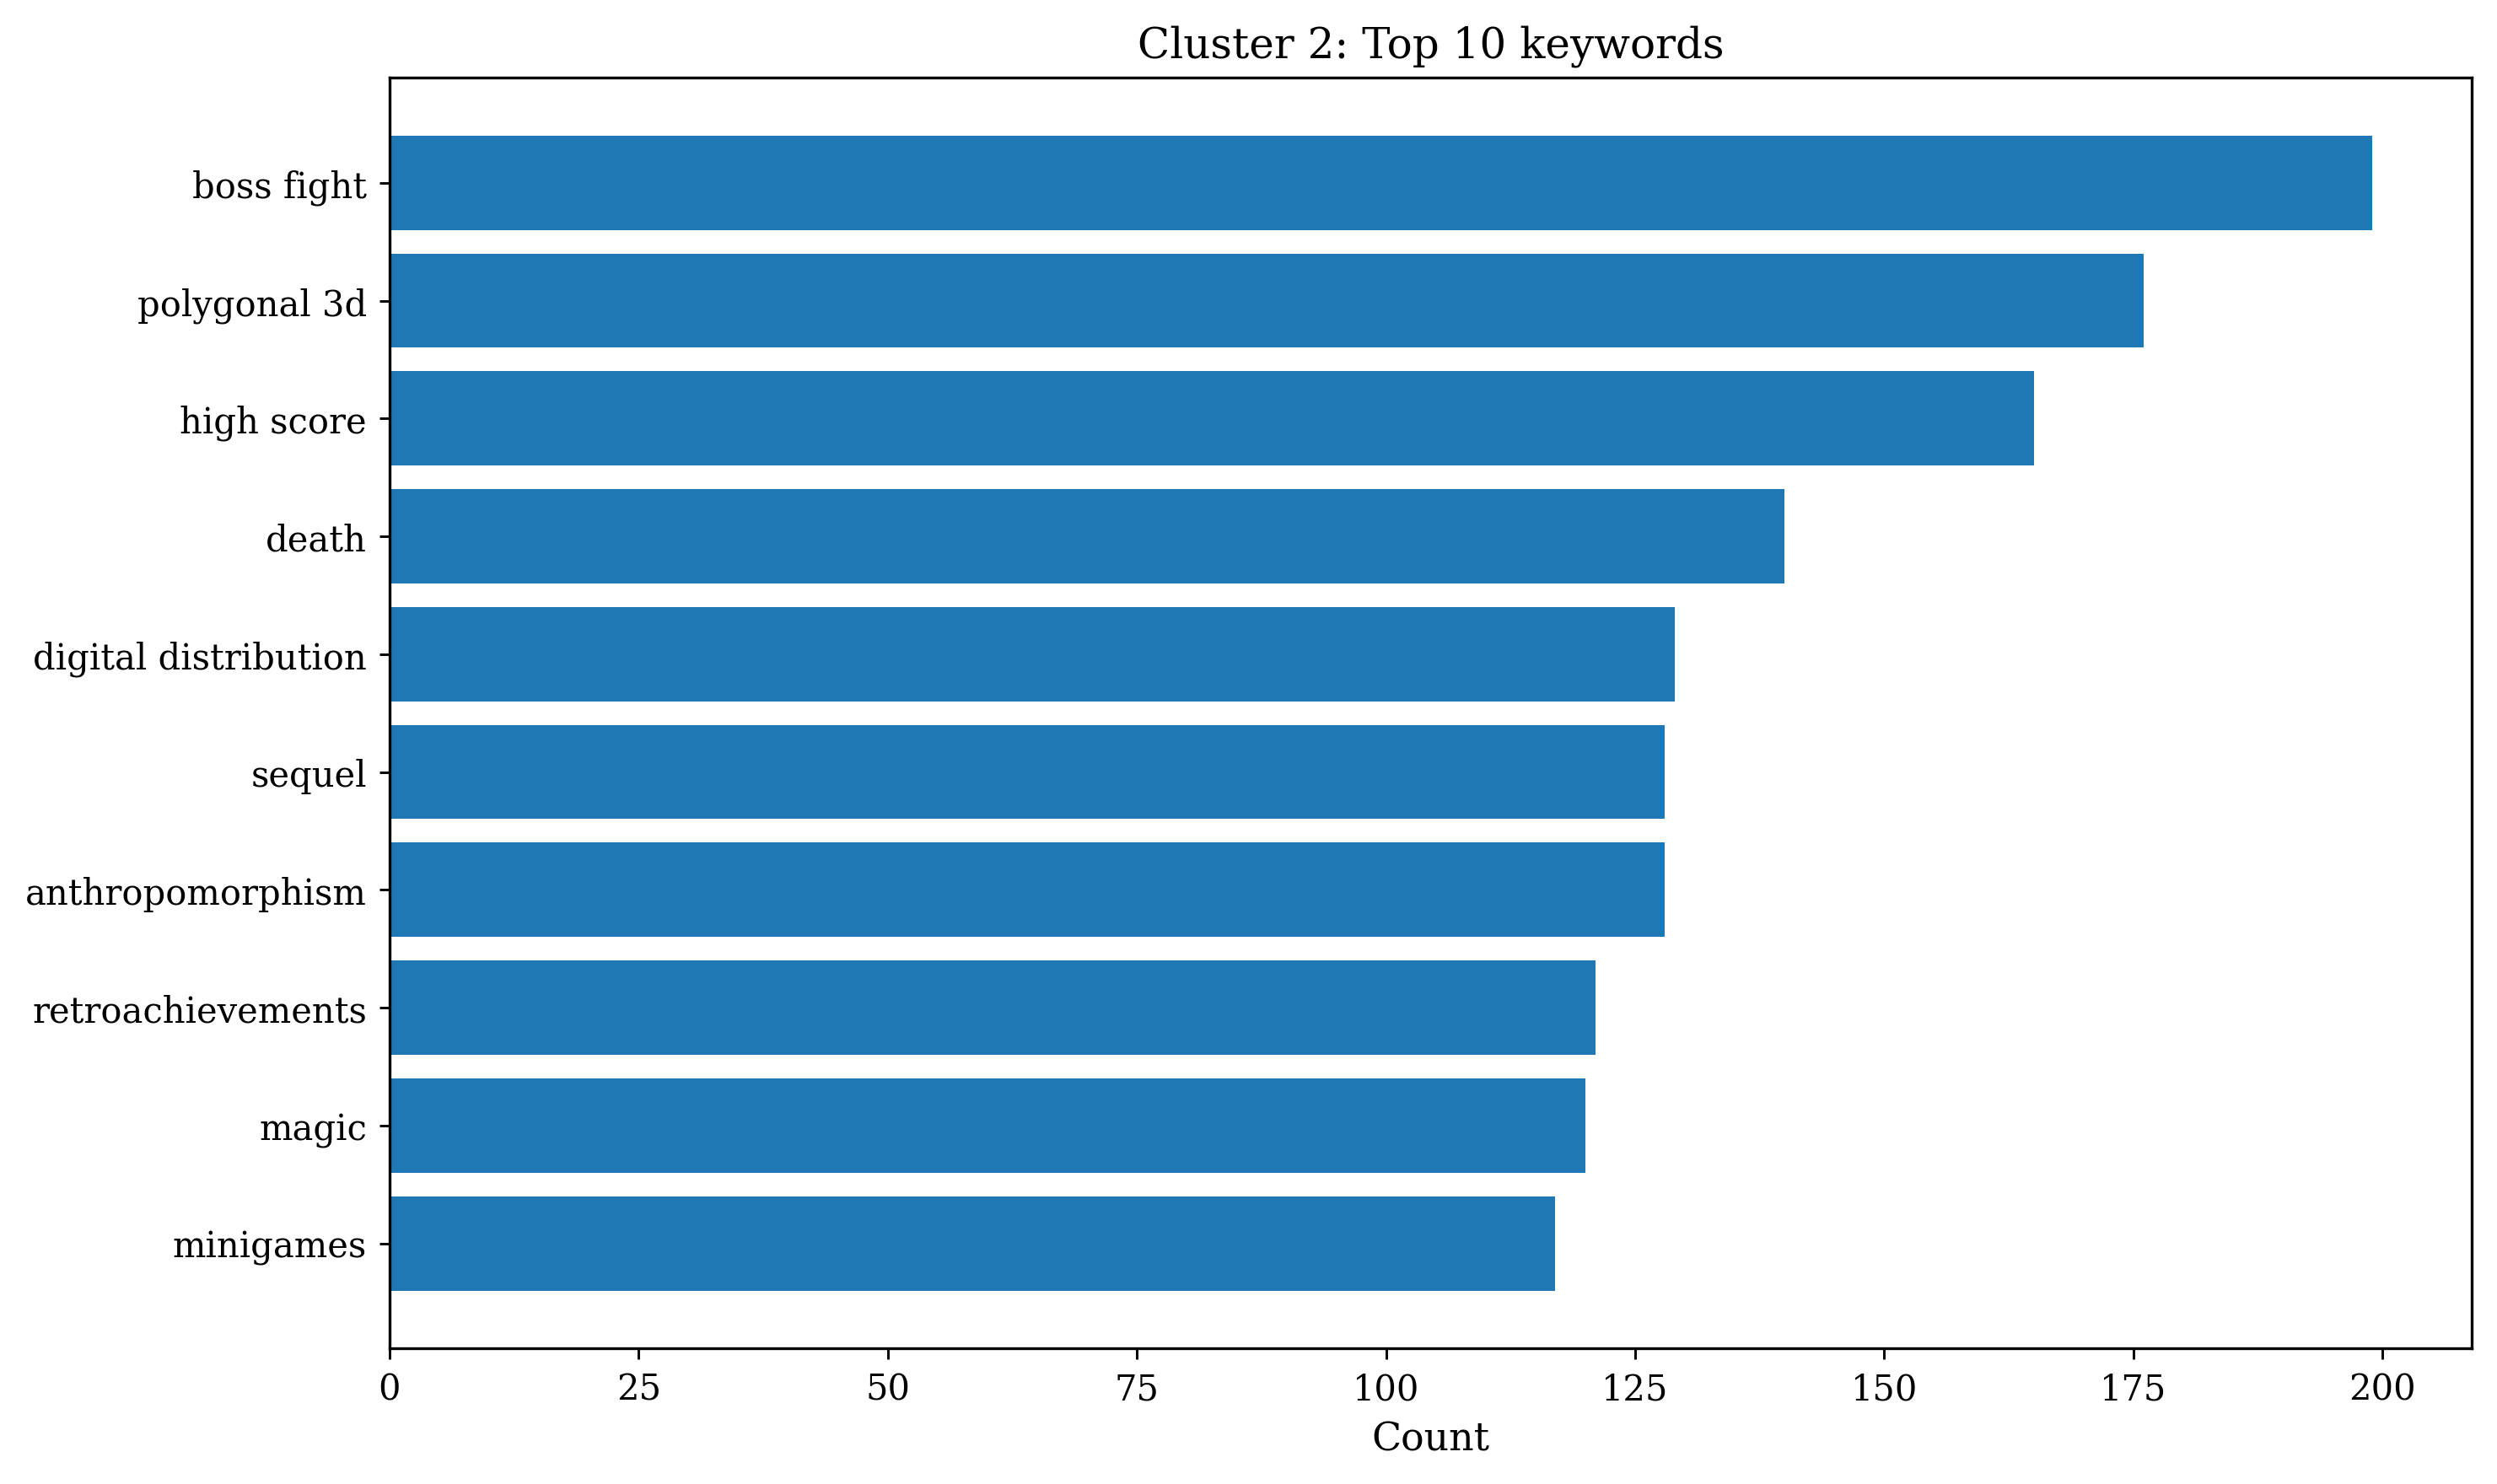

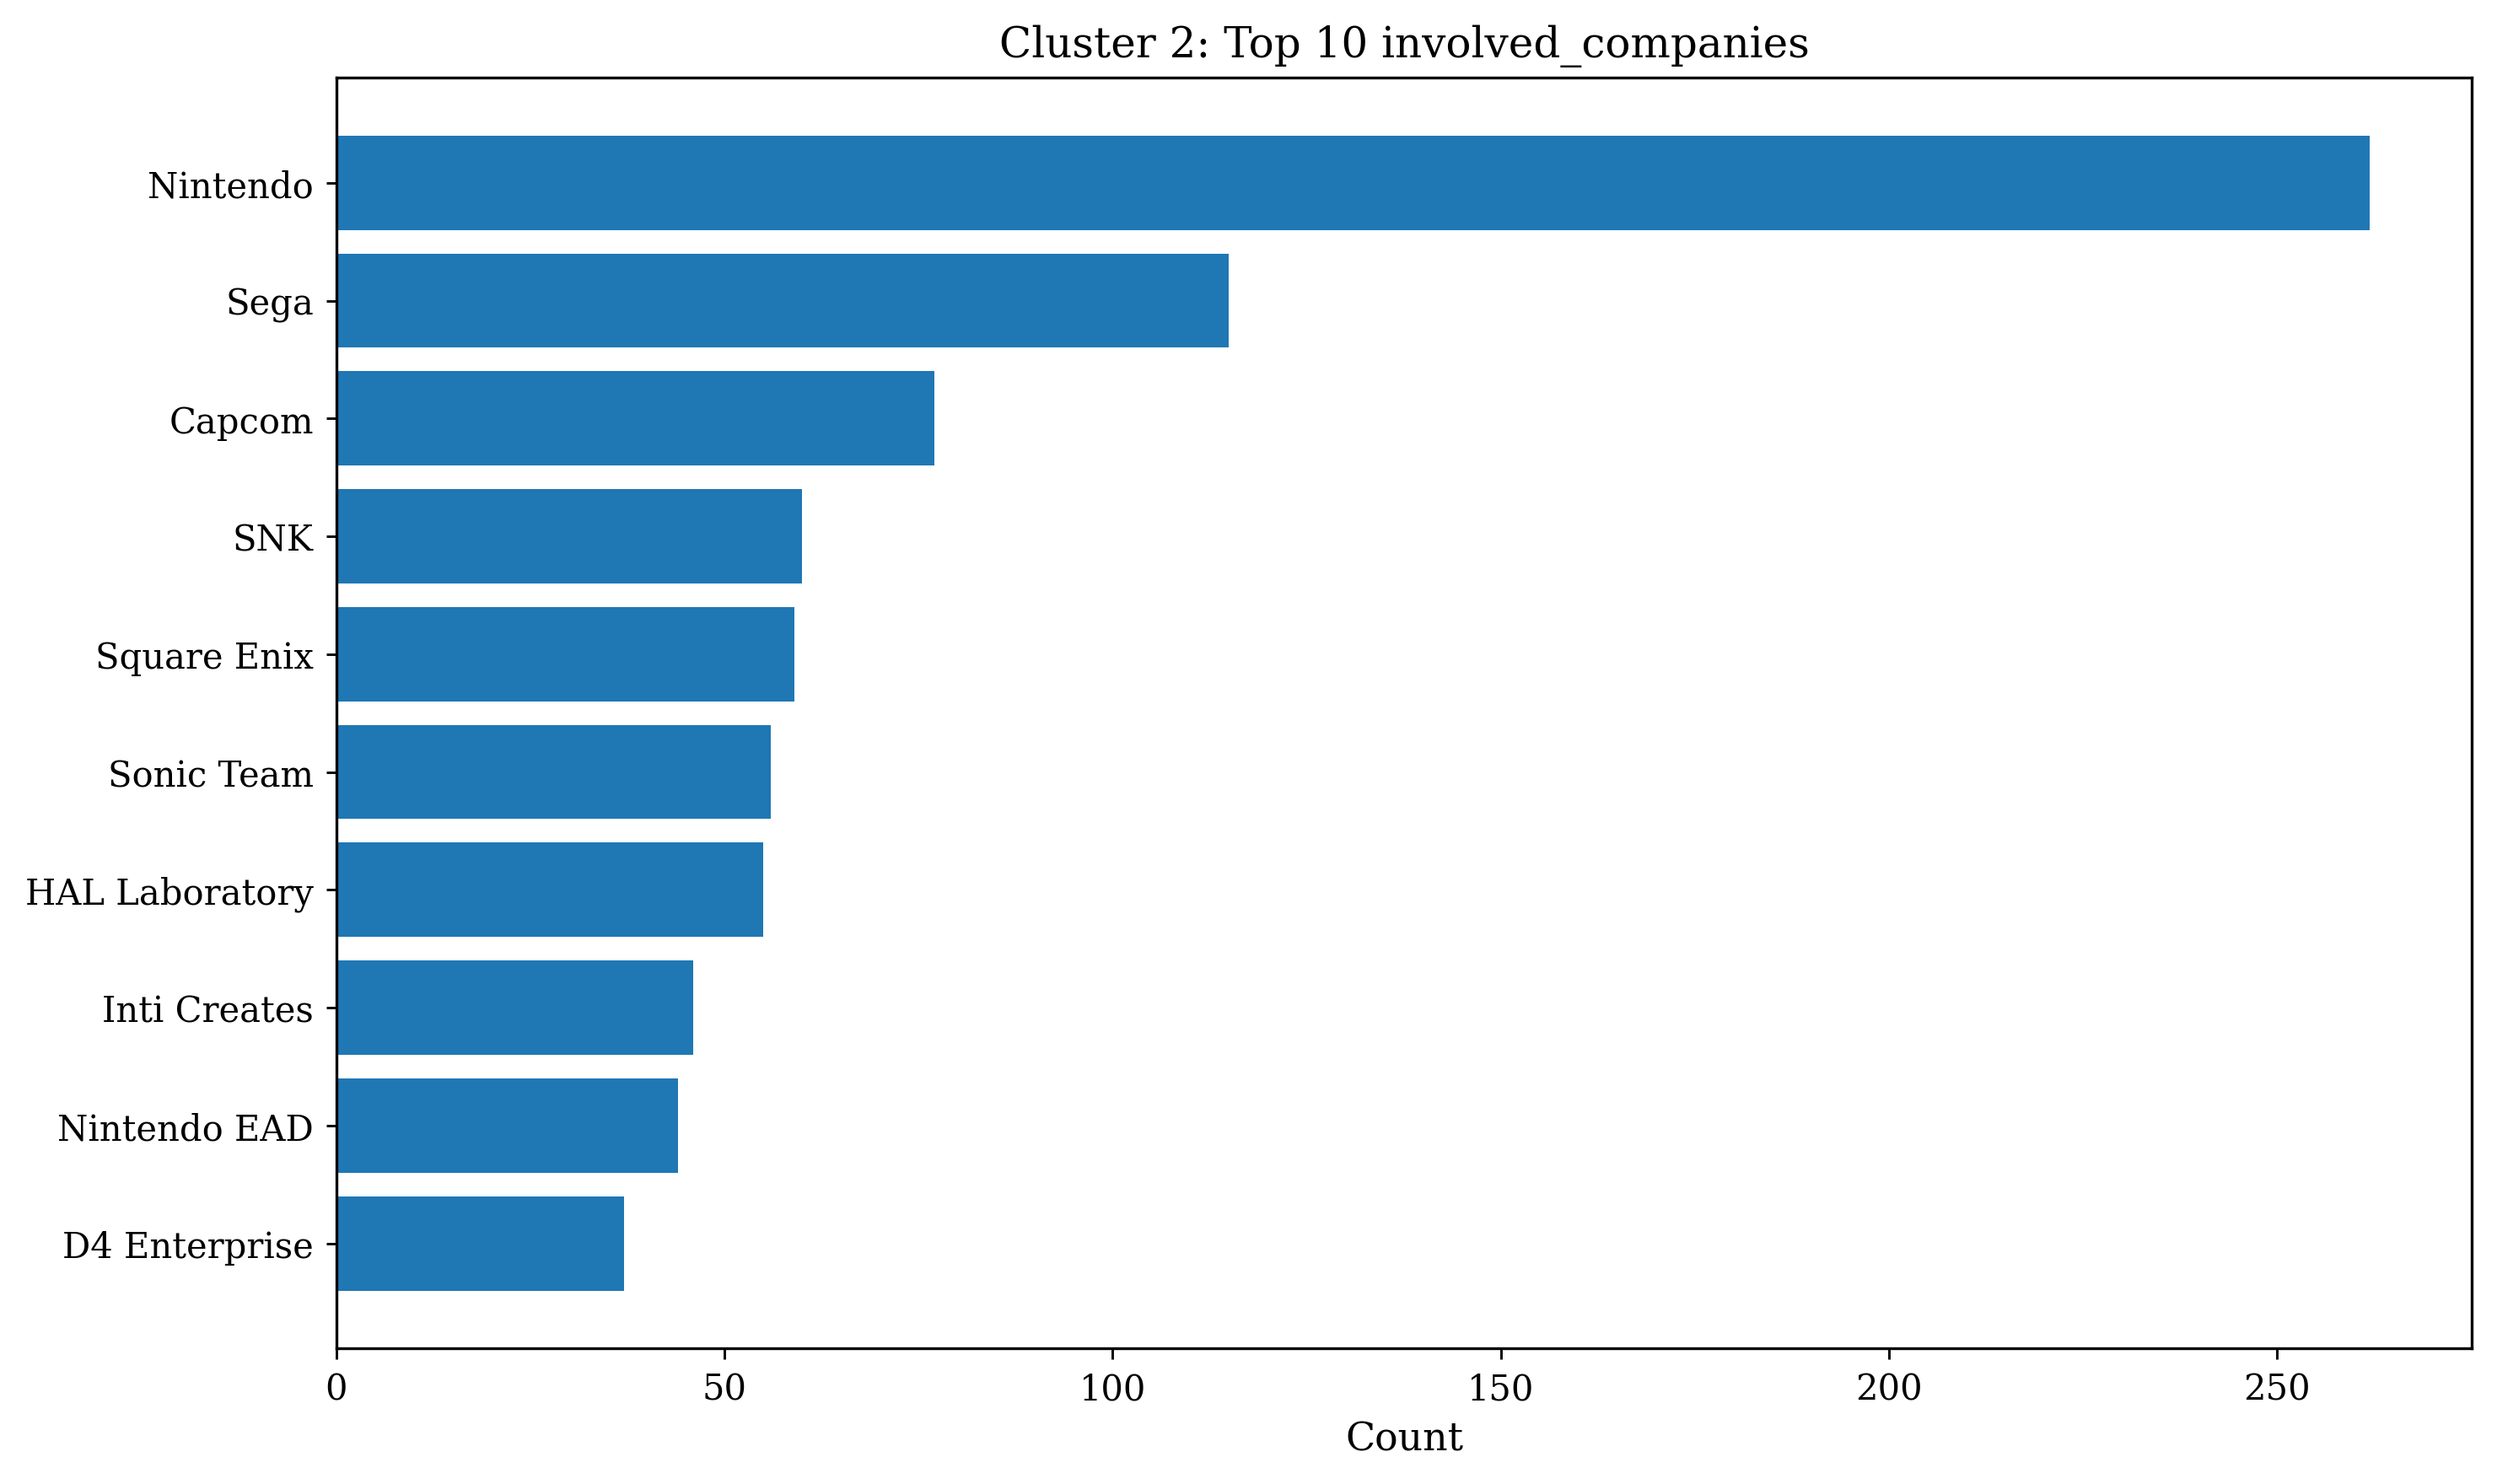

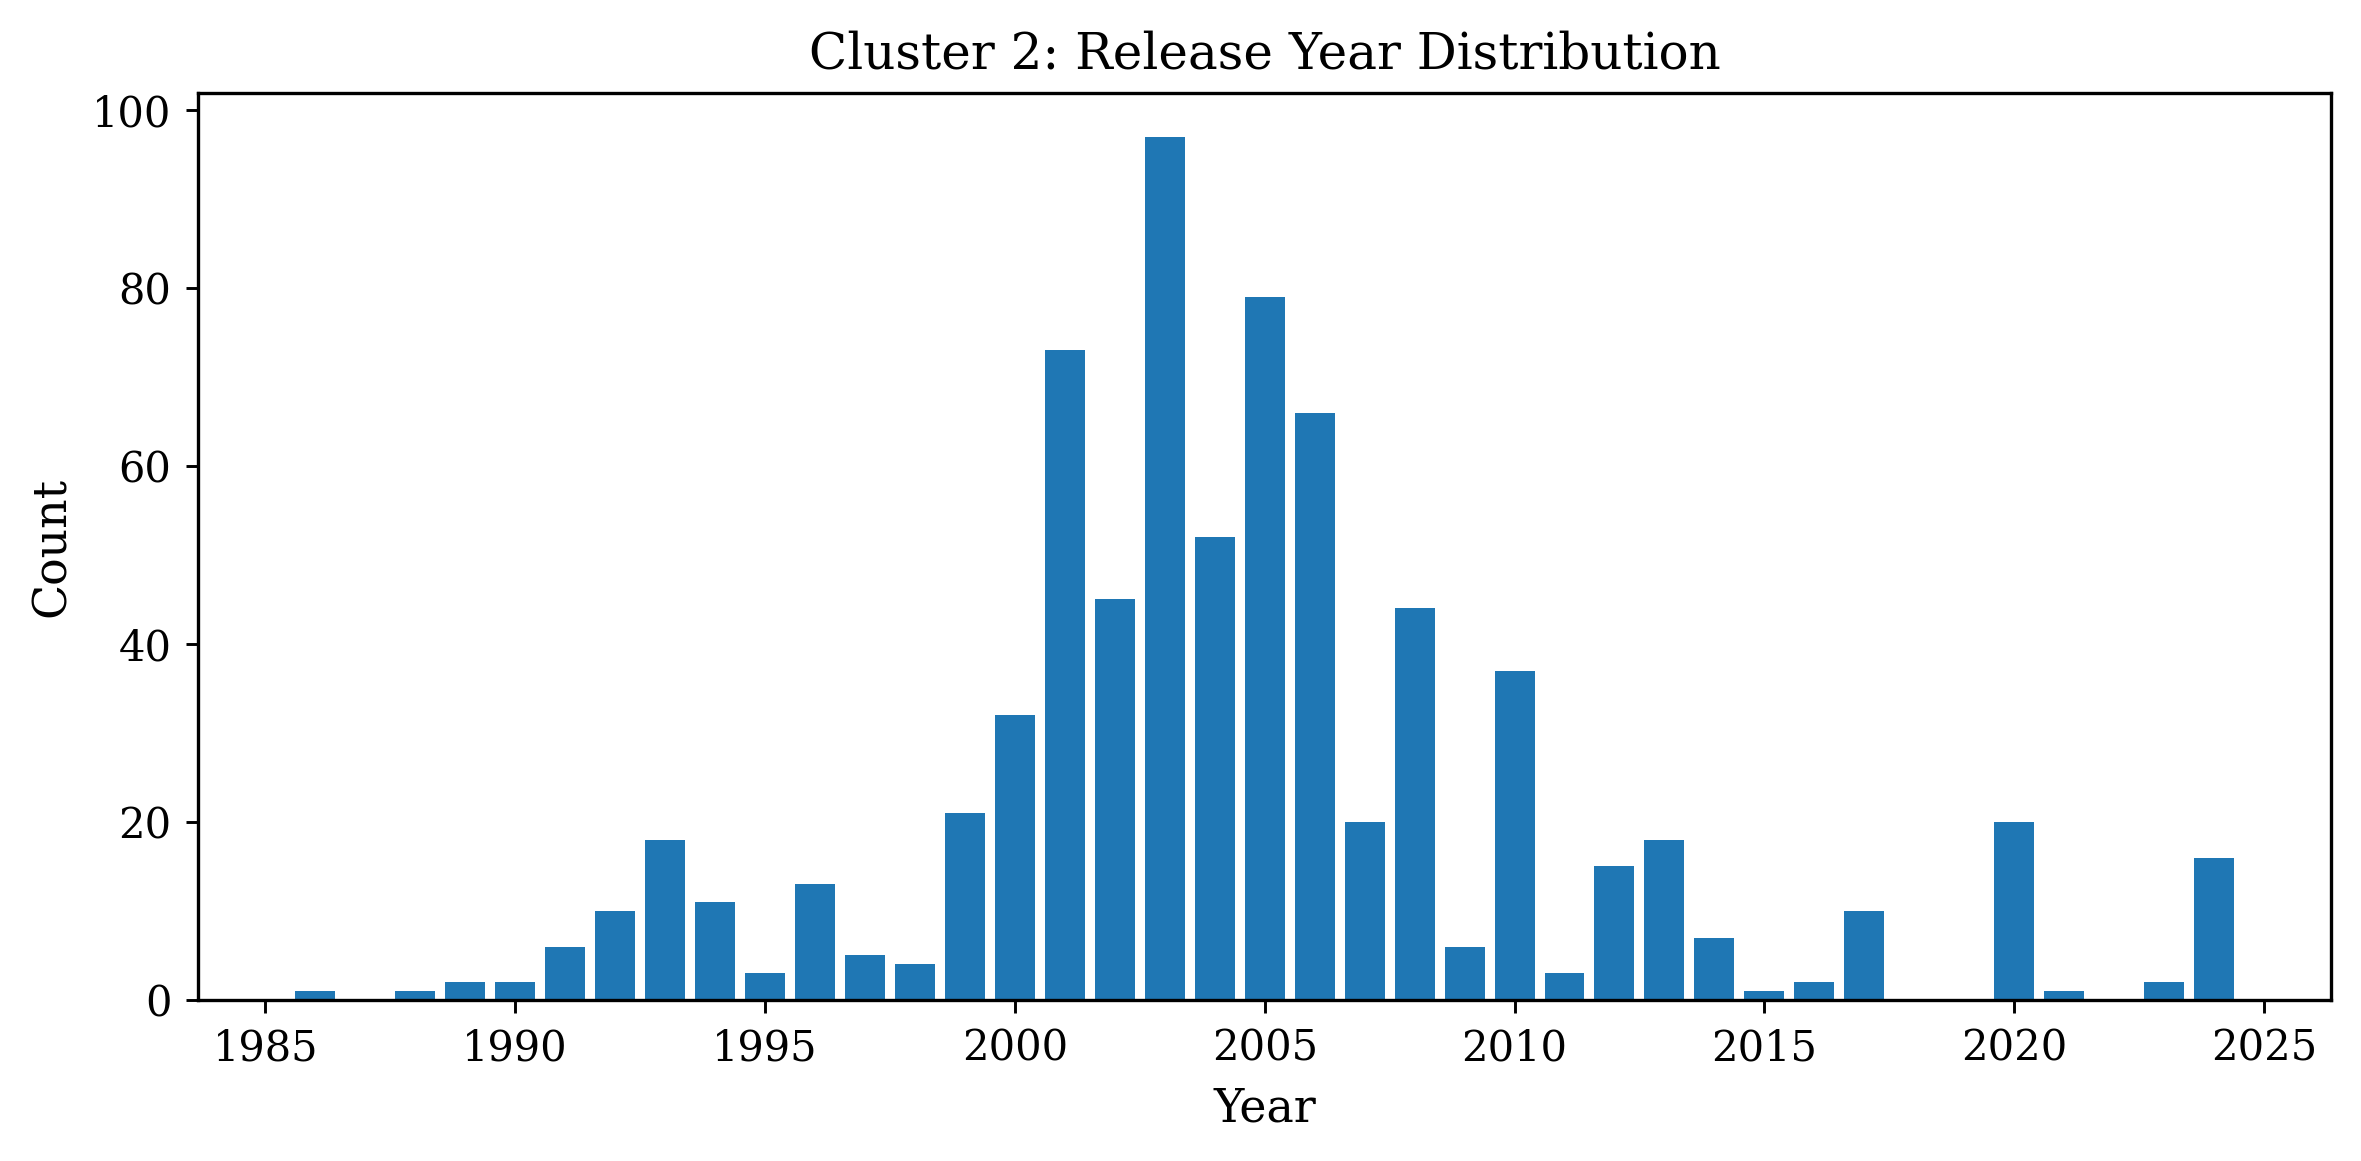


=== Cluster 3 ===


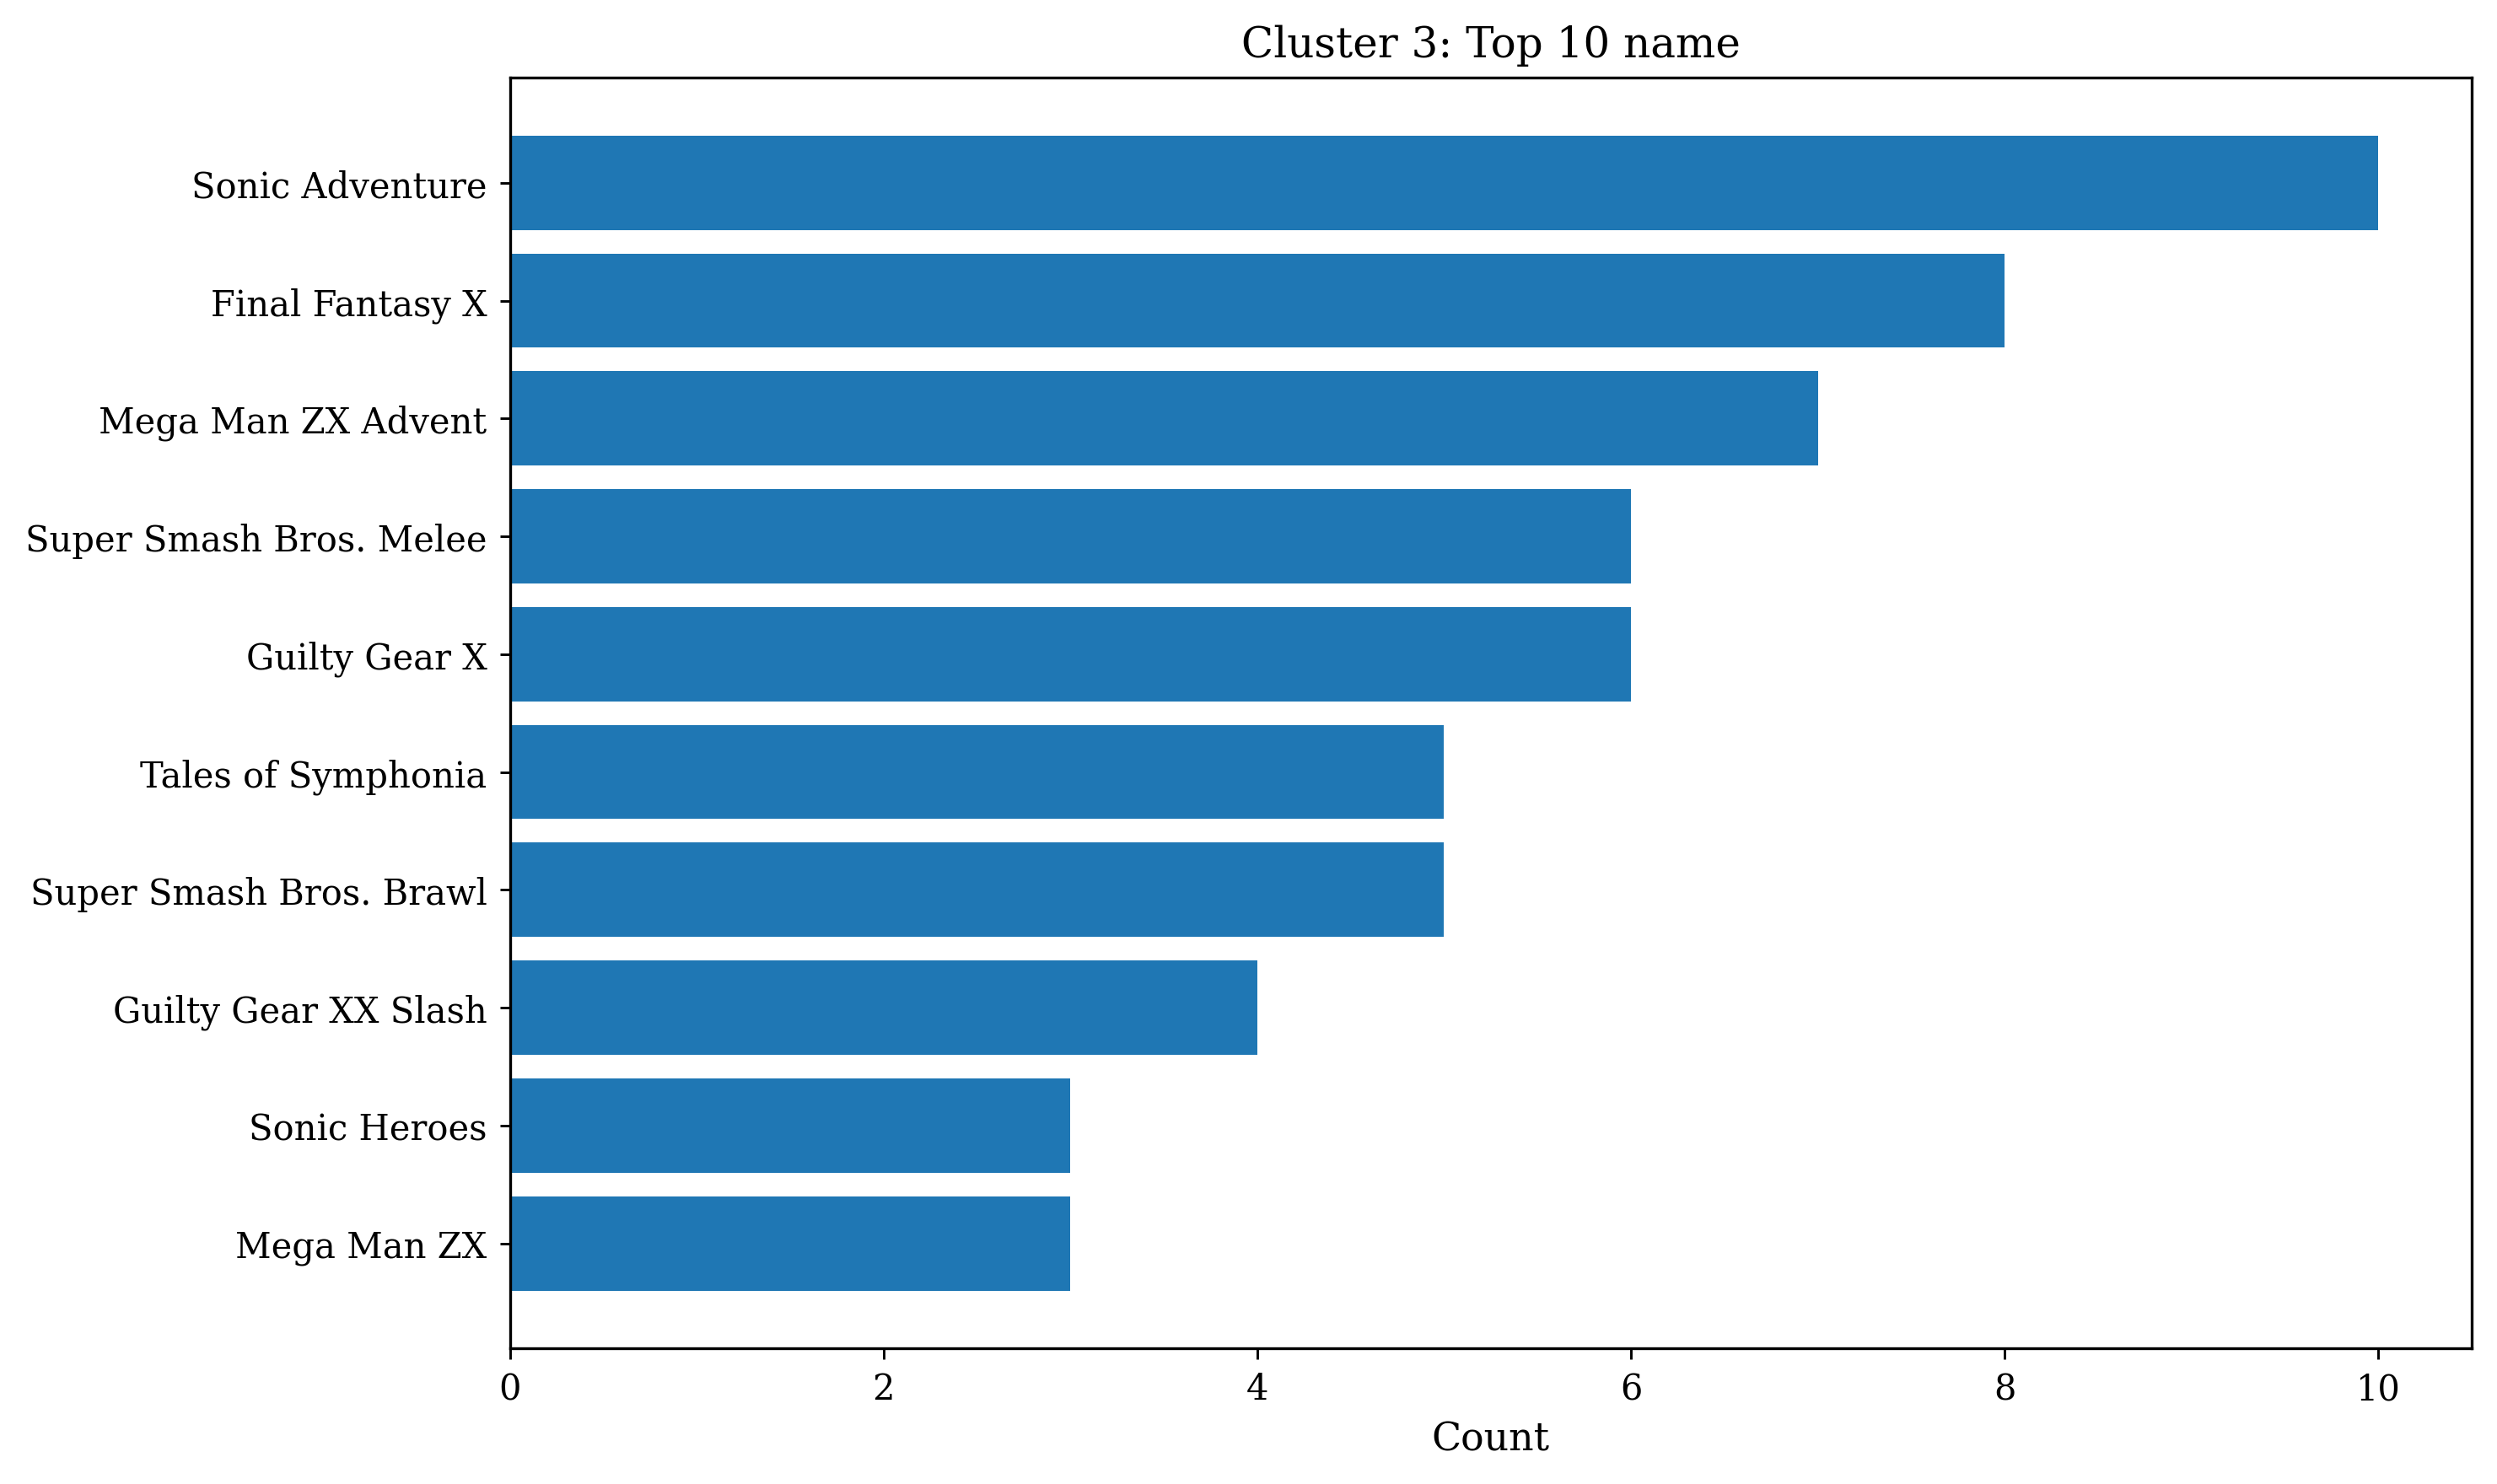

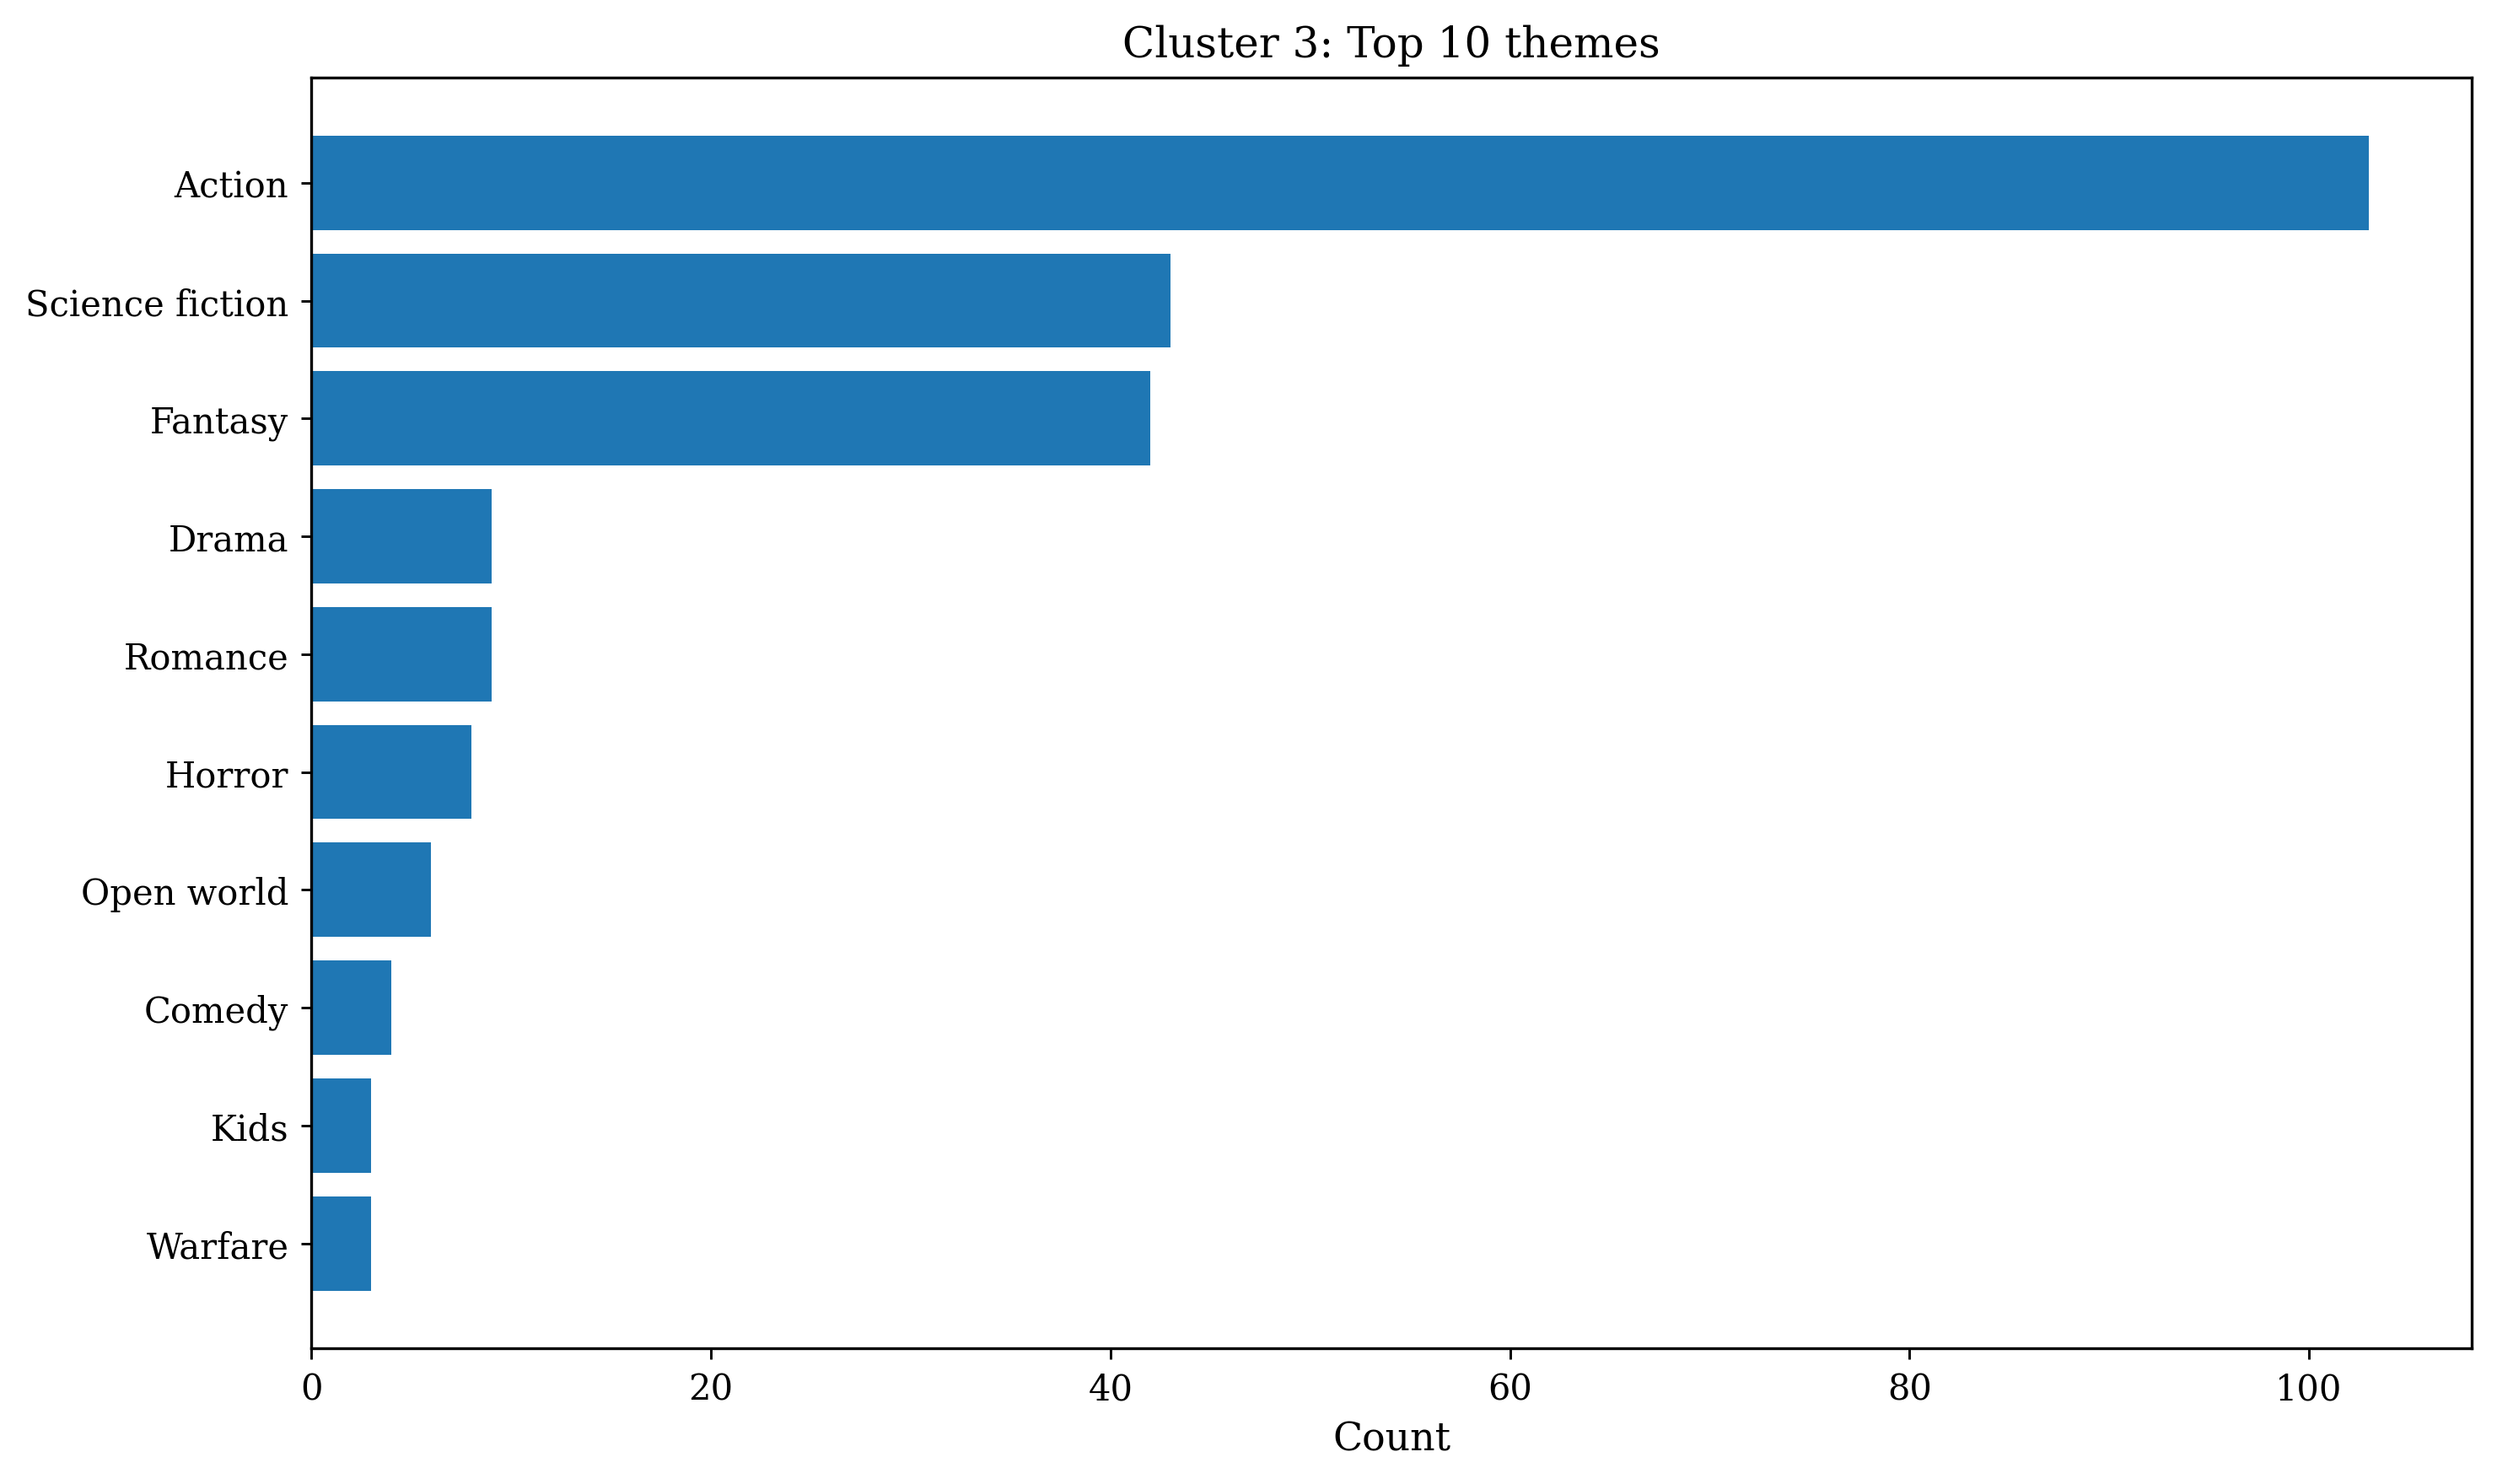

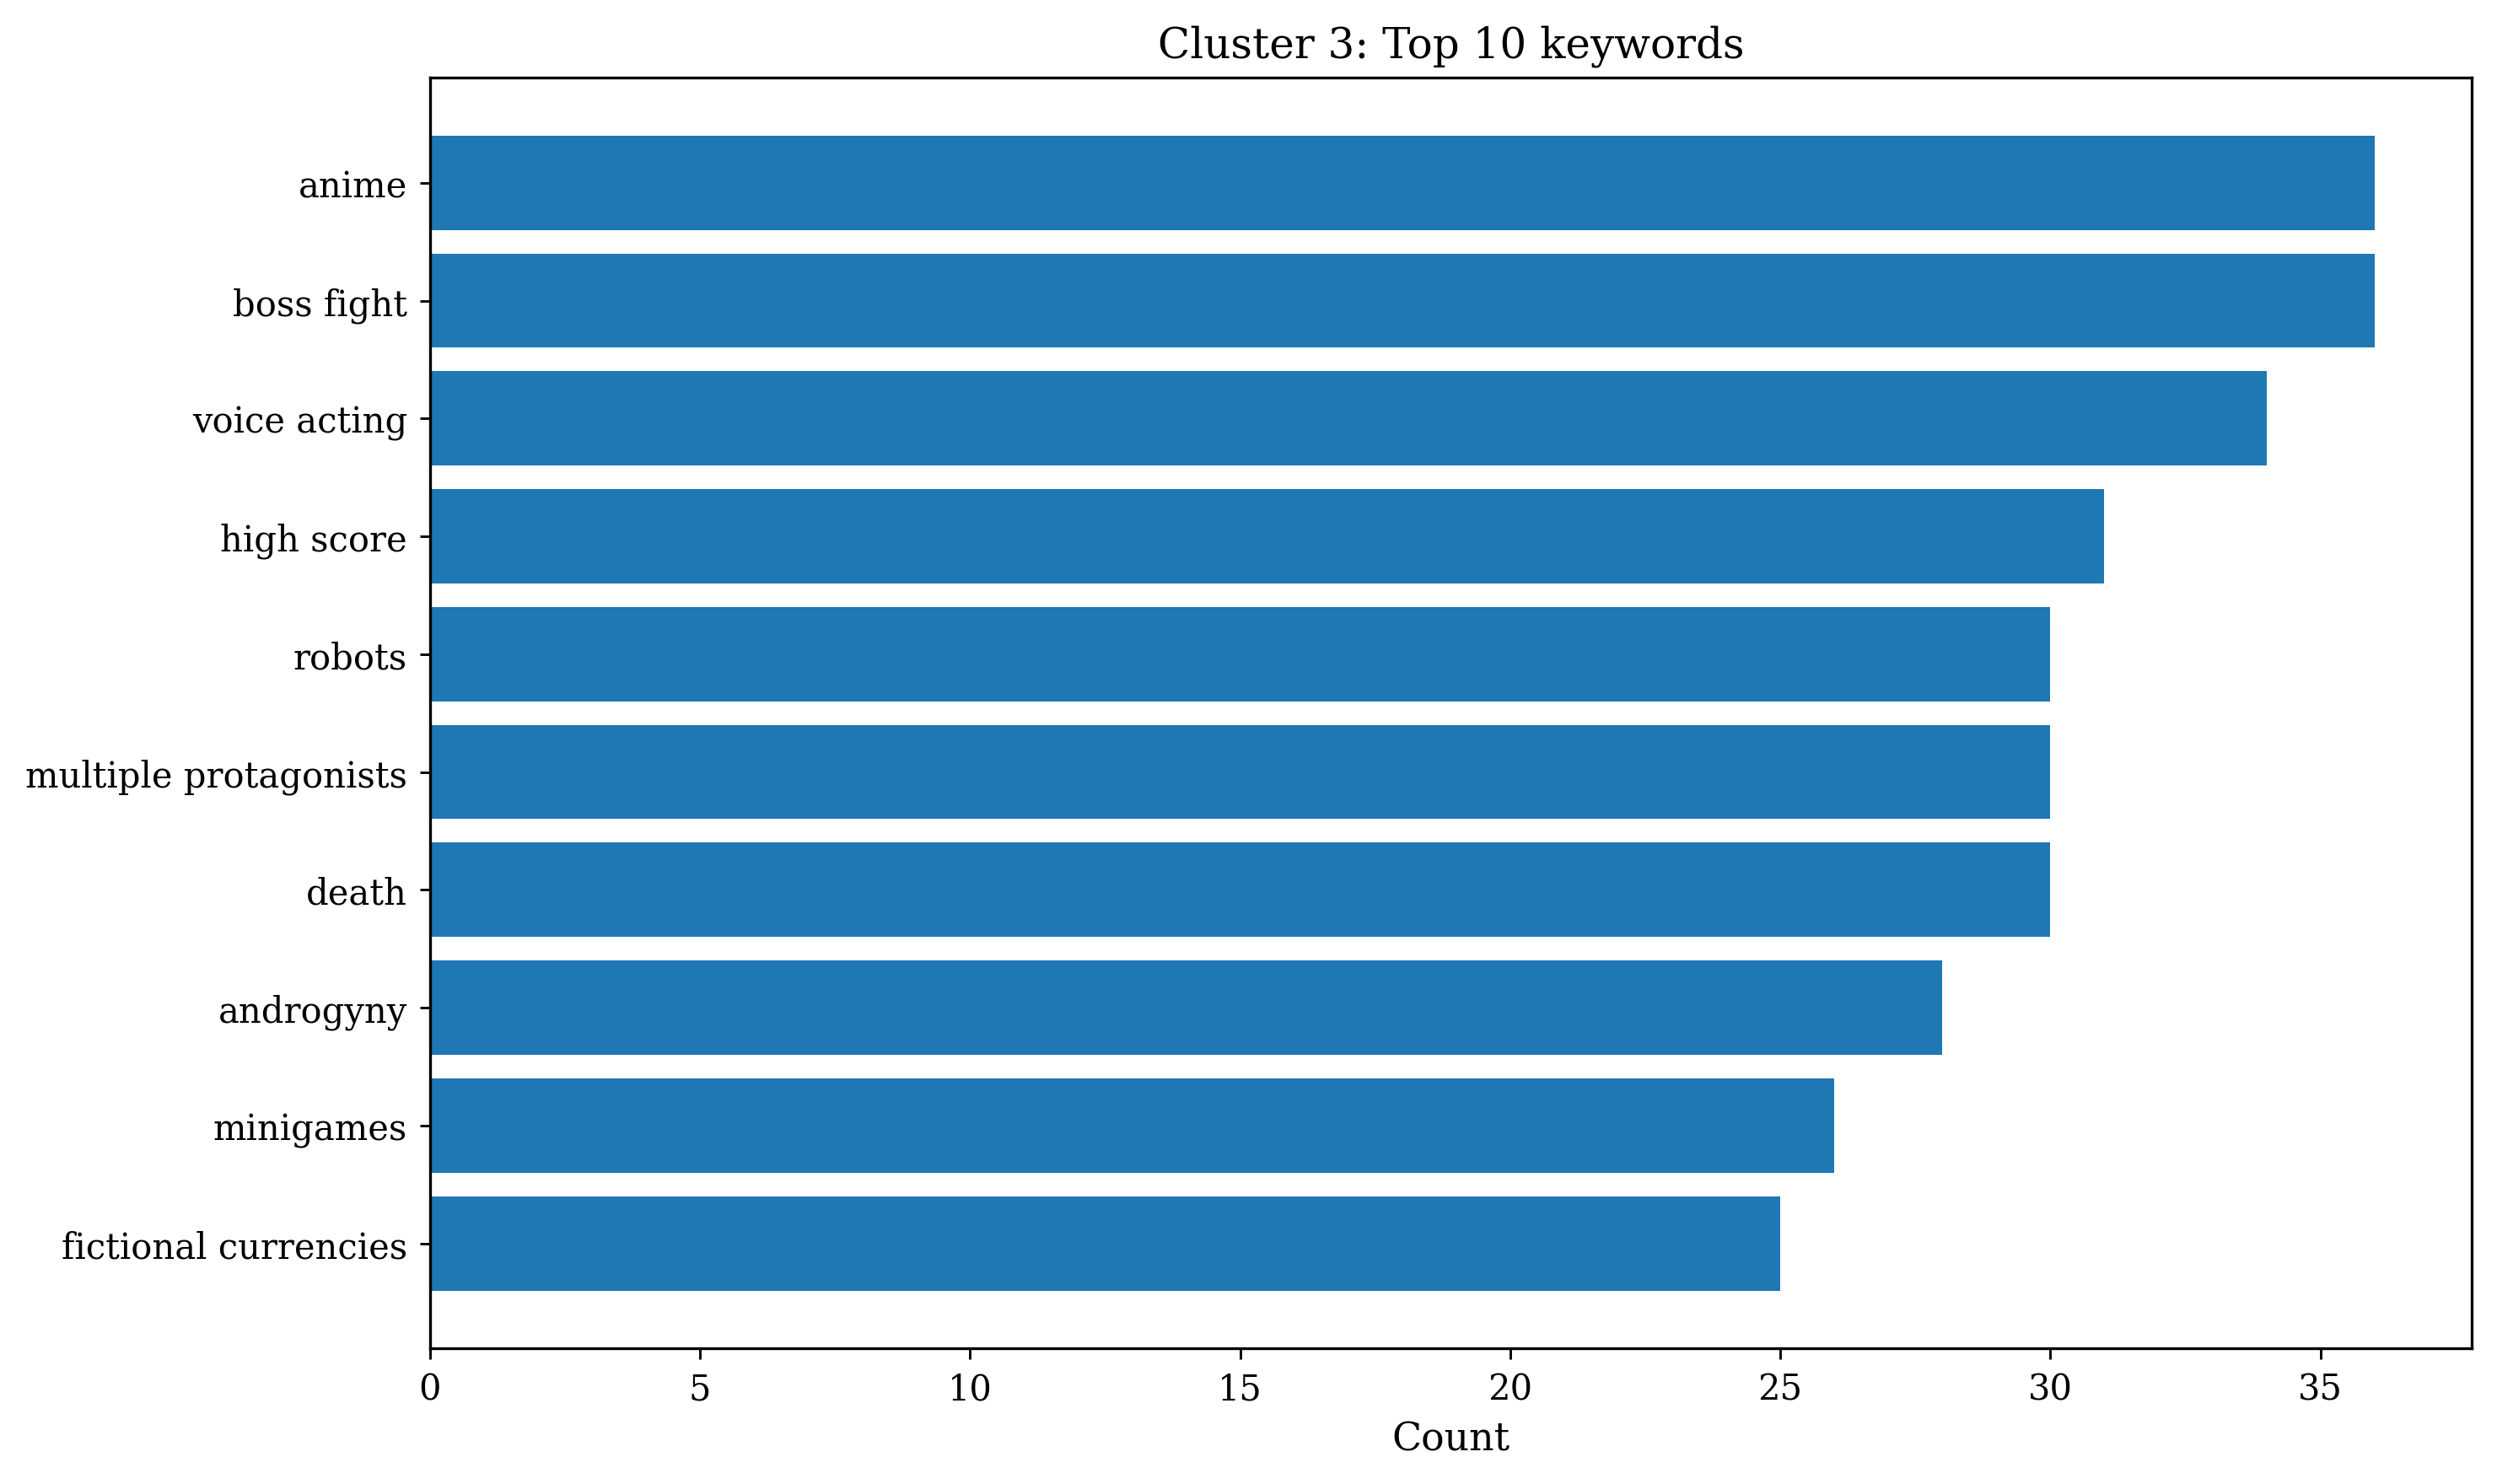

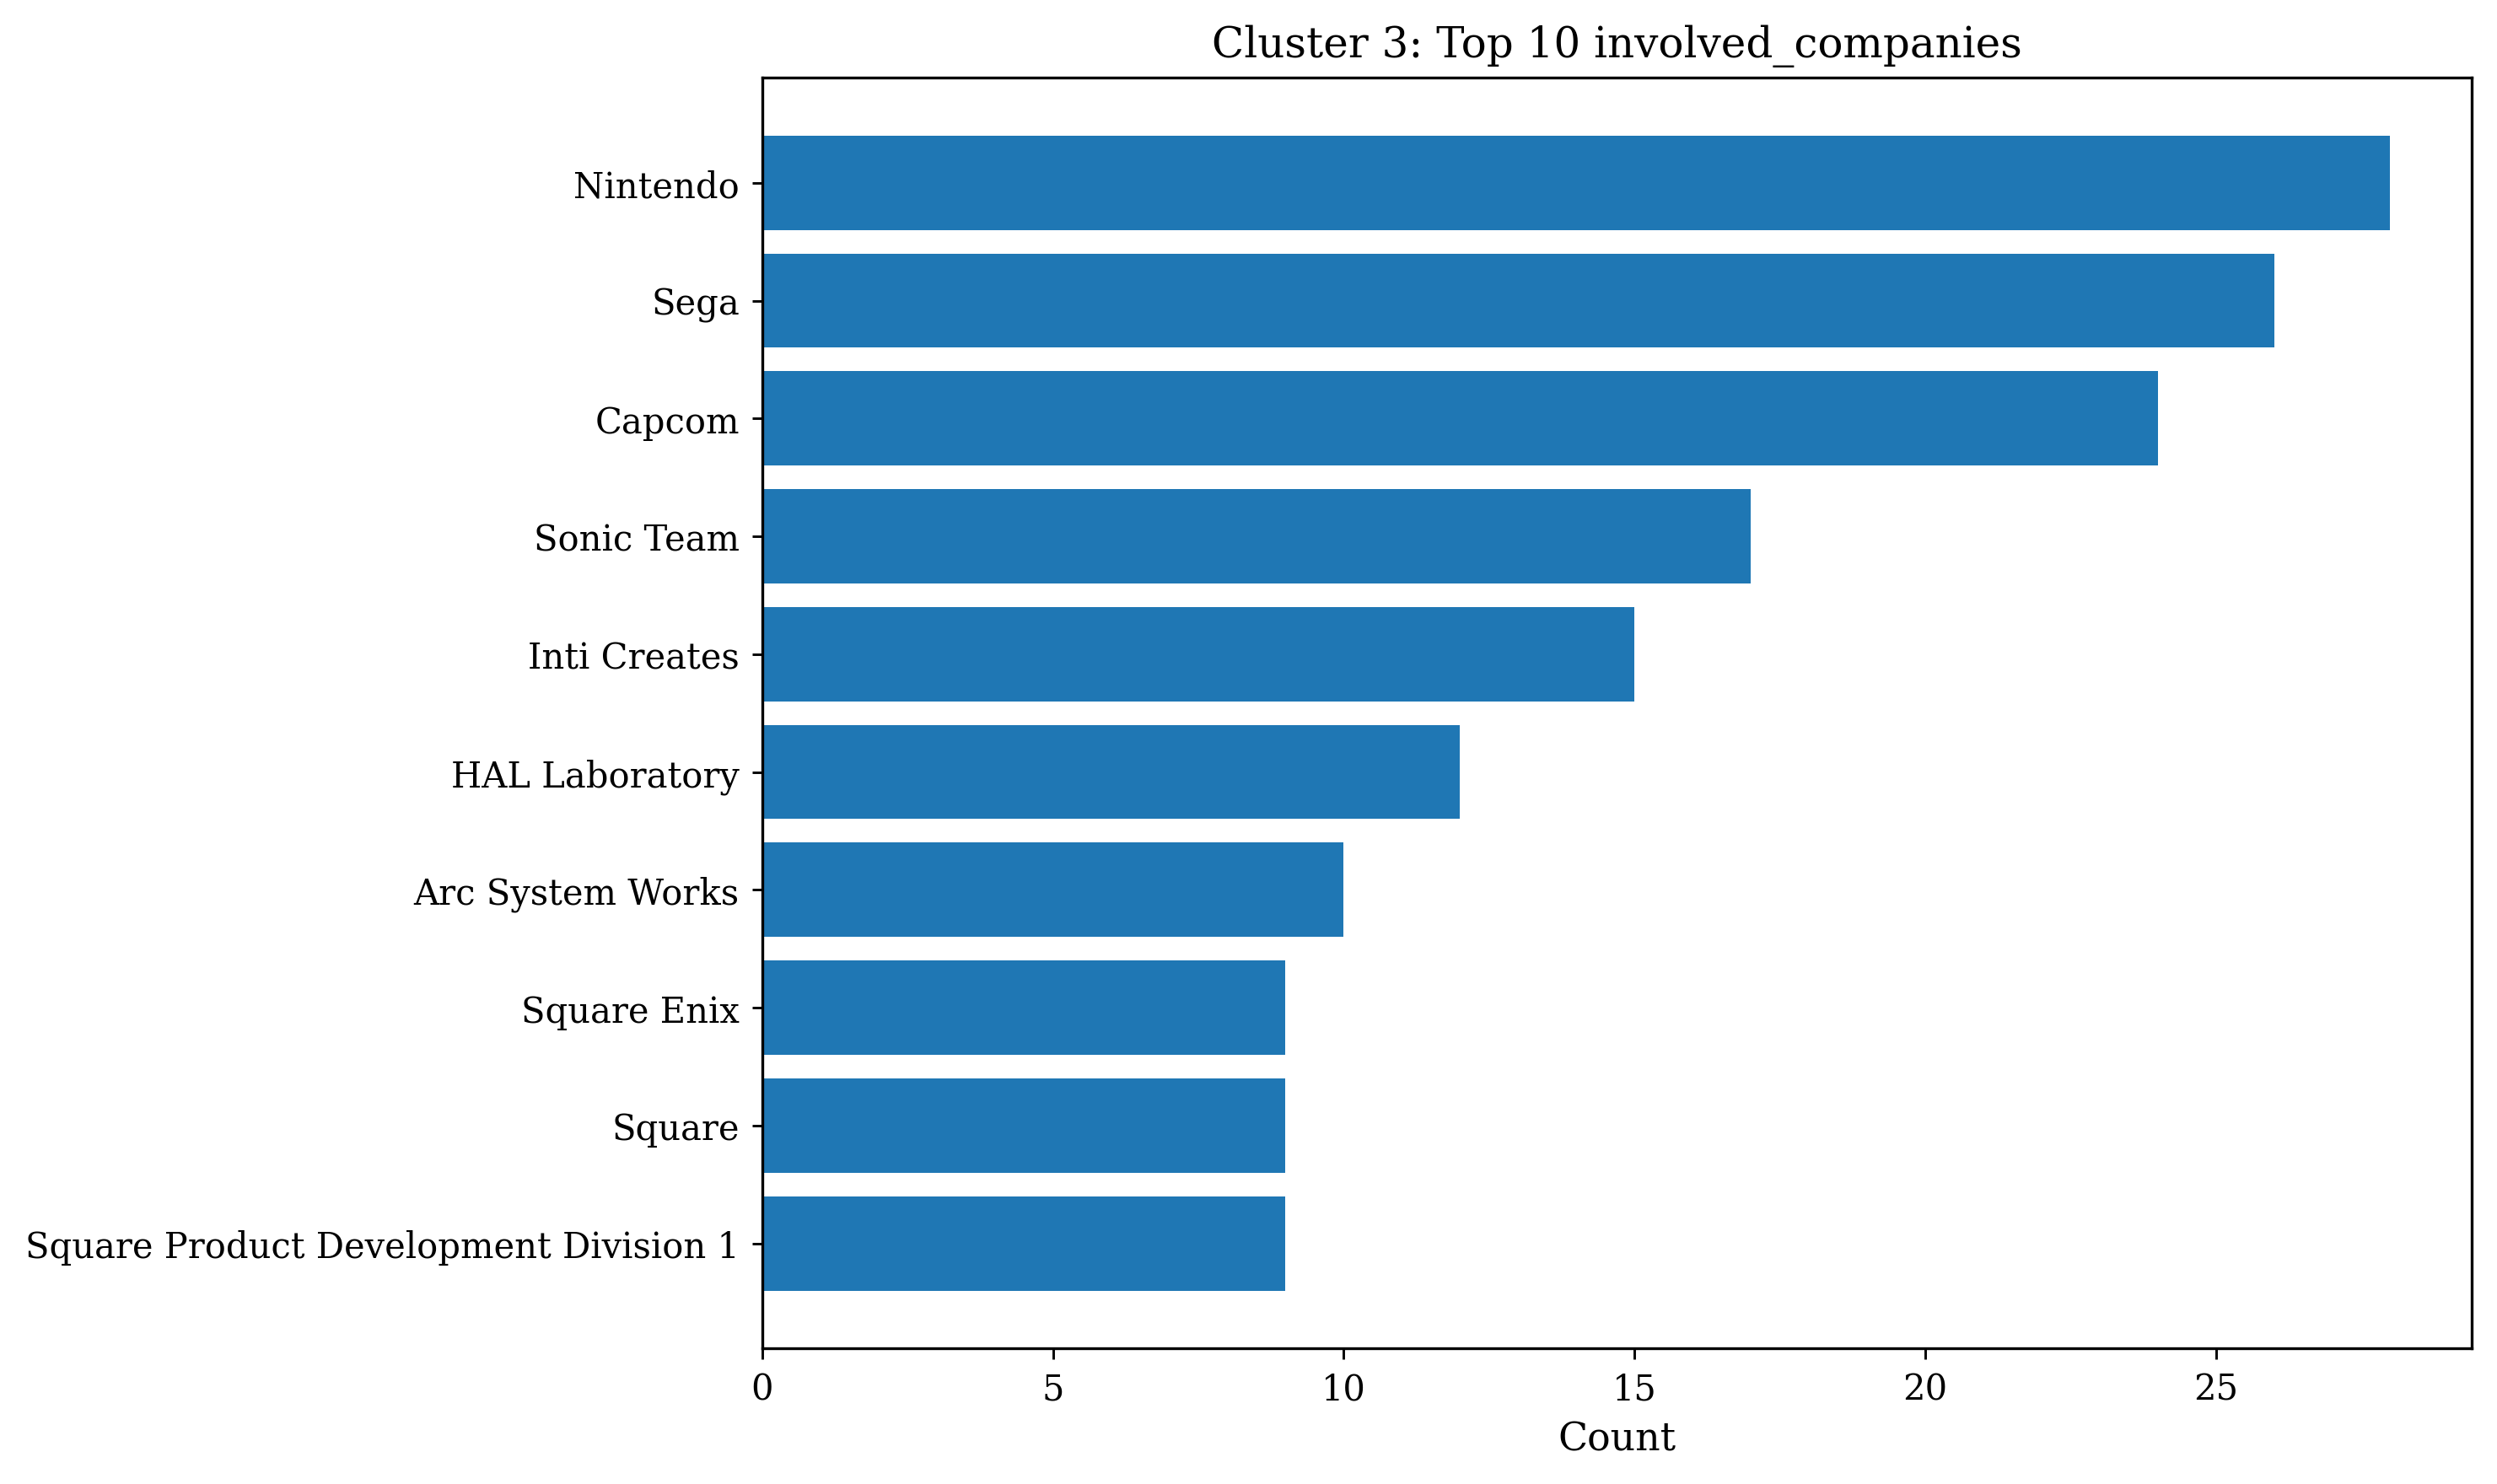

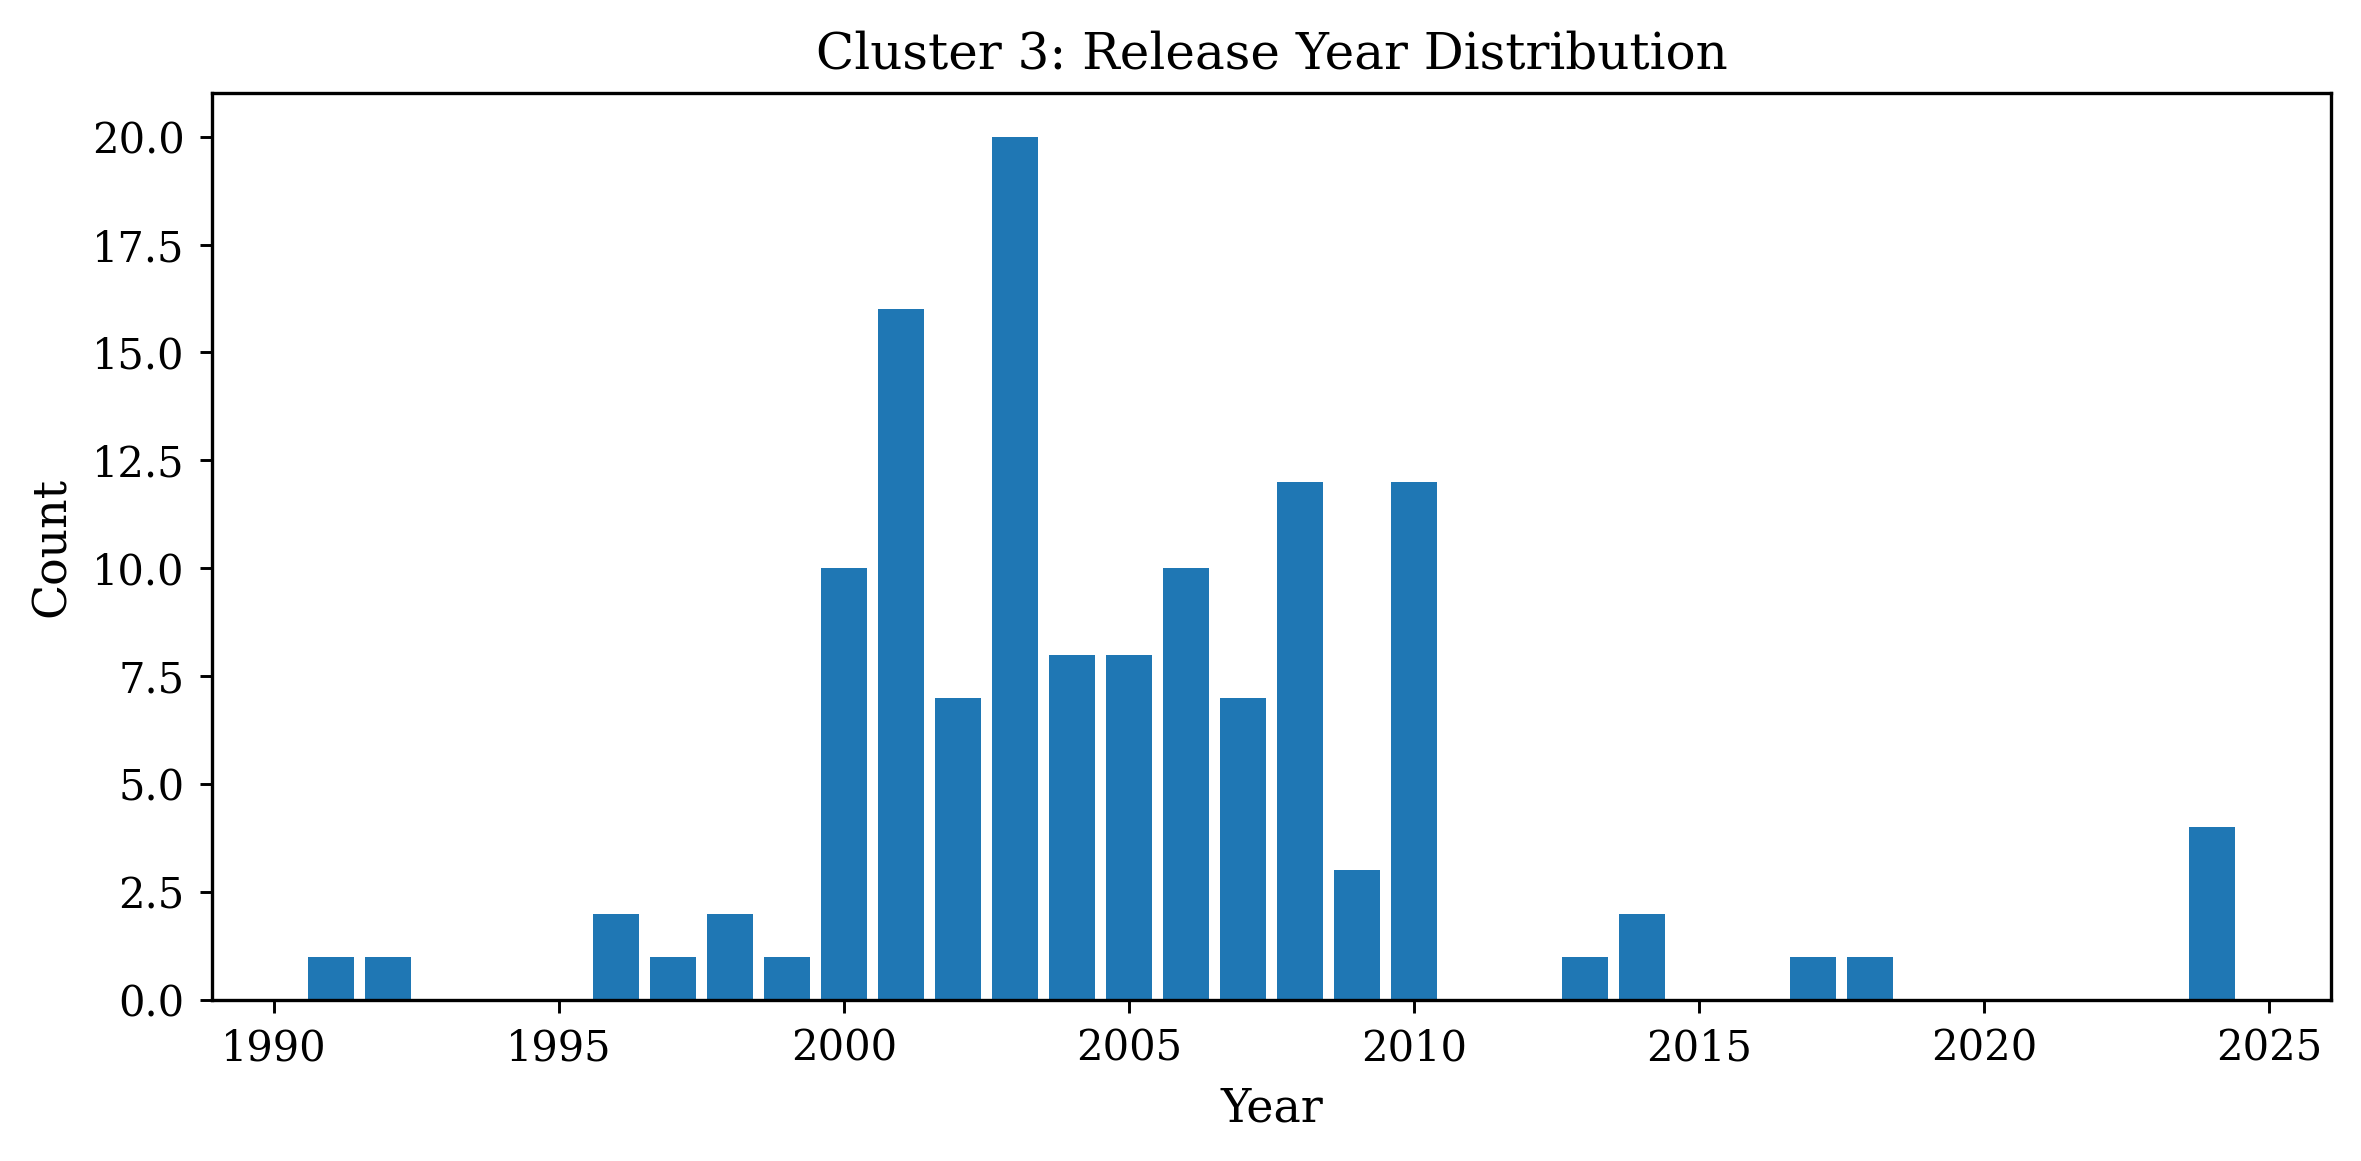


=== Cluster 4 ===


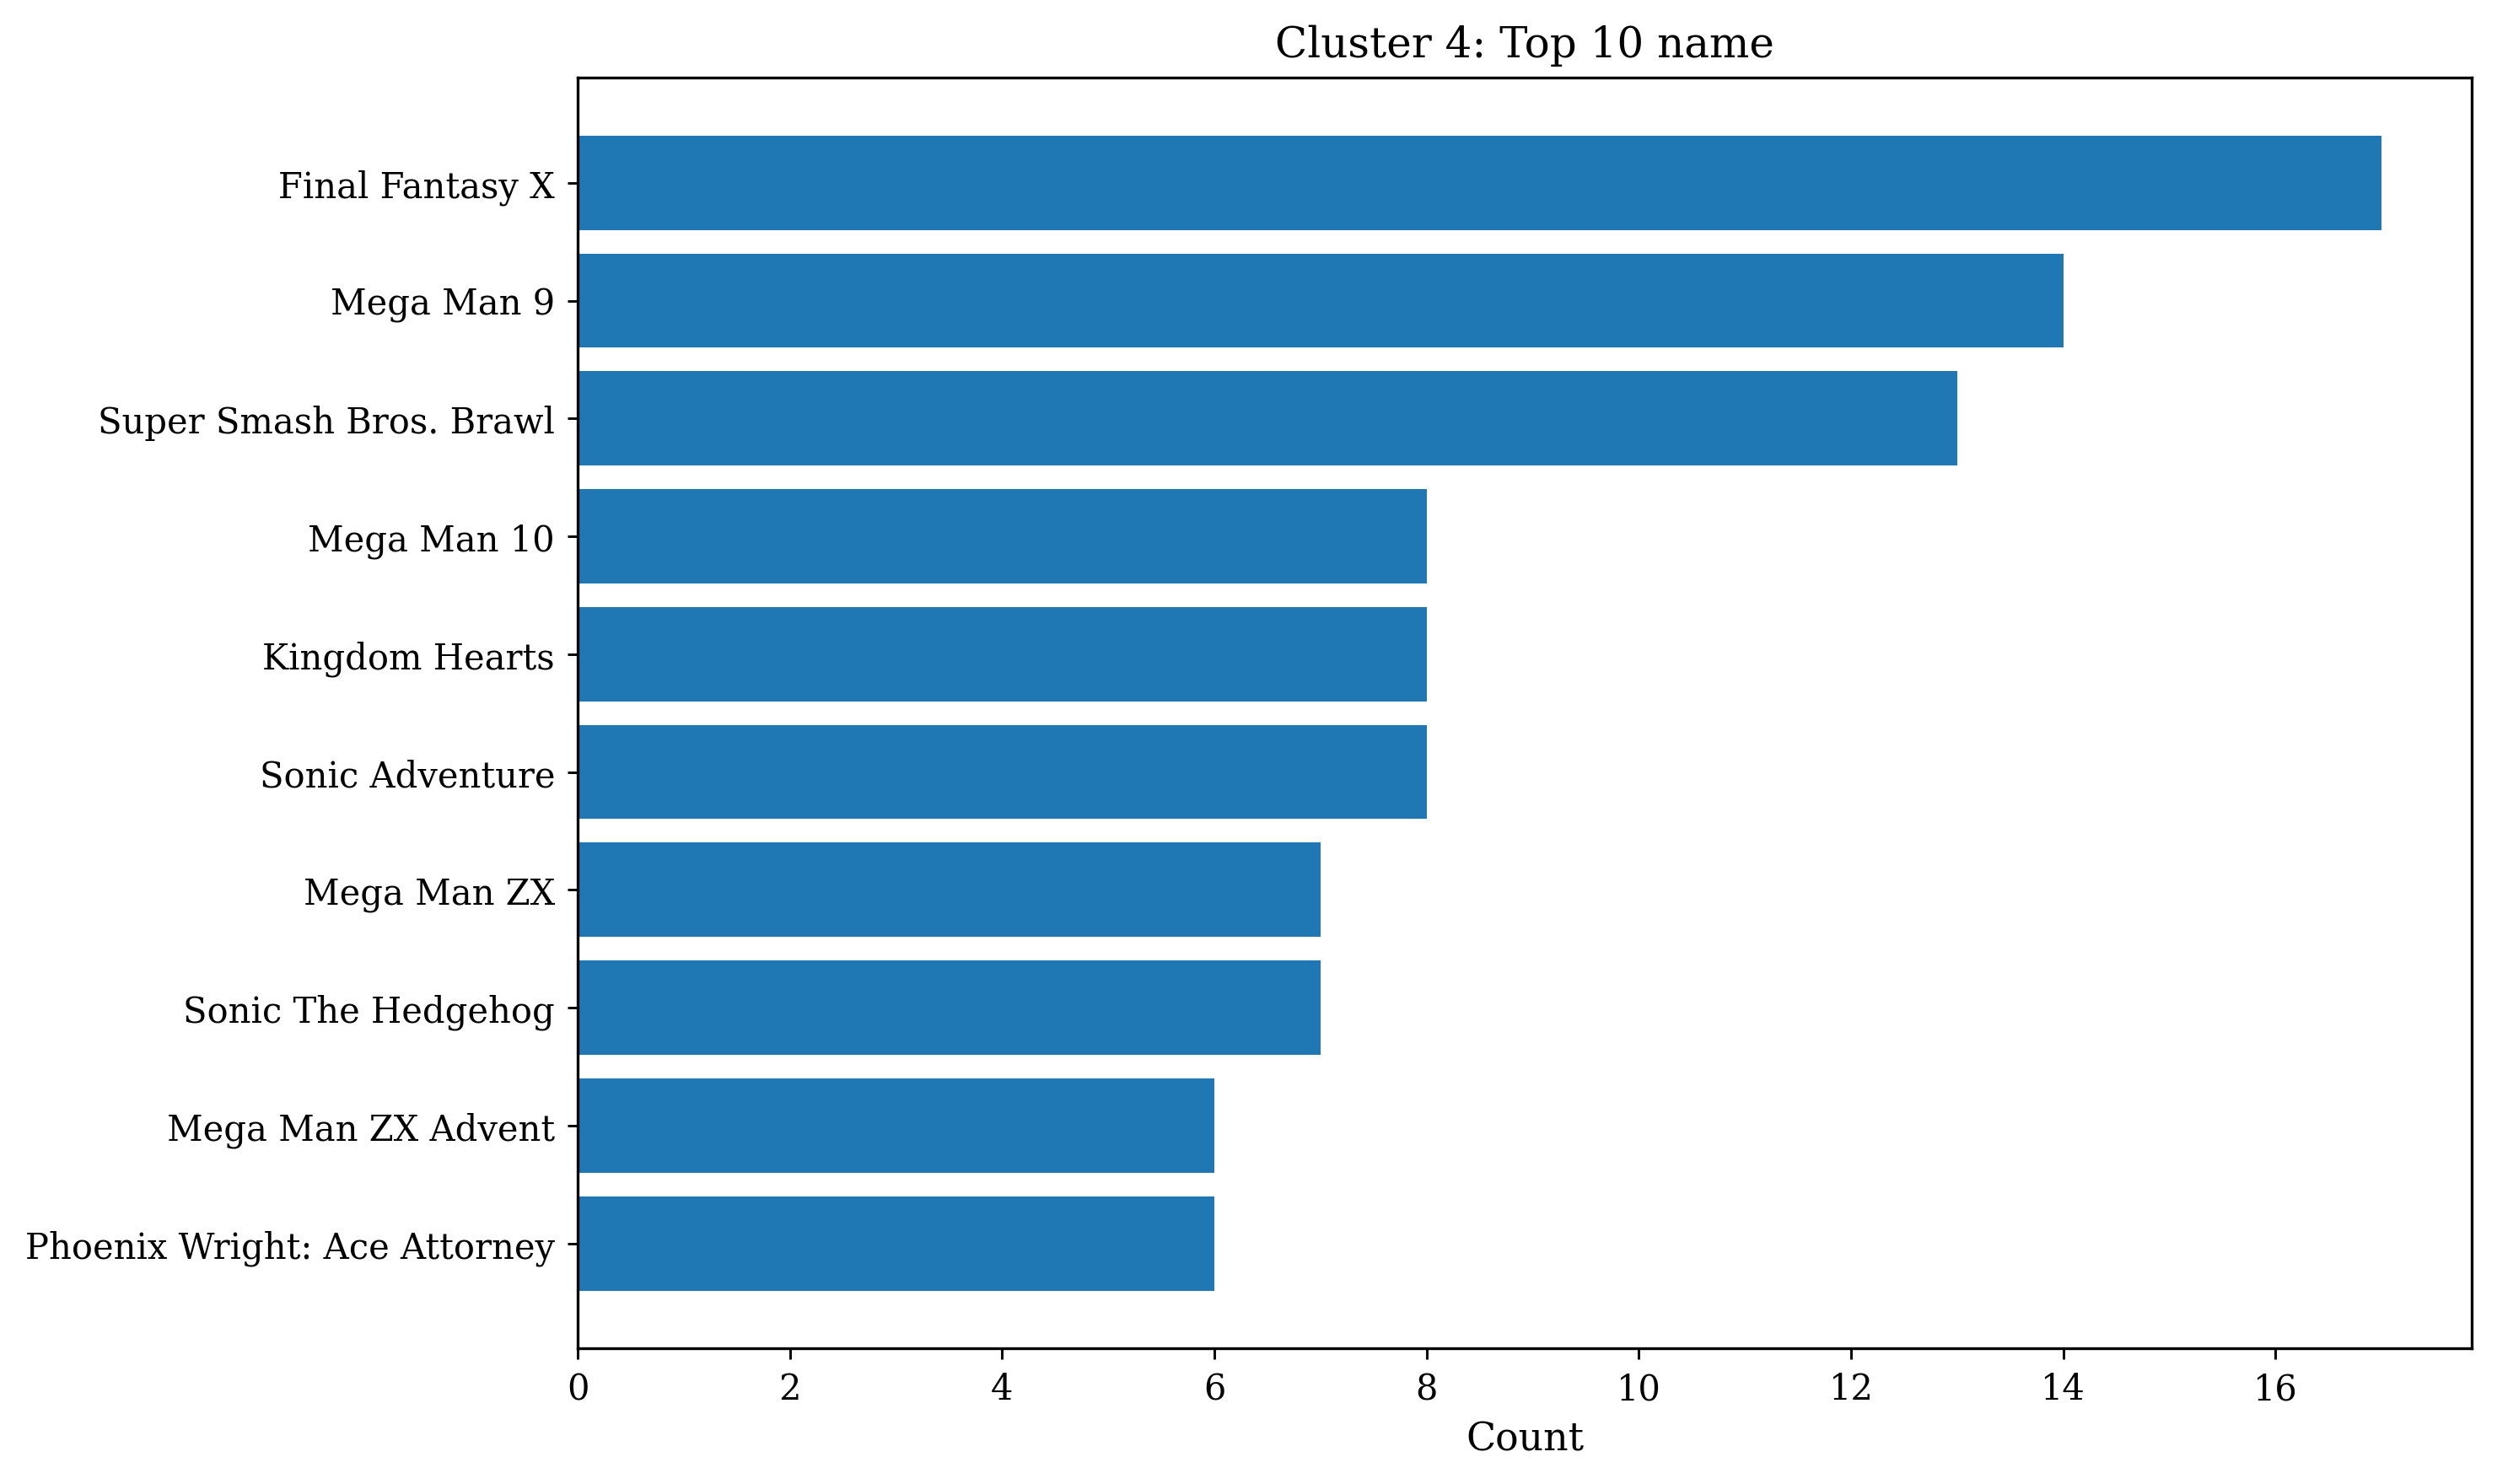

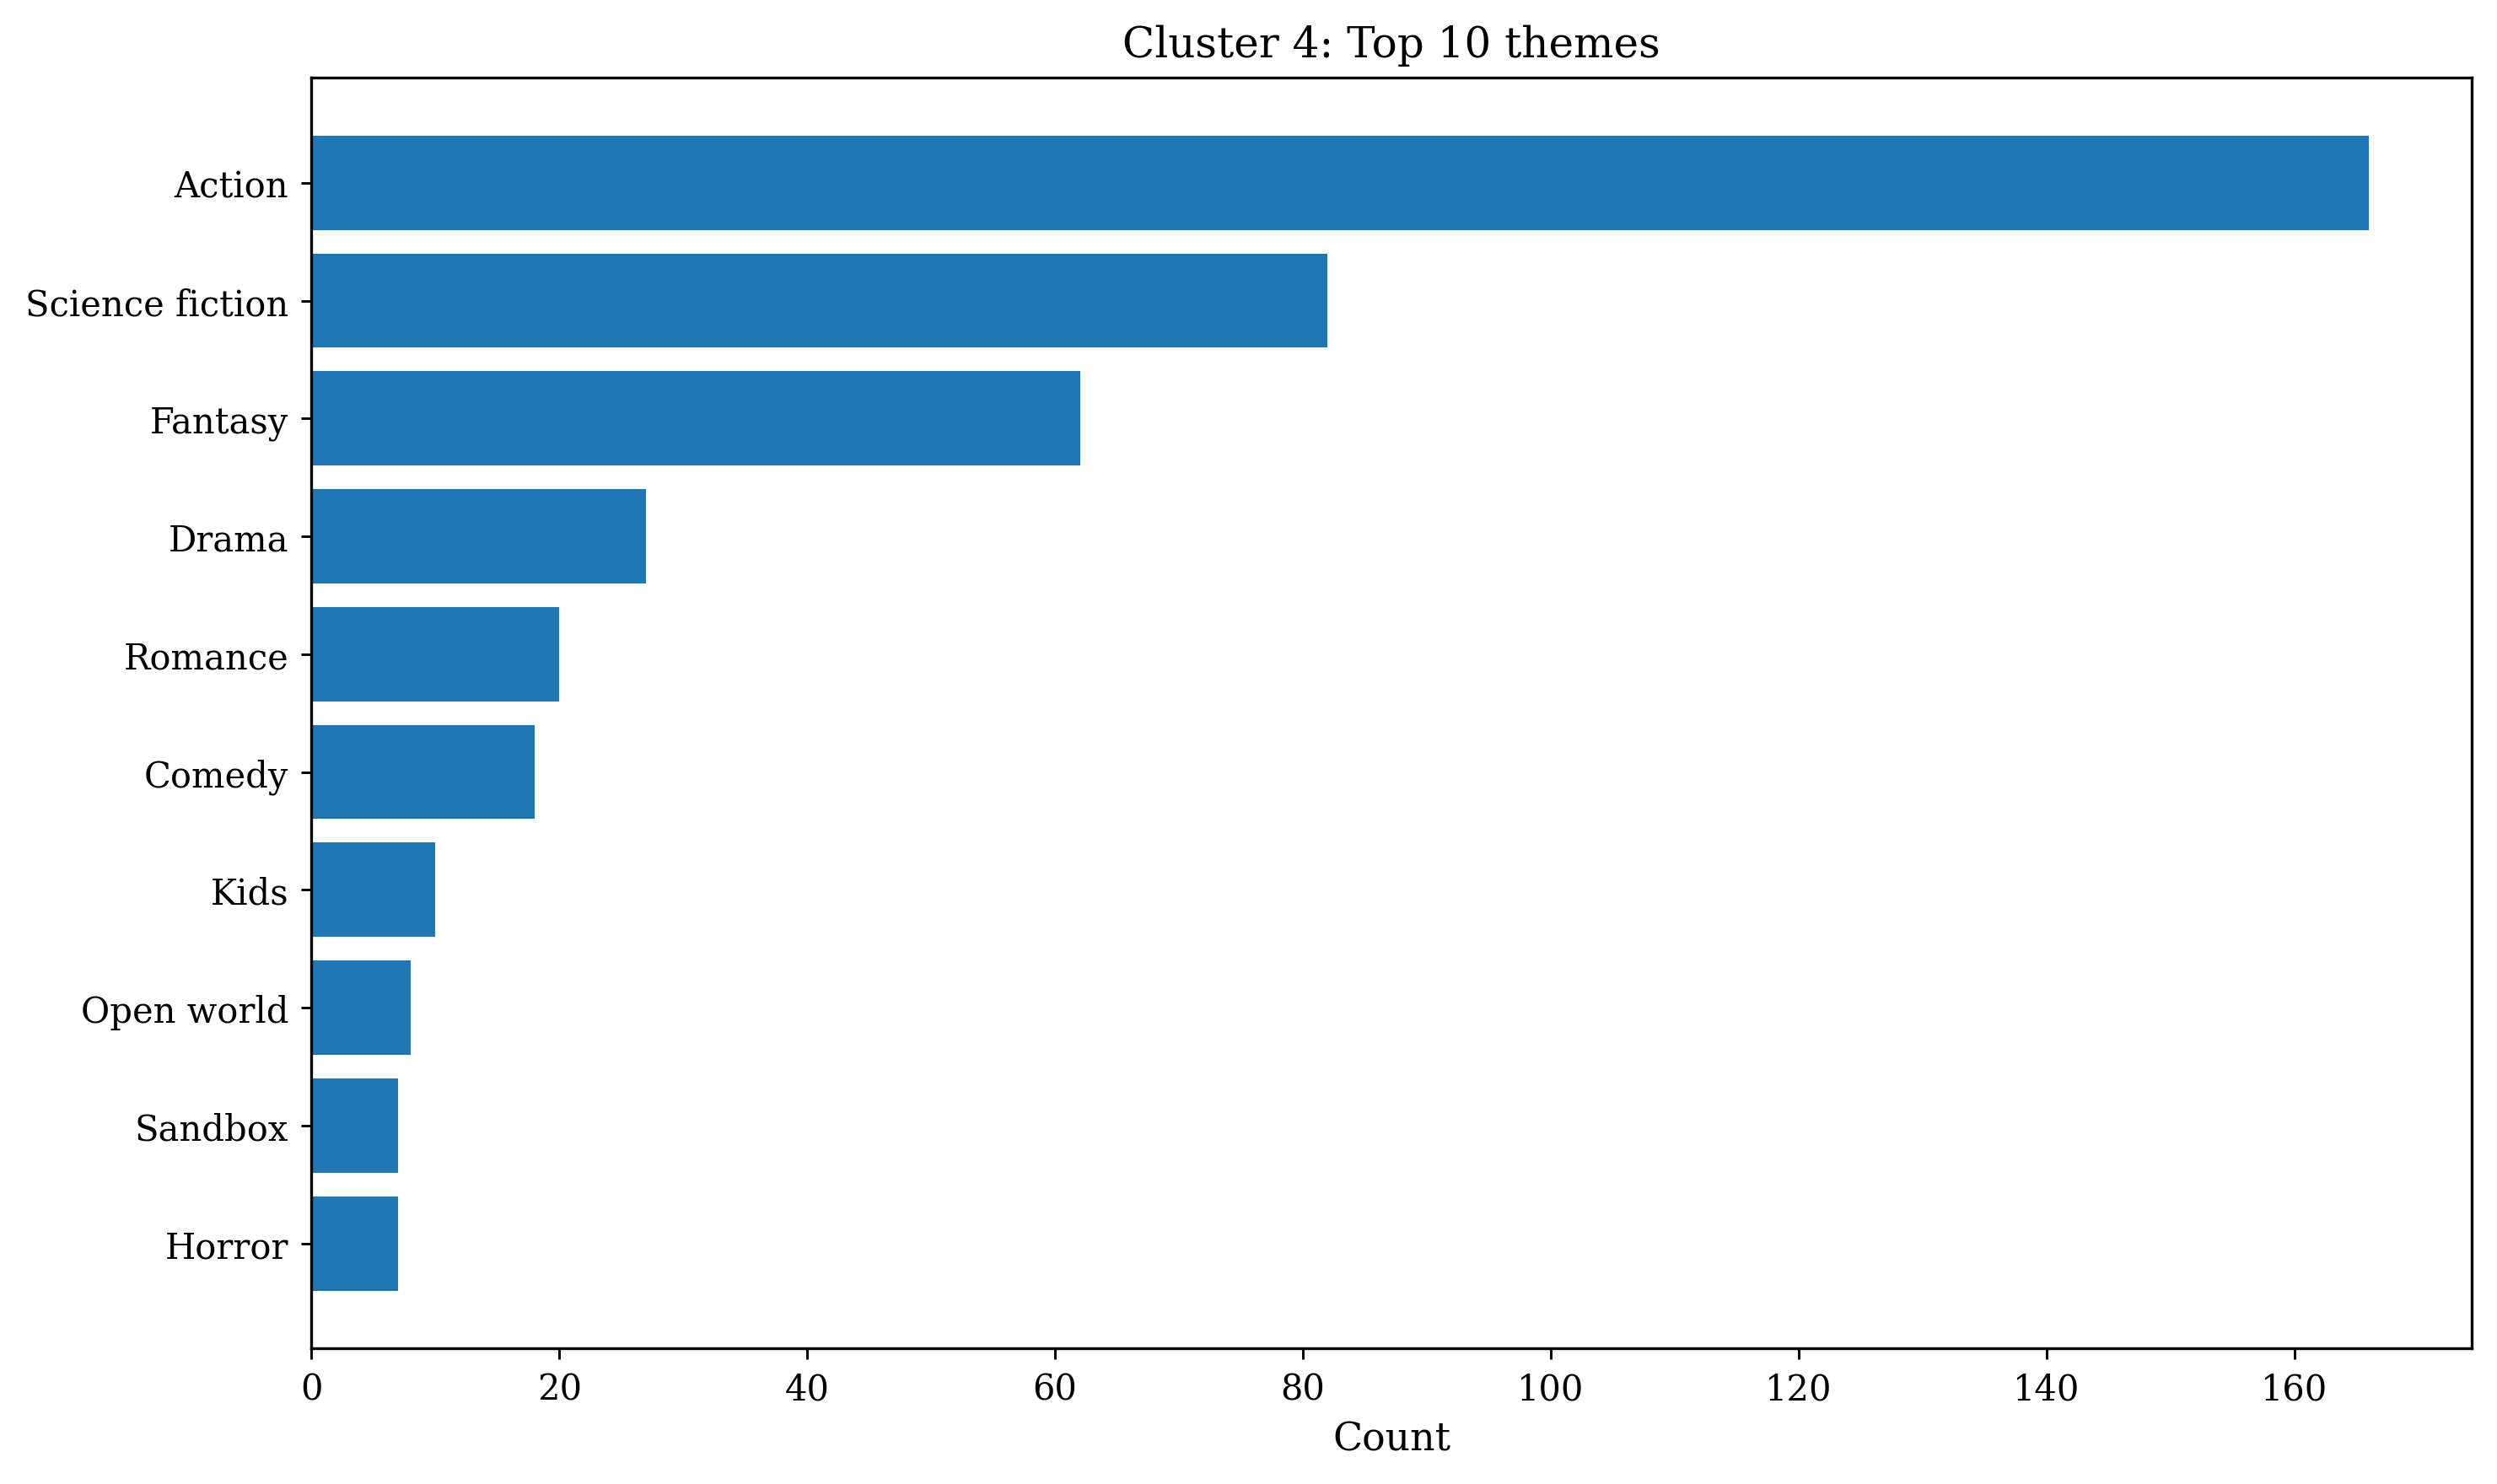

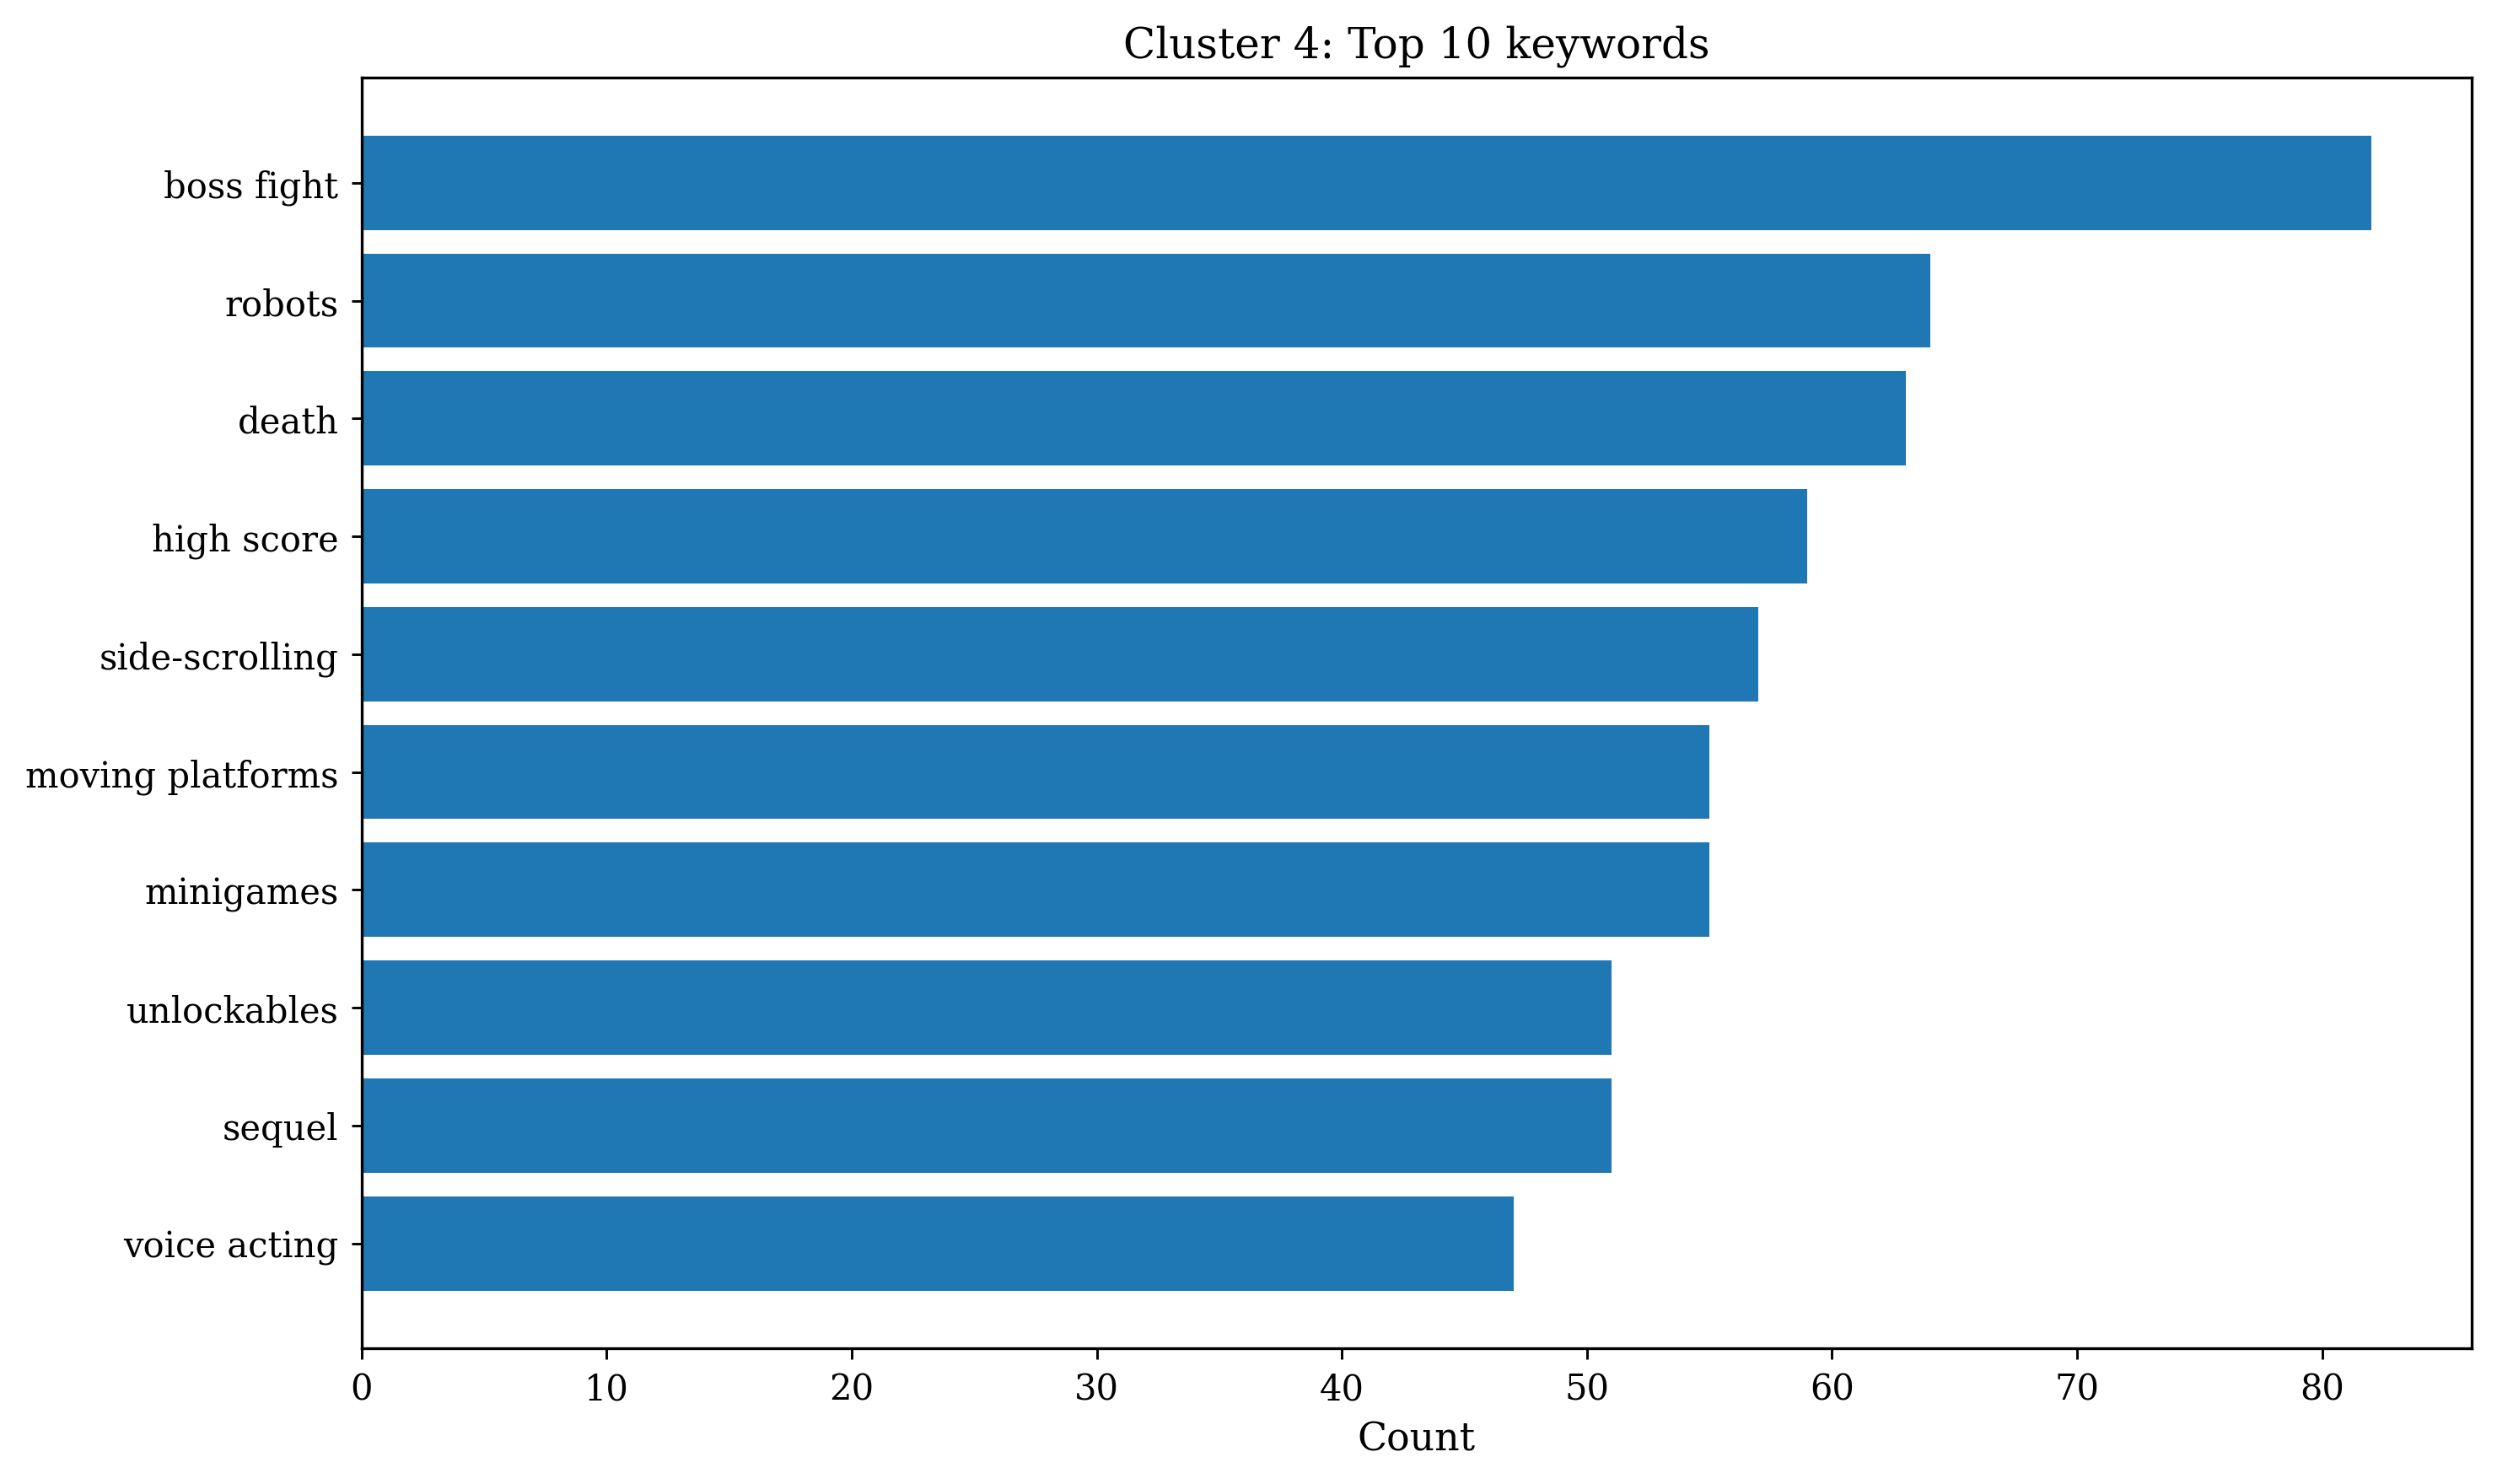

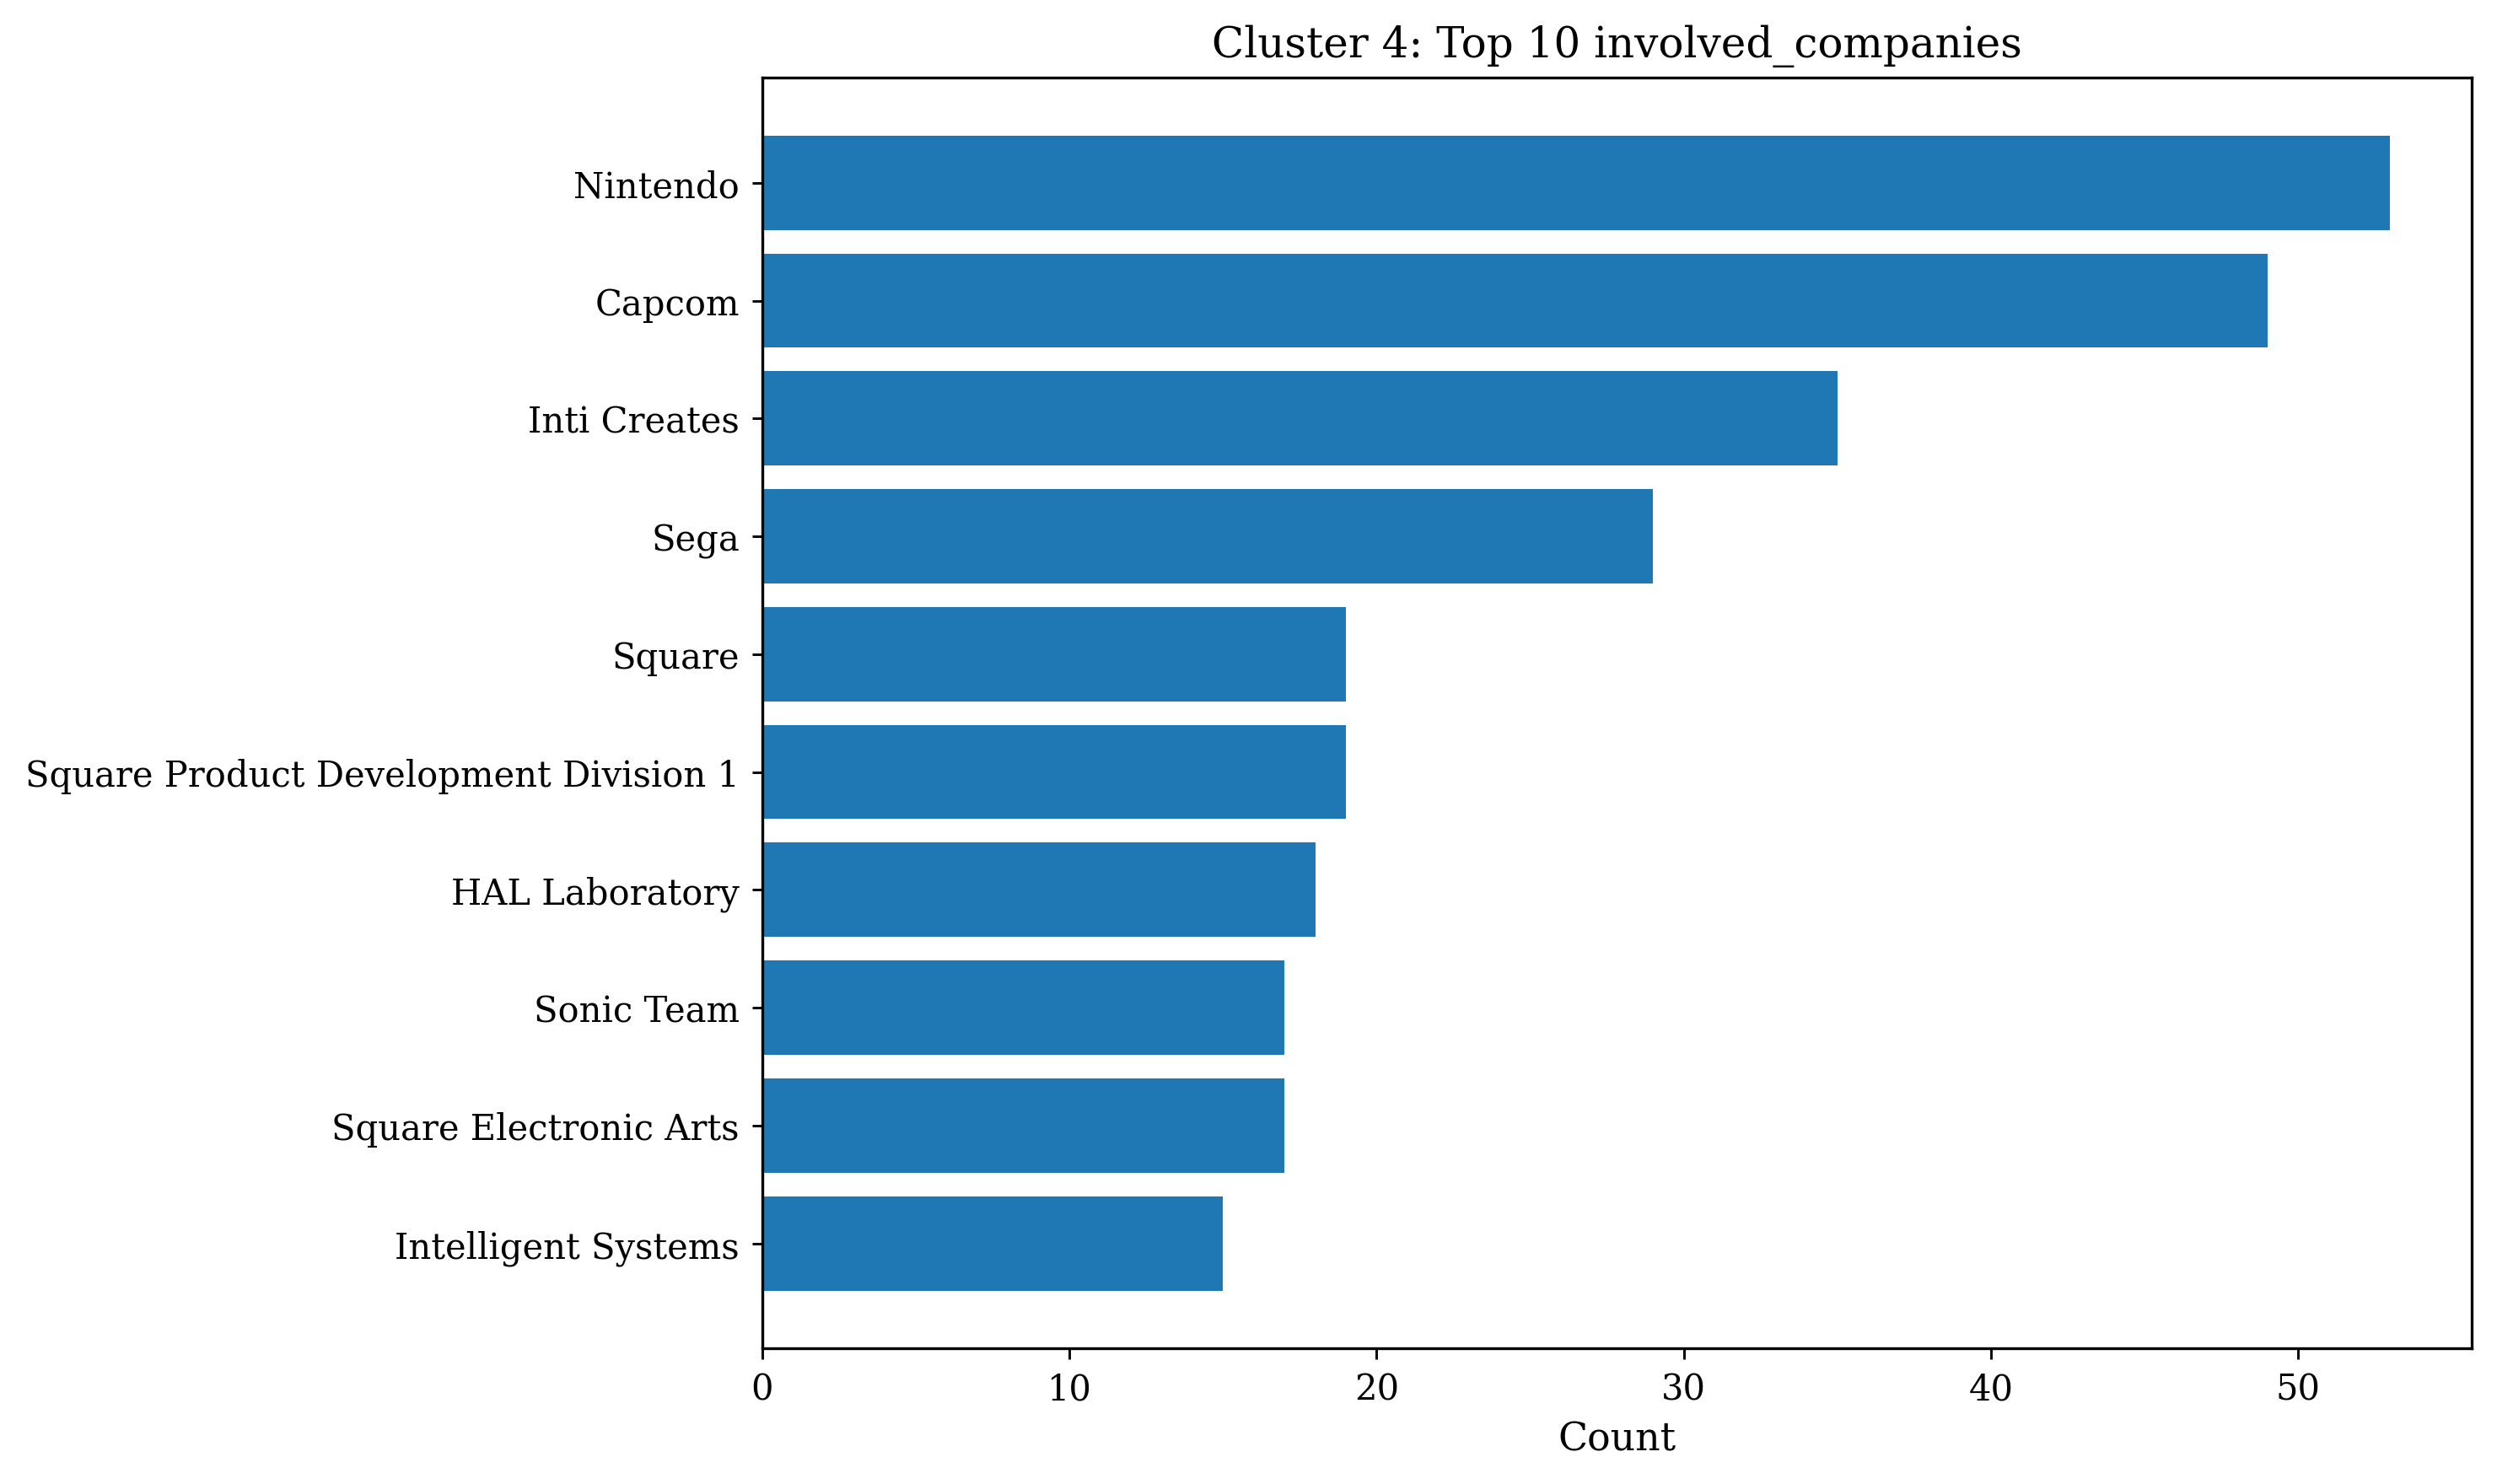

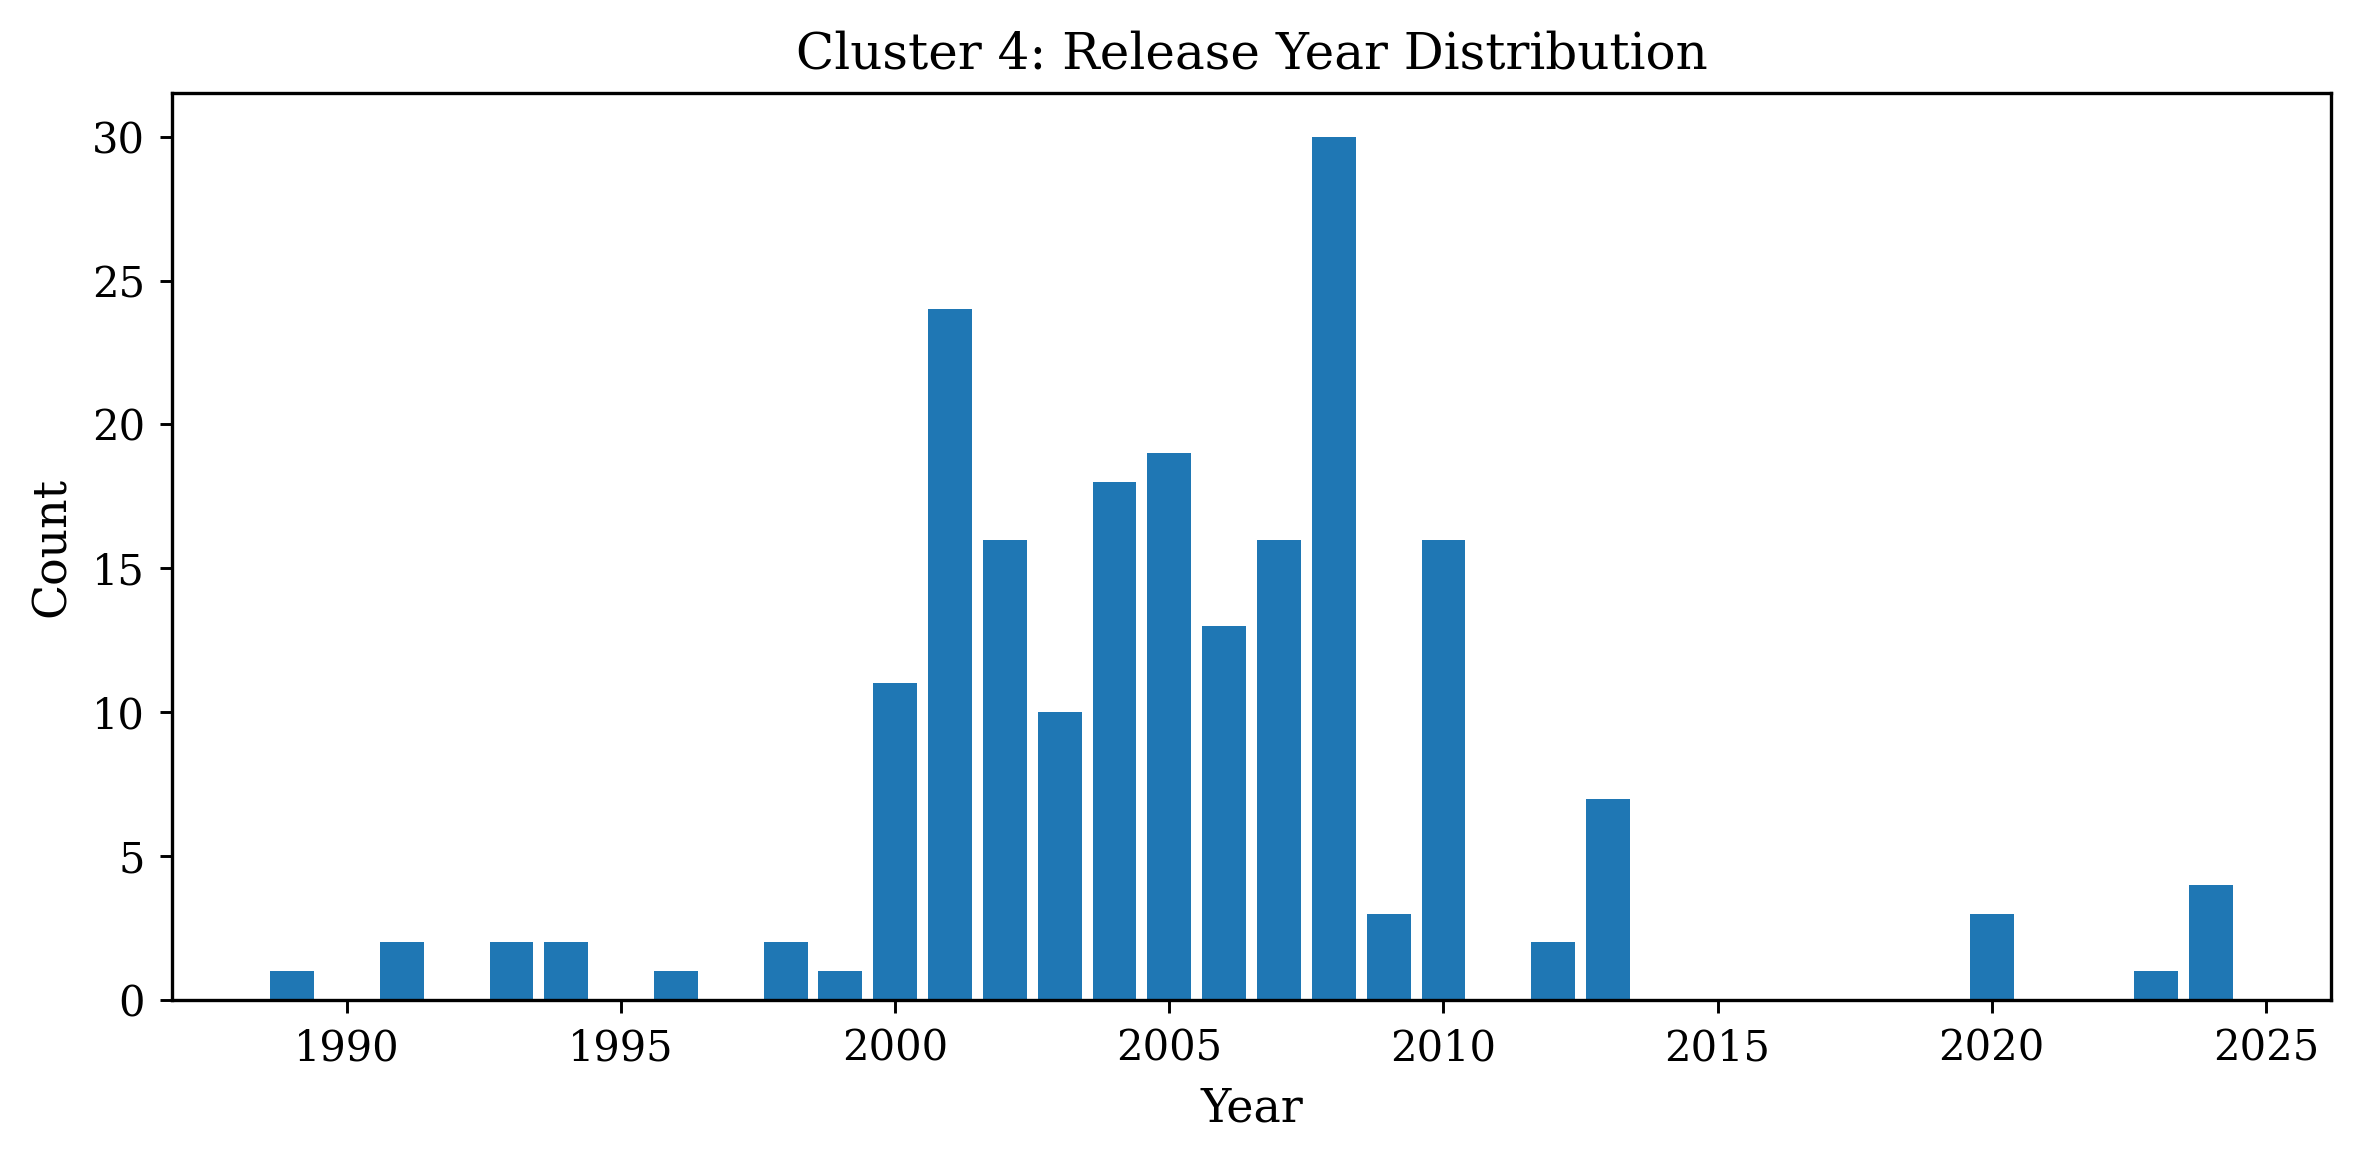


=== Cluster 5 ===


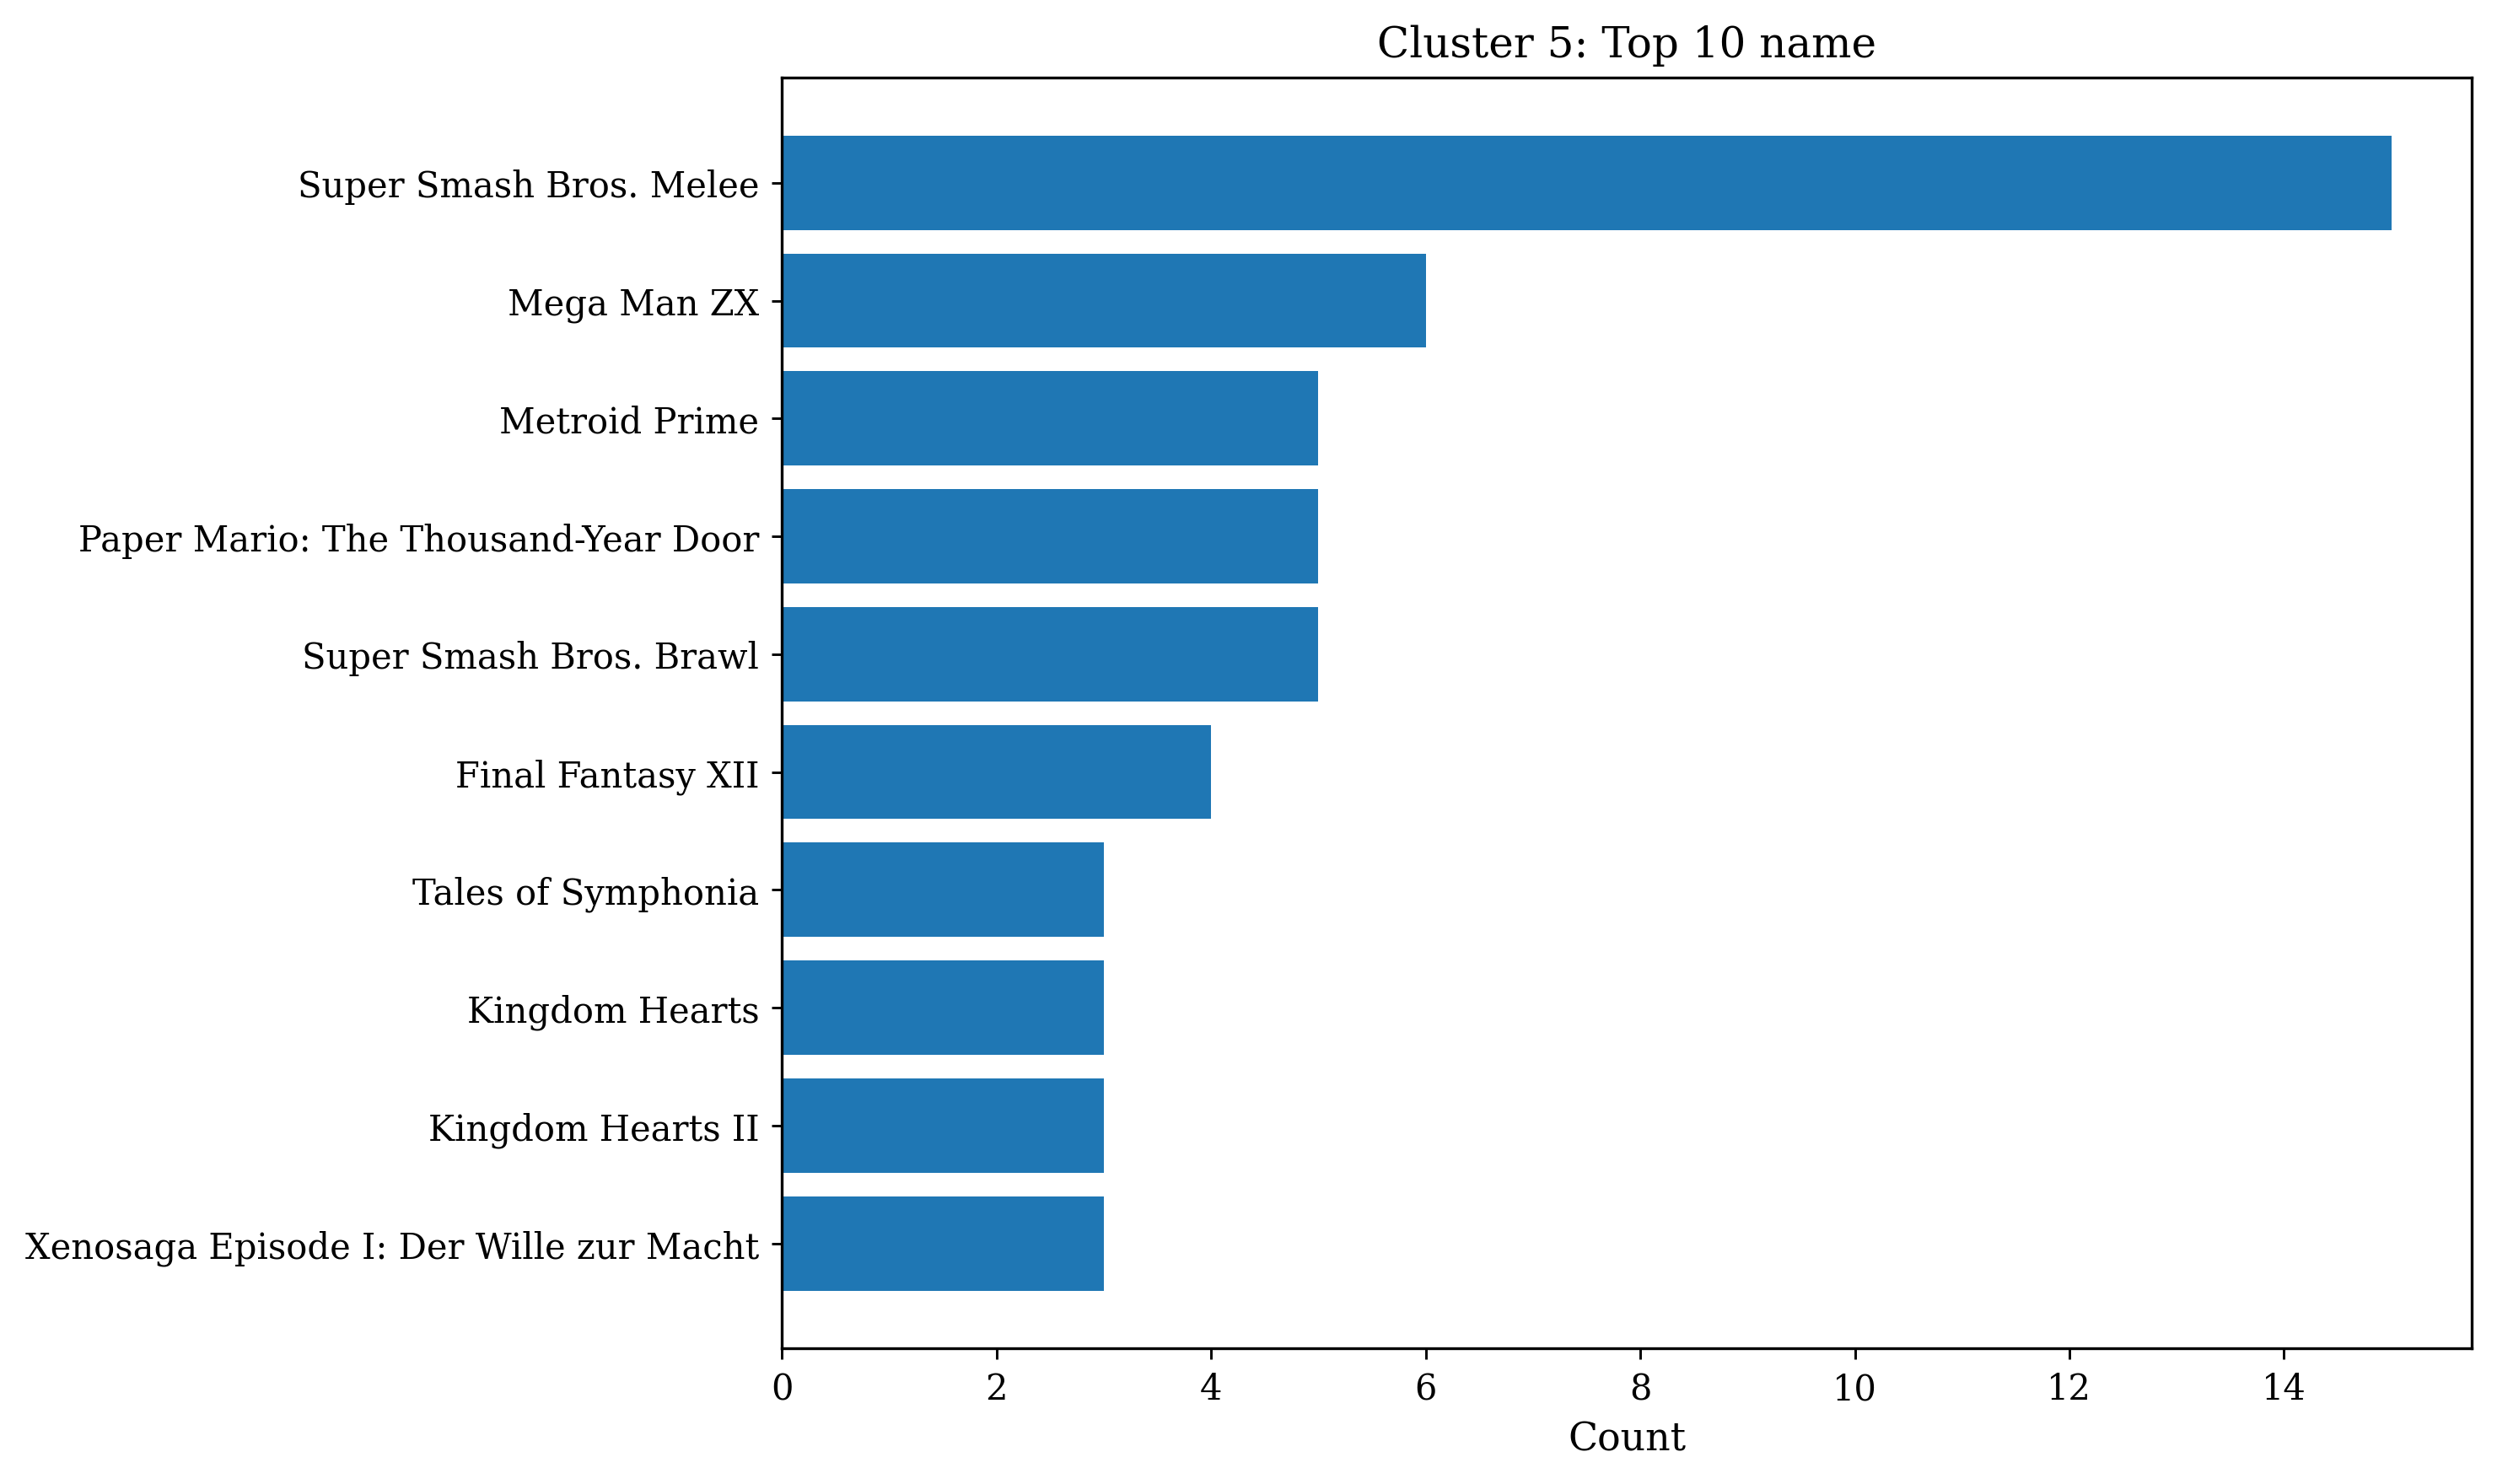

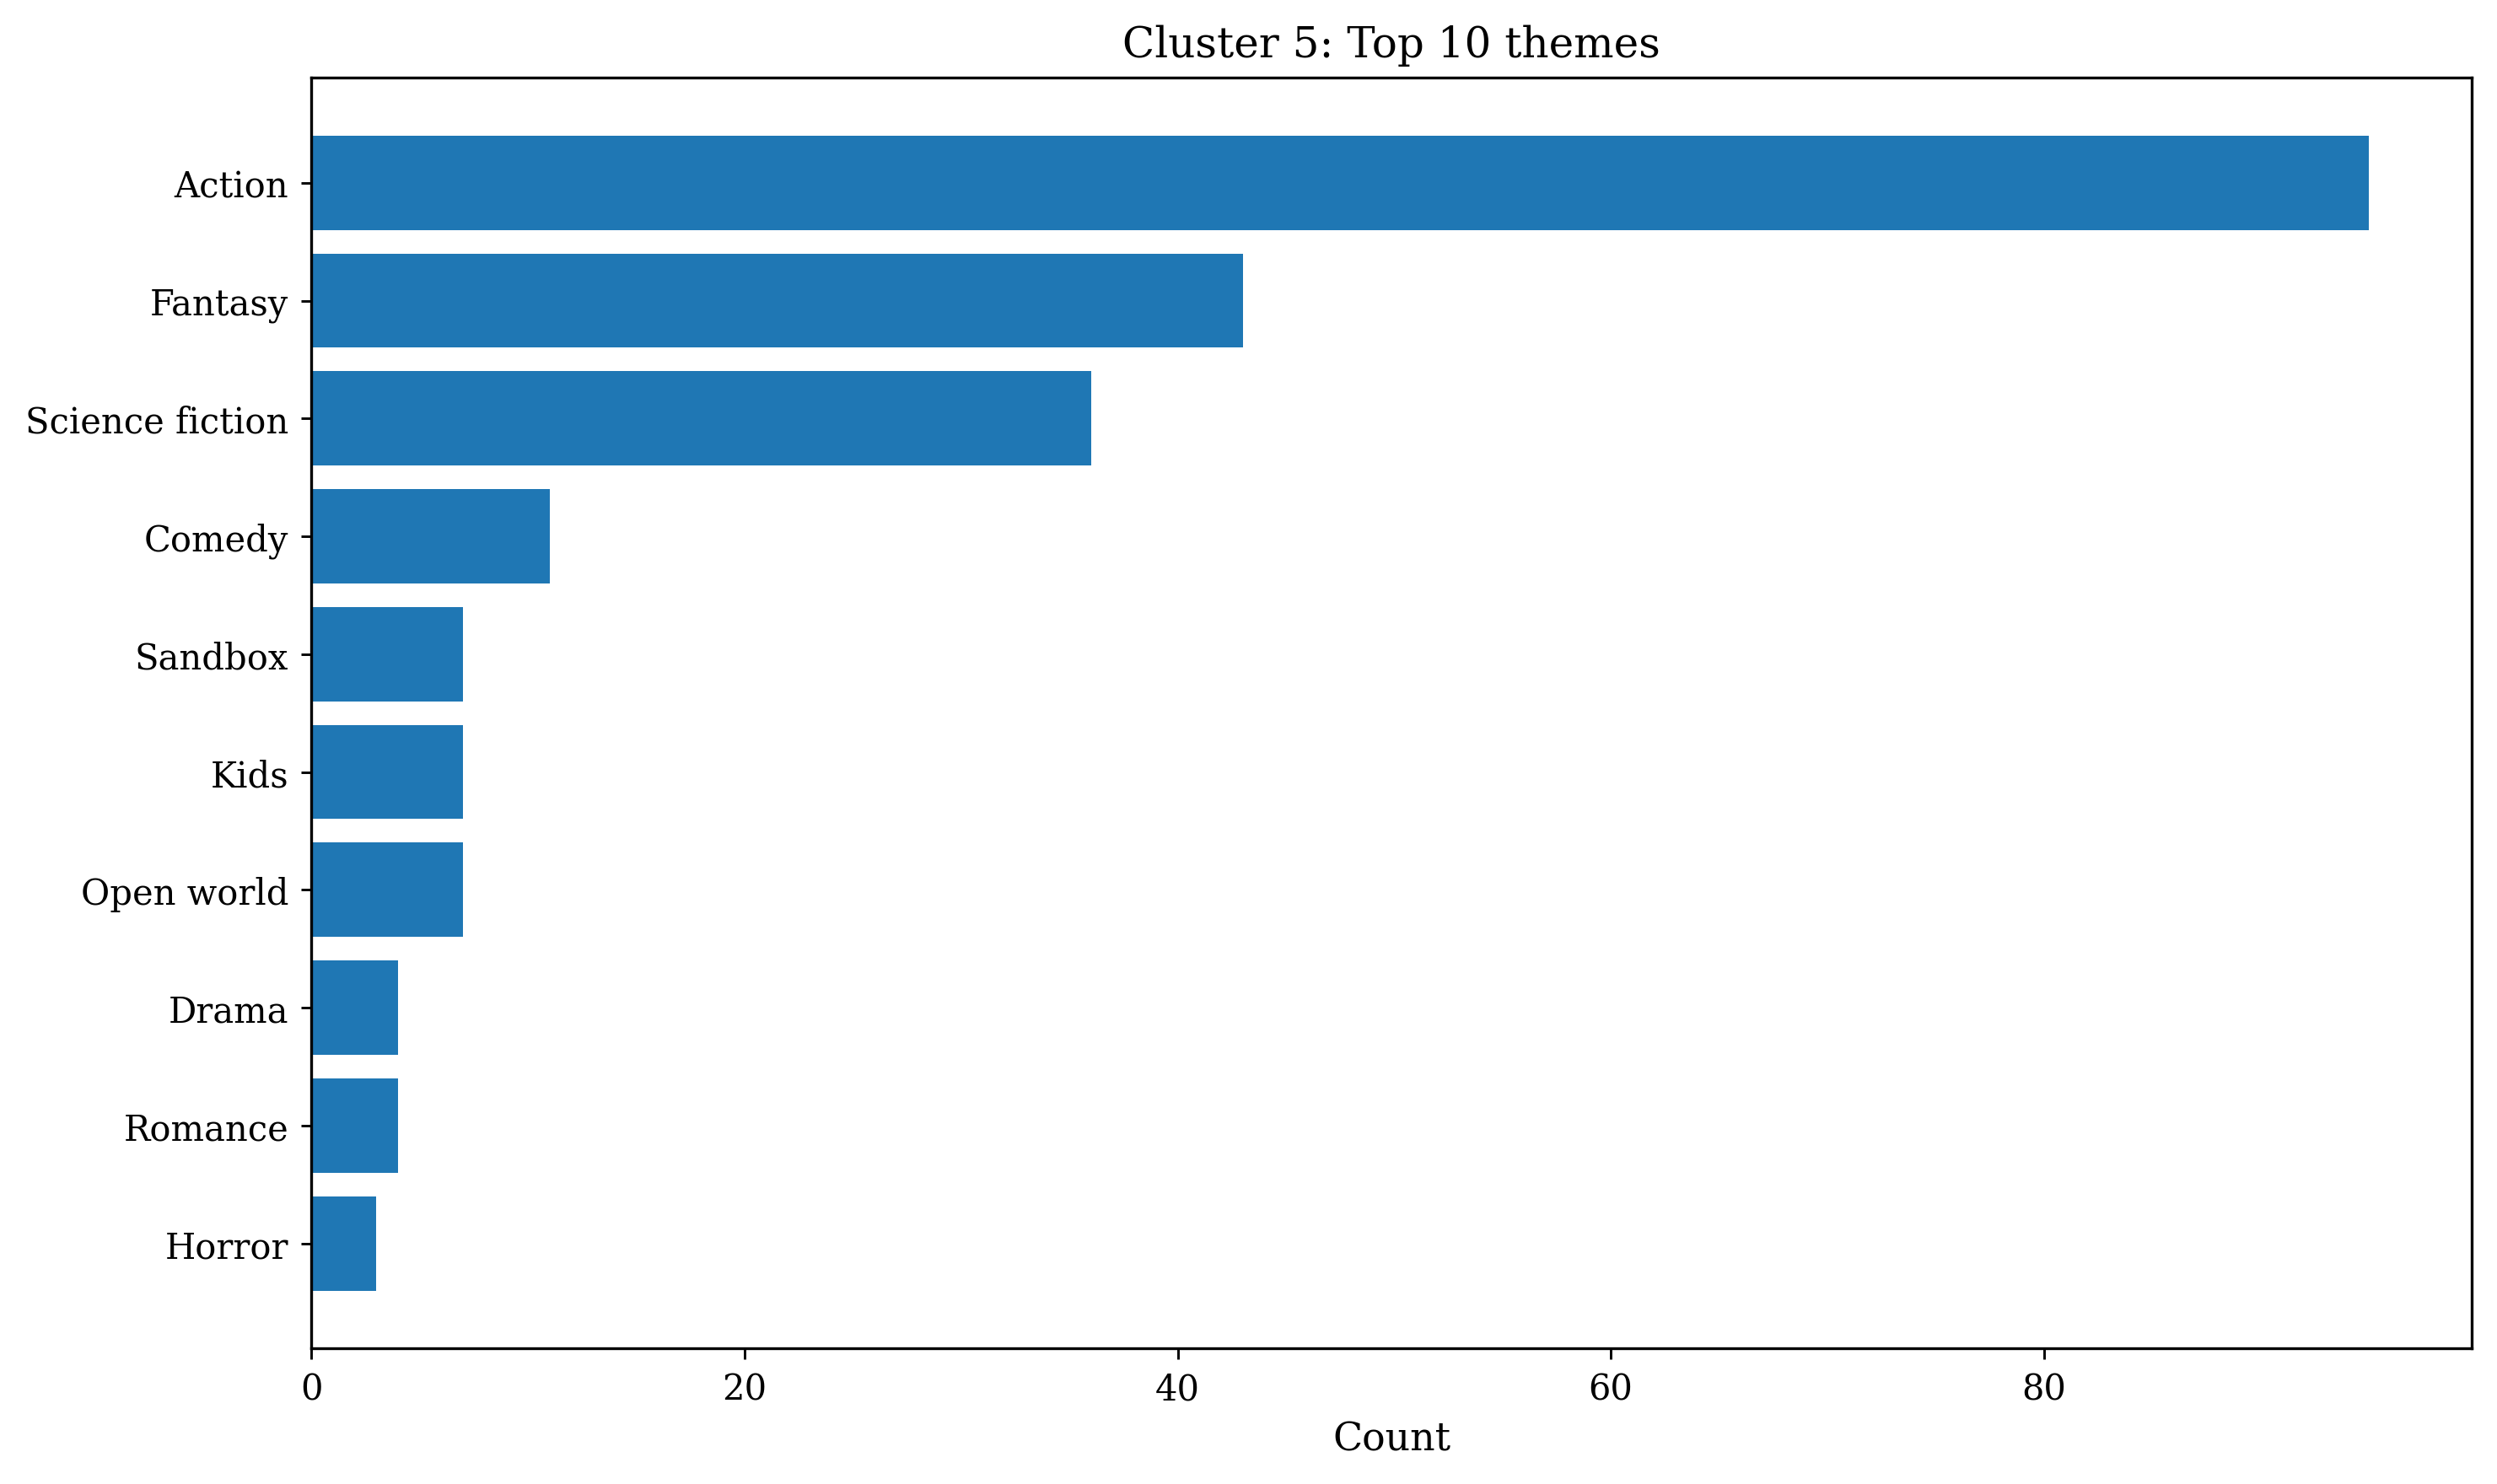

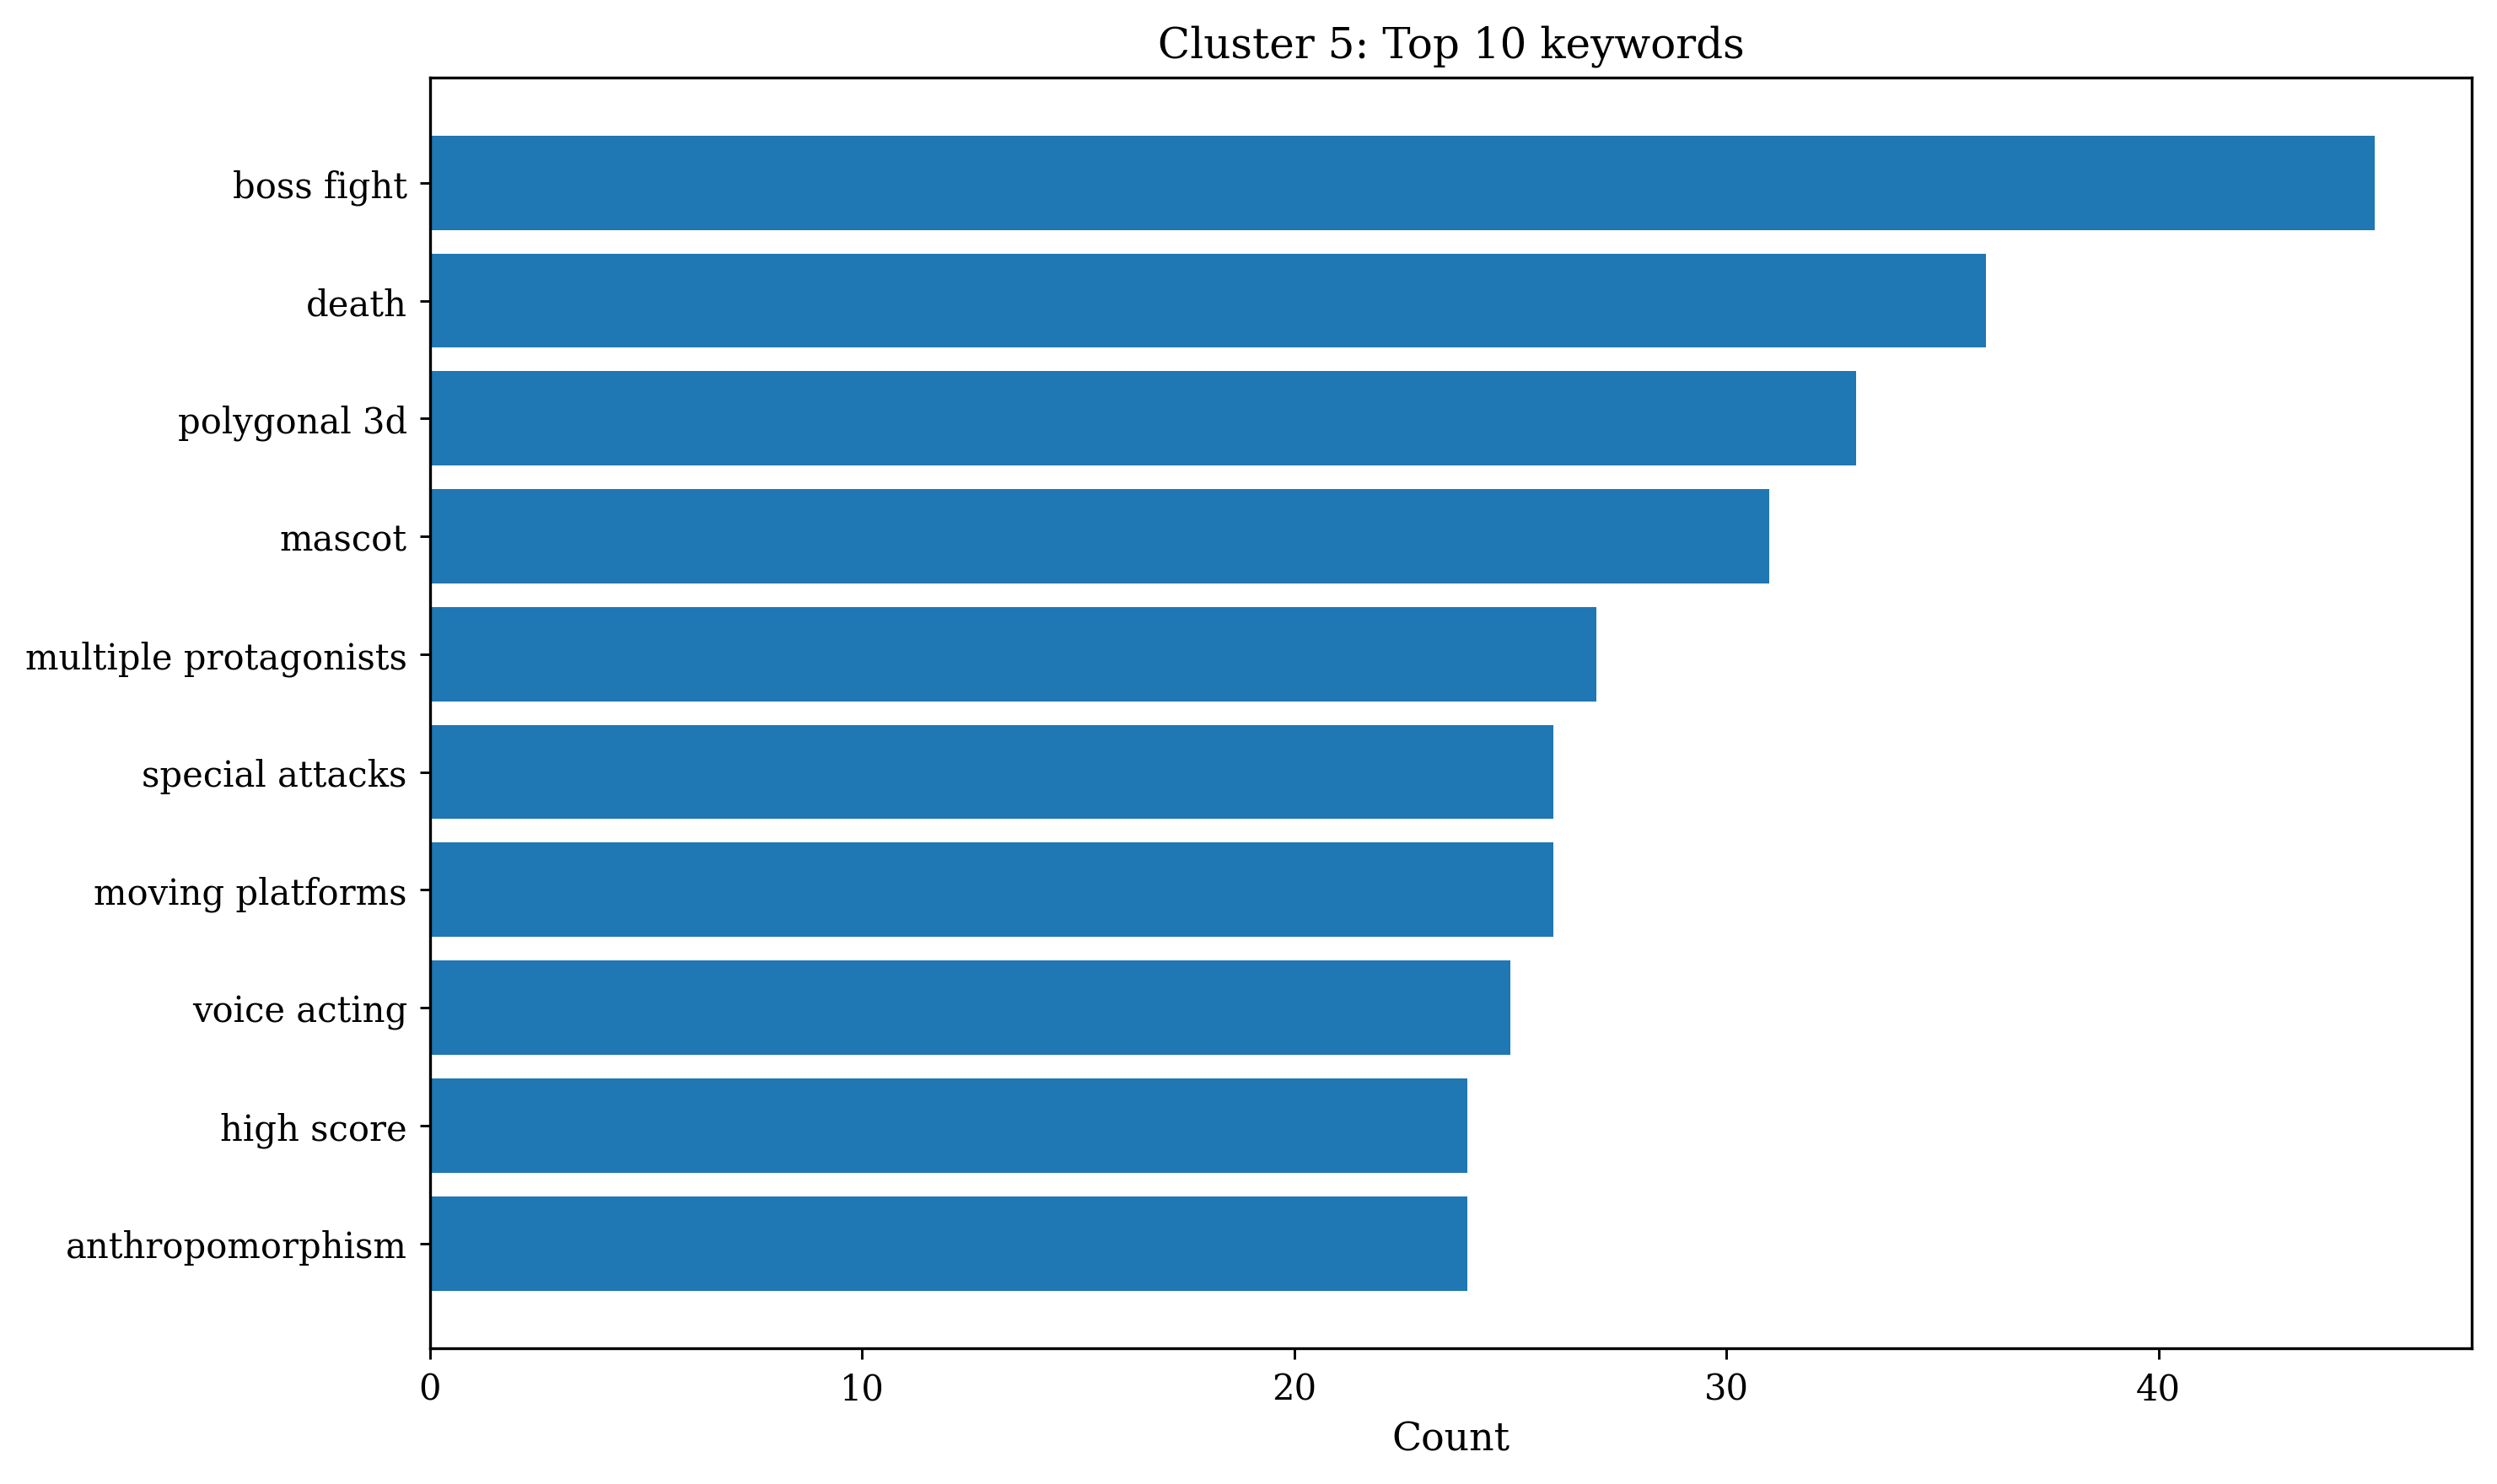

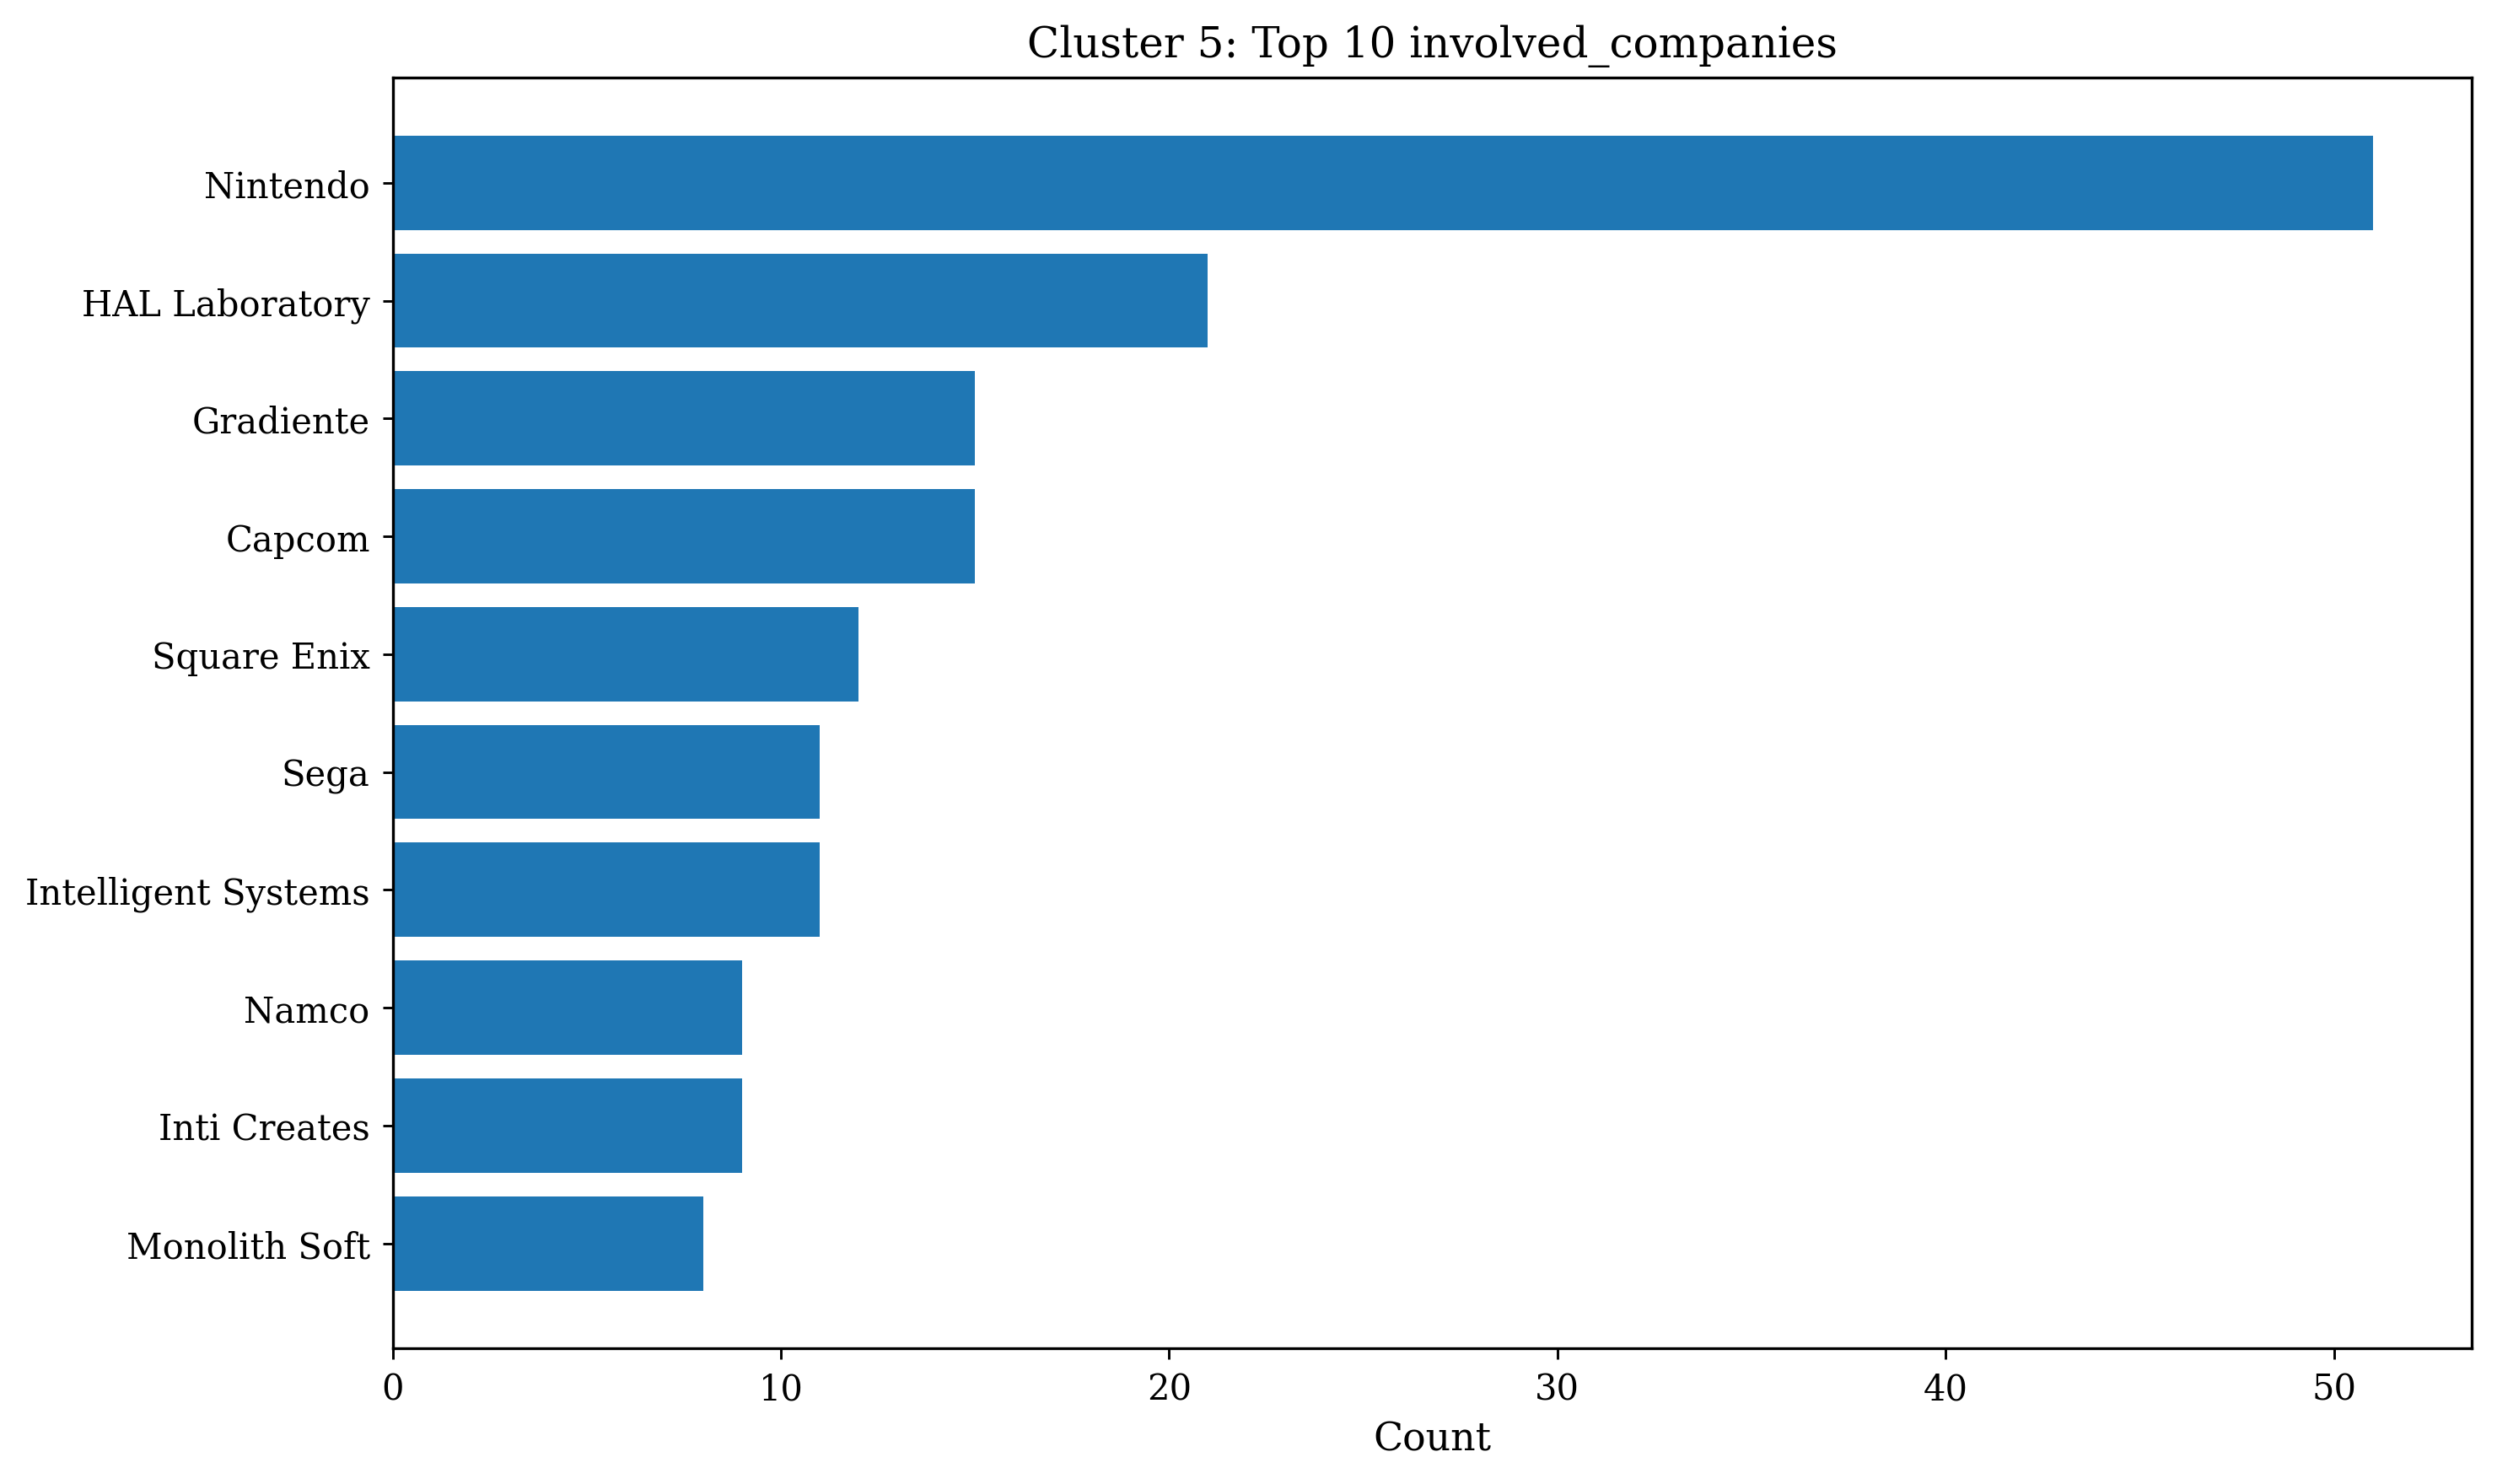

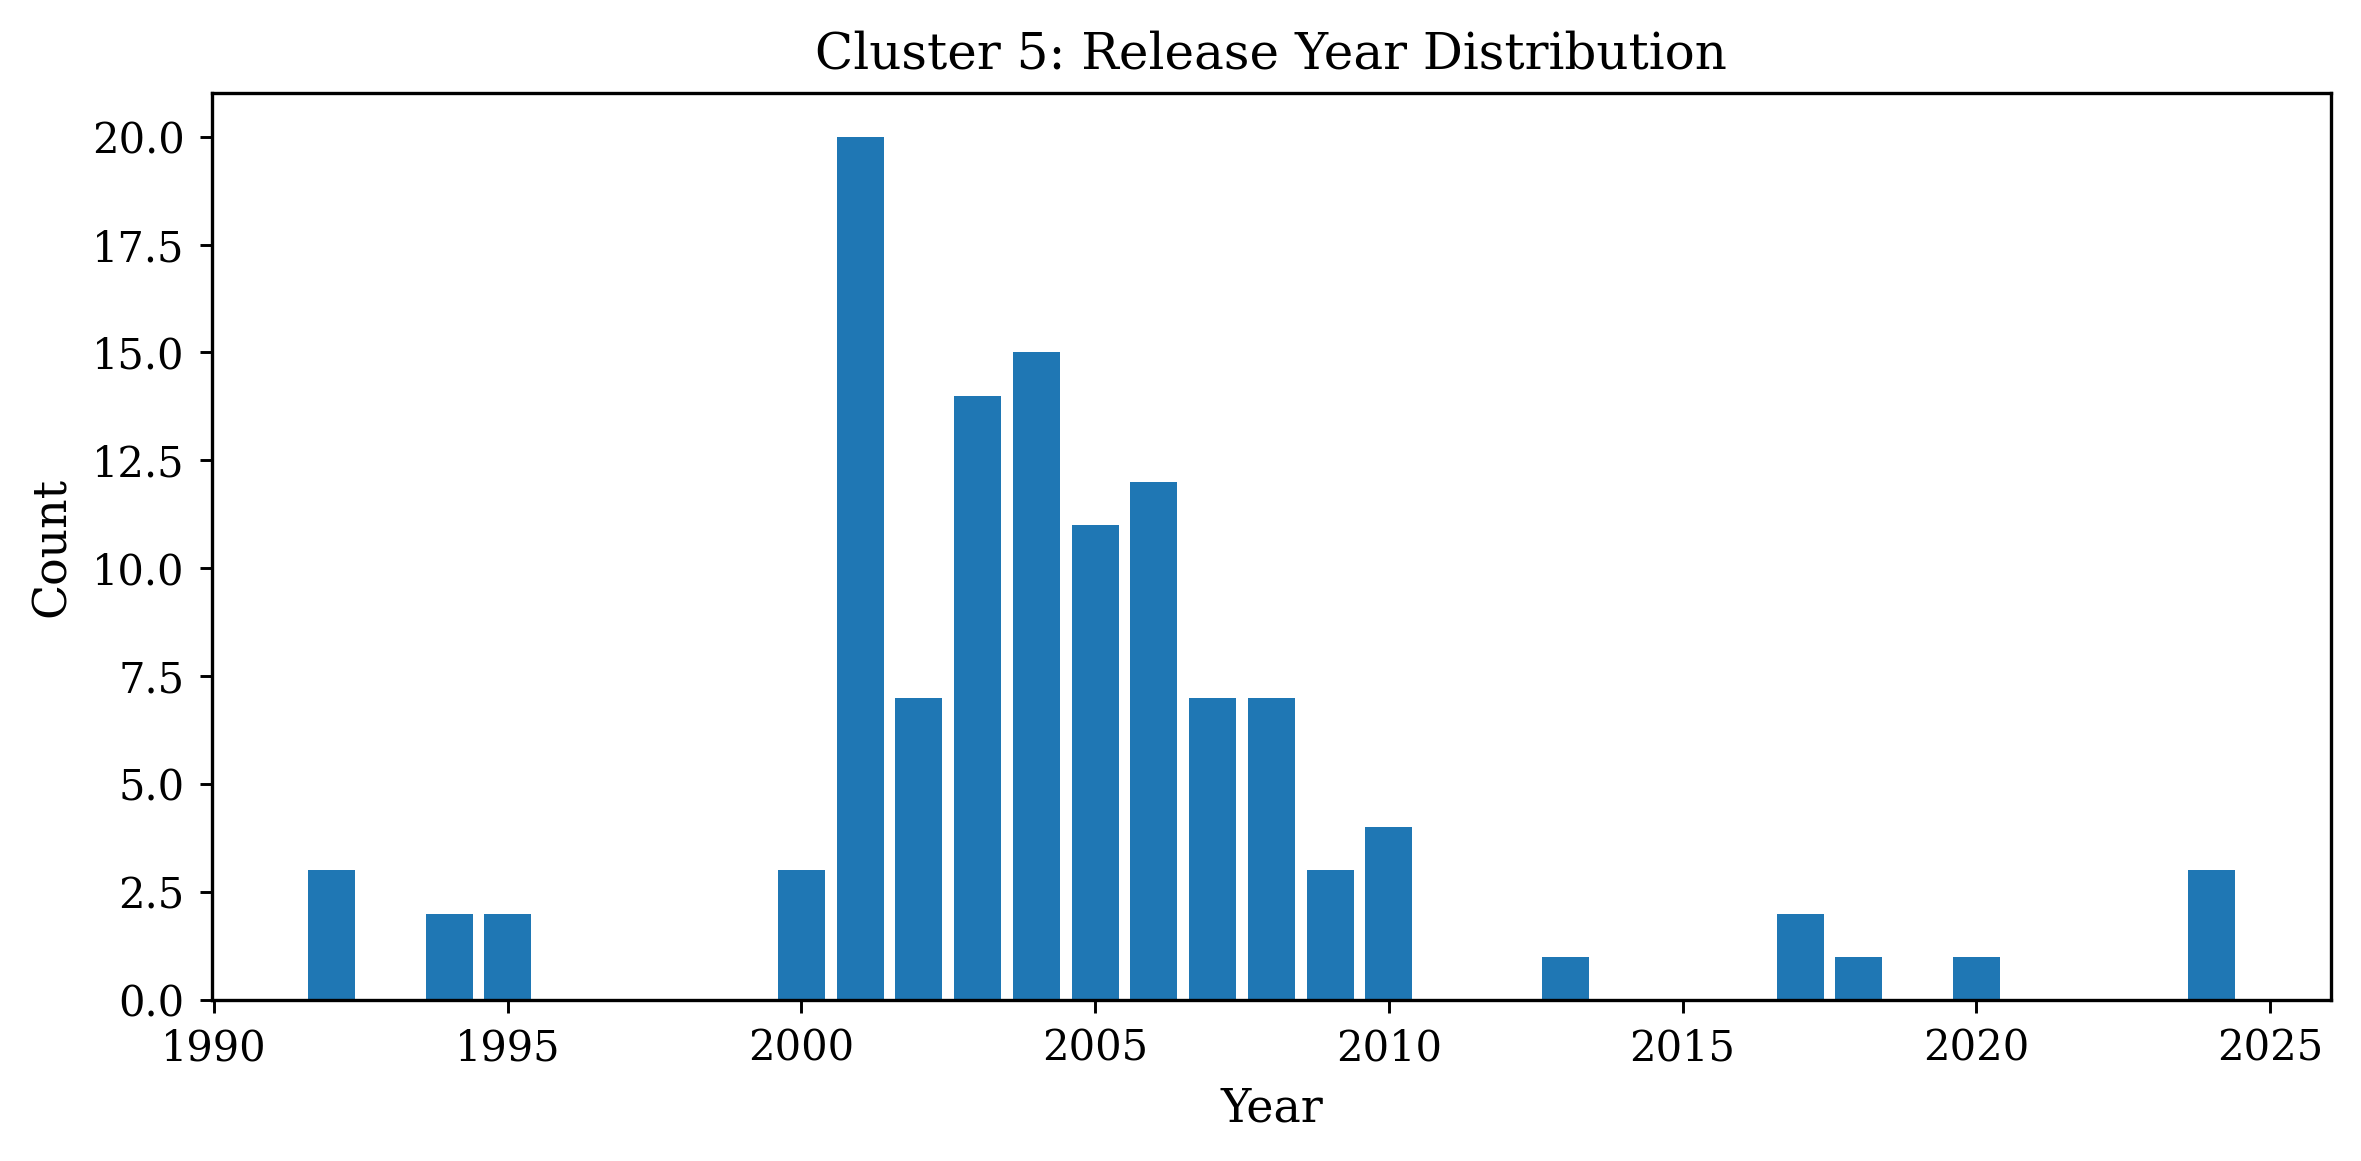

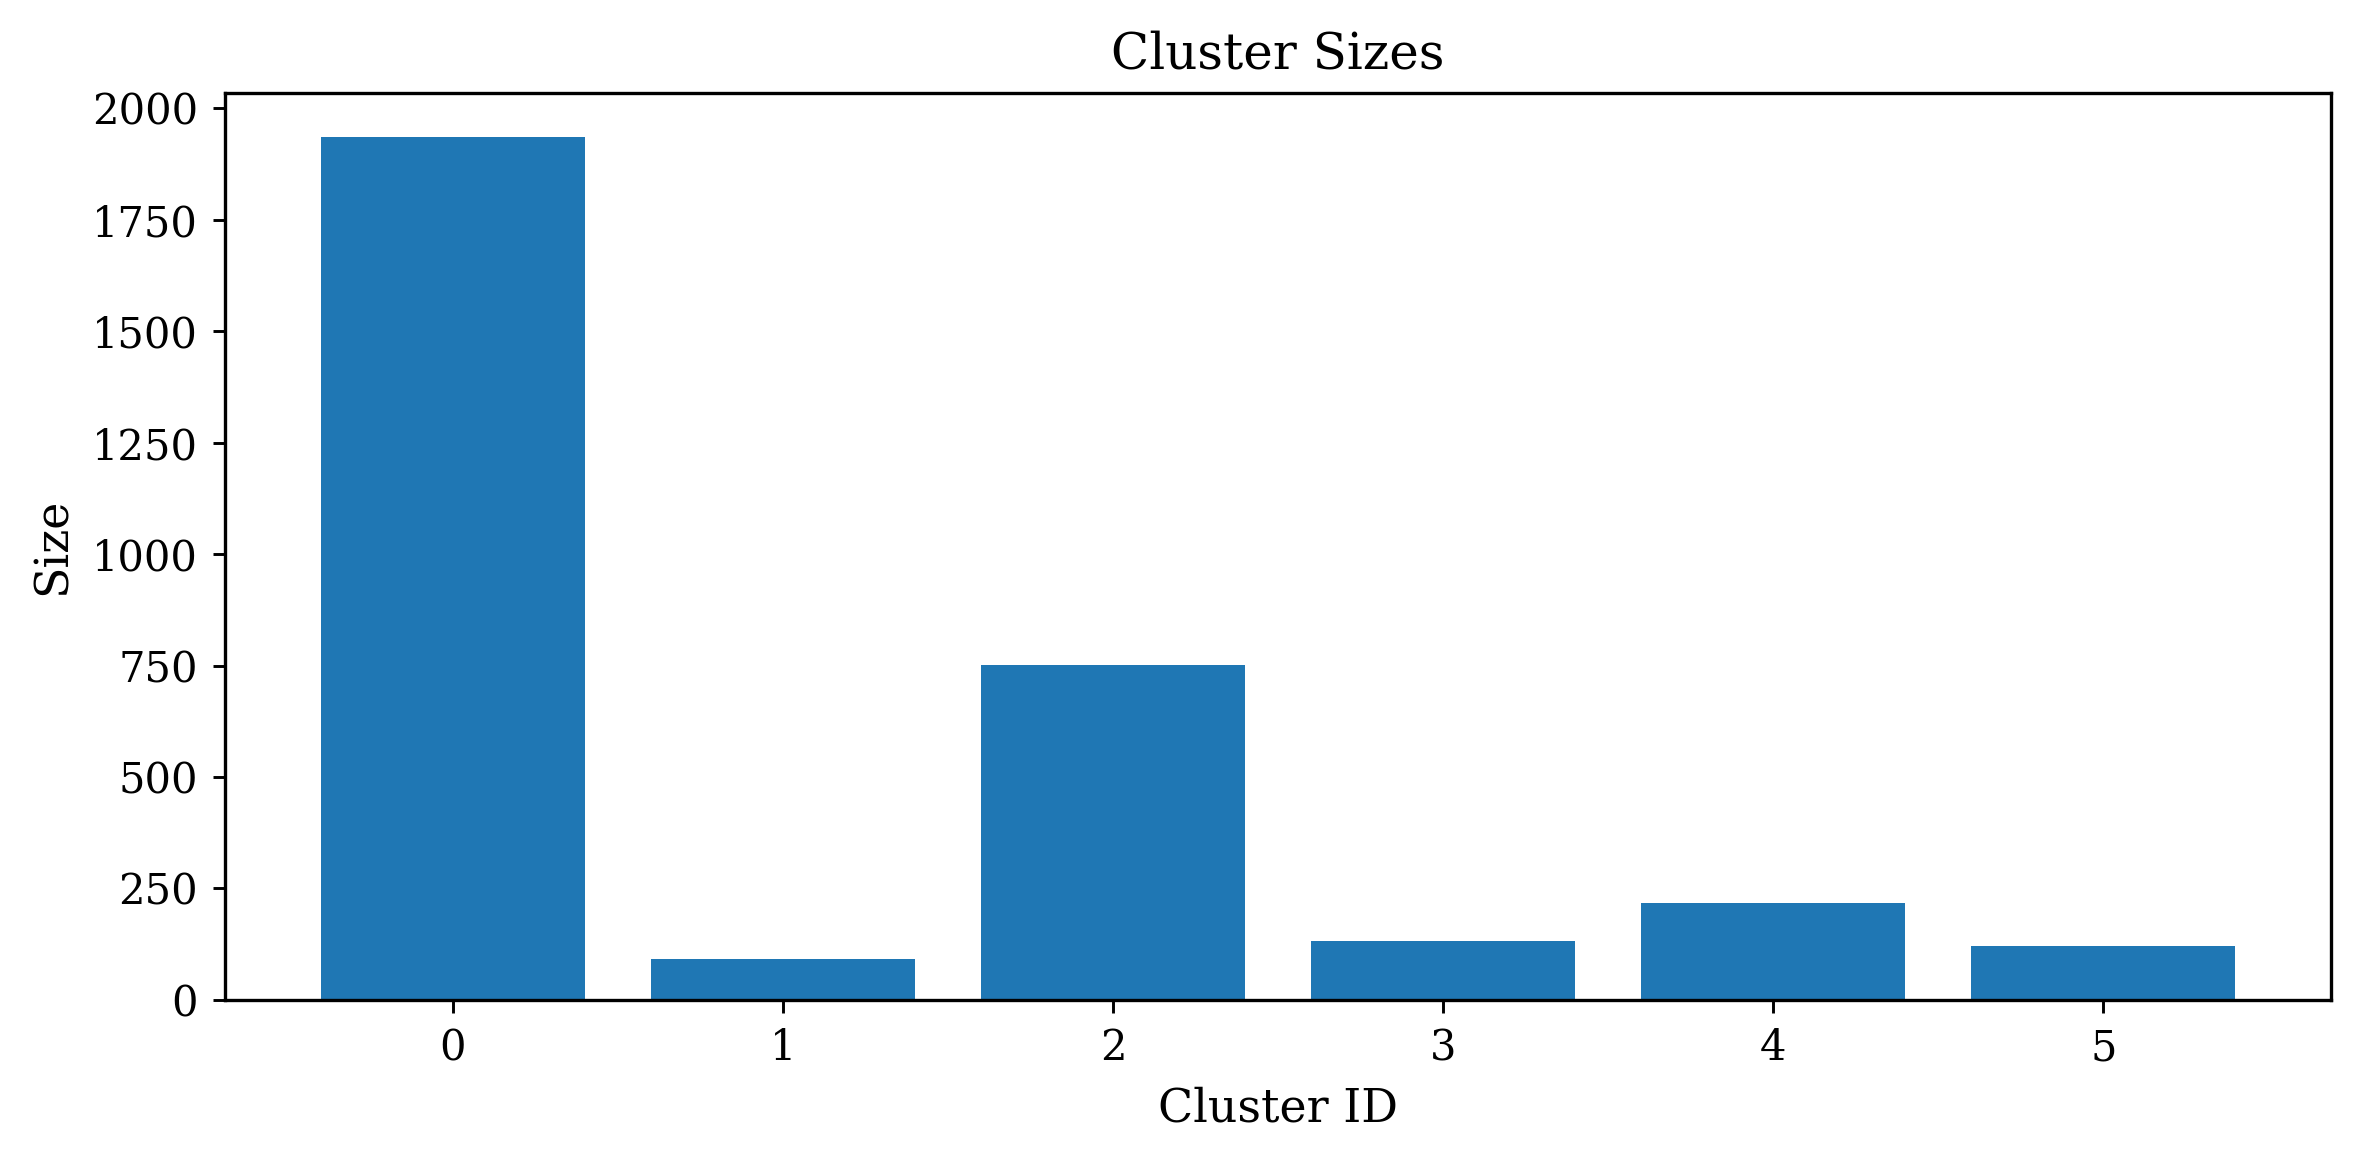

In [22]:
col_summary = {}
with open('results/ctms_general/json/ctms_column_summary.json', 'r') as f:
    col_summary = json.load(f)

plot_metadata_distributions(col_summary, top_n=10)